In [ ]:
## Notebook env: mirtud_env (R kernel)
## this notebook finds expression patterns in aggregated datasets

In [1]:
suppressMessages(library(Seurat))
suppressMessages(library(stringr))
suppressMessages(library(ggplot2))
suppressMessages(library(escape))
suppressMessages(library(dittoSeq))
suppressMessages(library(GSEABase))
suppressMessages(library(SummarizedExperiment))
suppressMessages(library(dbscan))
suppressMessages(library(igraph))
suppressMessages(library(tidyr))
suppressMessages(library(ggpubr))
suppressMessages(library(reshape2))
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(gridExtra))
suppressMessages(library(viridis))
options(repr.plot.width = 14, repr.plot.height = 10)

In [2]:
# load data
load("/home/ssobti/projects/mir_tud/output_data/genexp_pathway/pseudobulk_pathway_analysis_miR_abridged_progress_save.RData")

In [2]:
miR_loaded_seuratobj <- readRDS('/home/ssobti/projects/mir_tud/010523_filtered_data/miR_normalized_integrated_seurat.rds')
meta = miR_loaded_seuratobj@meta.data

meta$guide[str_sub(meta$guide, 1, 3) == 'TuD'] <- 'TuD_NC'
miR_loaded_seuratobj@meta.data <- meta

Warning message:
“Removed 1 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


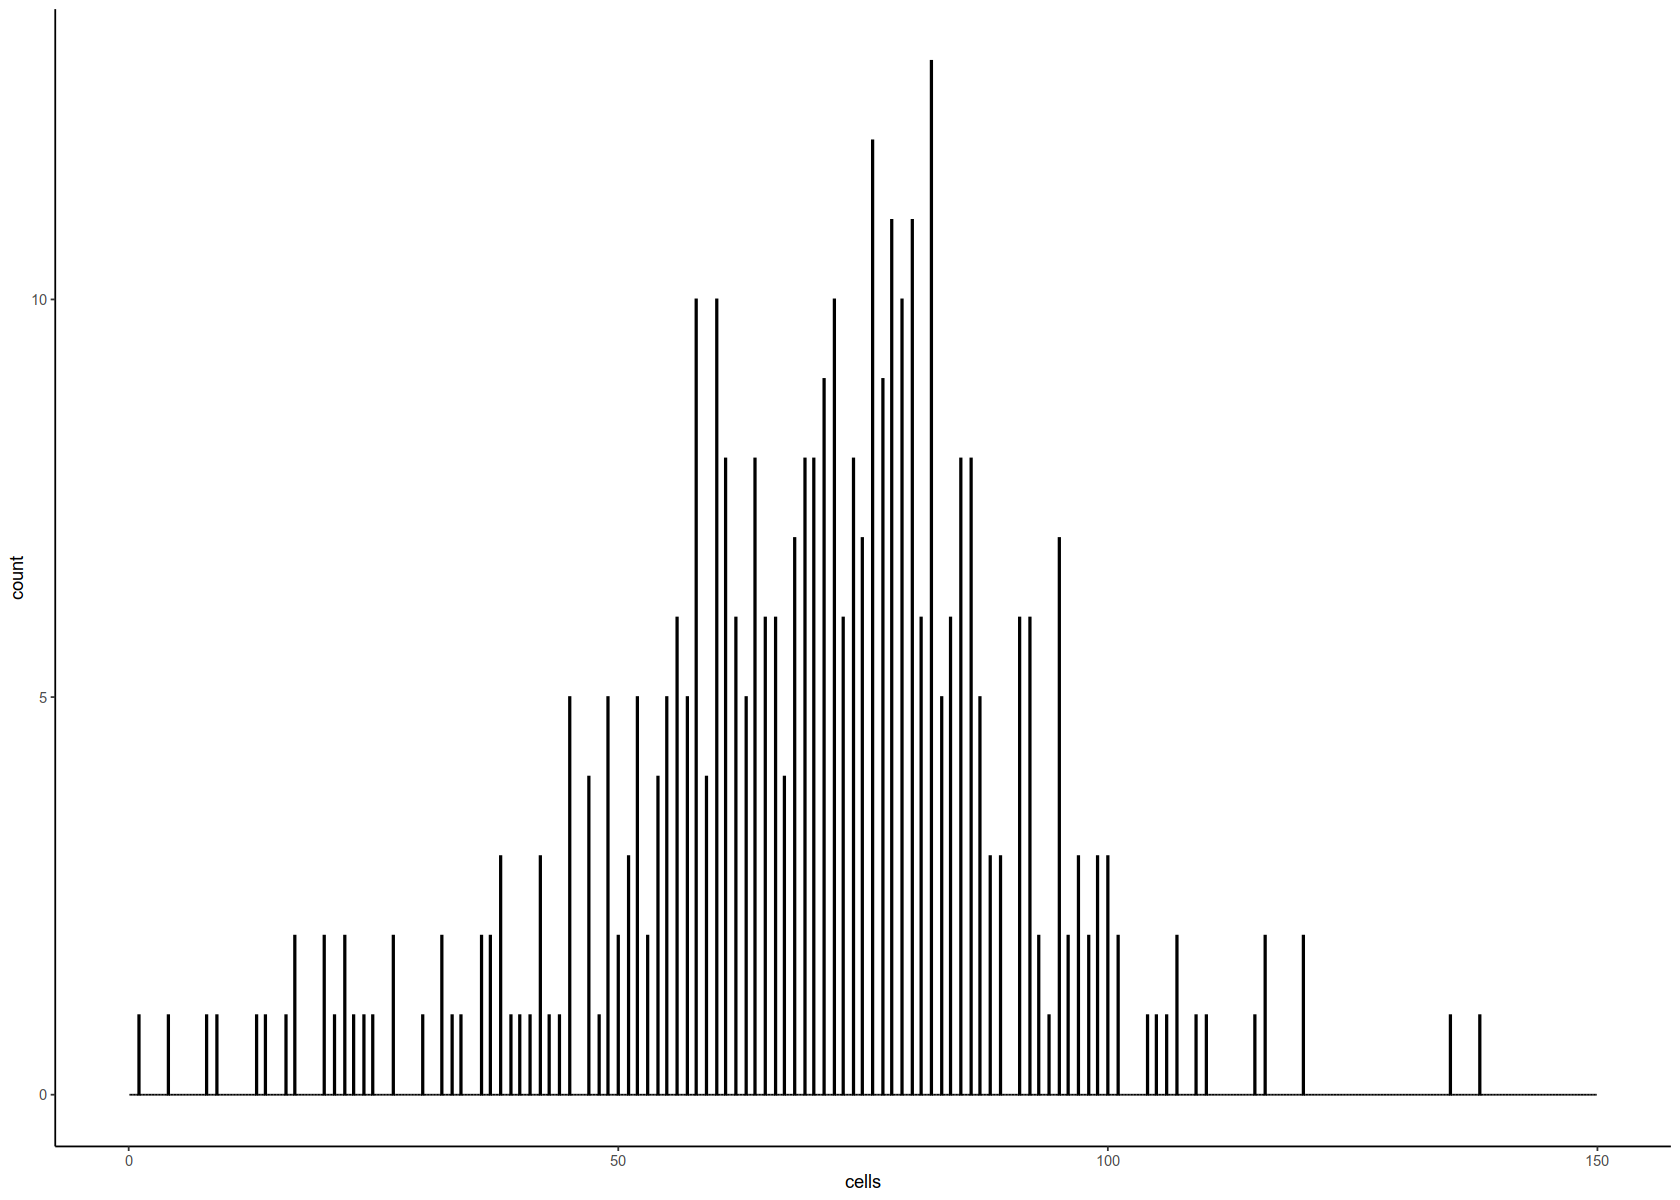

In [3]:
count_df = data.frame(guide = names(table(meta$guide)), cells = as.numeric(table(meta$guide)))
ggplot(count_df, aes(x = cells)) + geom_histogram(color="black", fill="white", position = "identity", bins = 1000) + 
xlim(0,150) + theme_classic()

In [4]:
suppressMessages(library(dplyr))
cbind(arrange(count_df, cells)[1:10,], arrange(count_df, -cells)[1:10,])

guide           cells guide            cells
1  hsa-miR-92a-3p   1    TuD_NC           3101 
2  hsa-miR-20a-5p   4    hsa-miR-3605-5p   138 
3  hsa-miR-92b-3p   8    hsa-miR-122-5p    135 
4  hsa-let-7a-5p    9    hsa-miR-10527-5p  120 
5  hsa-miR-221-3p  13    hsa-miR-1255a     120 
6  hsa-miR-106b-5p 14    hsa-miR-3928-3p   116 
7  hsa-miR-19b-3p  16    hsa-miR-4677-3p   116 
8  hsa-miR-222-3p  17    hsa-miR-3662      115 
9  hsa-miR-93-5p   17    hsa-miR-489-3p    110 
10 hsa-miR-16-5p   20    hsa-miR-877-5p    109

In [5]:
### seems like # of cells per guide is a huge covariate in expression (based on heatmap below without regressing it out)
## so need to control for it here
cell_guide_count = 1:nrow(meta)
for (i in 1:nrow(count_df)){
    cell_guide_count[meta$guide == count_df$guide[i]] = count_df$cells[i]
}

meta$cell_guide_count = cell_guide_count
miR_loaded_seuratobj@meta.data <- meta

In [ ]:
miR_seuratobj = CreateSeuratObject(miR_loaded_seuratobj@assays$RNA@counts, meta.data = miR_loaded_seuratobj@meta.data)
miR_seuratobj = NormalizeData(miR_seuratobj)
saveRDS(miR_seuratobj, '/home/ssobti/projects/mir_tud/output_data/genexp_pathway/miR_seuratobj_from_pseudobulk_pathway_analysis_miR_nb.rds')

In [7]:
miR_seuratobj_rel_norlmalized = CreateSeuratObject(miR_loaded_seuratobj@assays$RNA@counts, meta.data = miR_loaded_seuratobj@meta.data)
miR_seuratobj_rel_norlmalized = NormalizeData(miR_seuratobj_rel_norlmalized, normalization.method = 'RC')

In [8]:
#miR_seuratobj = ScaleData(miR_seuratobj, features = rownames(miR_seuratobj), vars.to.regress = c('sample', 'percent.mt', 'nCount_RNA', 'cell_guide_count'))

In [9]:
## create vector that randomly assigns cells to guides, make sure to keep control (TuD_NC) their original identity
set.seed(44)
randomized_cell_order = sample(1:ncol(miR_seuratobj), ncol(miR_seuratobj), replace = FALSE)
#randomized_filtered_raw_mtx = miR_seuratobj[,randomized_cell_order]
cell_counts = as.vector(table(miR_seuratobj@meta.data$guide))
guide_names = names(table(miR_seuratobj@meta.data$guide))
designation_vector = mapply(rep, guide_names, cell_counts, SIMPLIFY = TRUE)
designation_vector = unlist(designation_vector)
designation_vector = as.character(designation_vector)
designation_vector = designation_vector[randomized_cell_order]

## keep TuD_NC cells to their original identity
TuD_NC_true_idxs = which(miR_seuratobj@meta.data$guide == 'TuD_NC')
TuD_NC_current_idxs = which(designation_vector == 'TuD_NC')


TuD_NC_true_idxs_temp = setdiff(TuD_NC_true_idxs, TuD_NC_current_idxs)
TuD_NC_current_idxs_temp = setdiff(TuD_NC_current_idxs, TuD_NC_true_idxs)
TuD_NC_true_idxs = TuD_NC_true_idxs_temp
TuD_NC_current_idxs = TuD_NC_current_idxs_temp

TuD_NC_true_idxs = sample(TuD_NC_true_idxs) ## shuffling order
TuD_NC_current_idxs = sample(TuD_NC_current_idxs) ## shuffling order

tmp_designation_vector = designation_vector

designation_vector[TuD_NC_true_idxs] = miR_seuratobj@meta.data$guide[TuD_NC_true_idxs]
designation_vector[TuD_NC_current_idxs] = tmp_designation_vector[TuD_NC_true_idxs]

In [10]:
miR_seuratobj@meta.data$randomized_guide = designation_vector

In [11]:
Pseudo_bulk_exp = AverageExpression(miR_seuratobj, assays = "RNA", group.by = "guide", slot = "data")
Pseudo_bulk_exp = Pseudo_bulk_exp[['RNA']]

Pseudo_bulk_exp_counts = AverageExpression(miR_seuratobj, assays = "RNA", group.by = "guide", slot = "counts")
Pseudo_bulk_exp_counts = Pseudo_bulk_exp_counts[['RNA']]

In [12]:
Pseudo_bulk_exp_RC = AverageExpression(miR_seuratobj_rel_norlmalized, assays = "RNA", group.by = "guide", slot = "data")
Pseudo_bulk_exp_RC = Pseudo_bulk_exp_RC[['RNA']]

Warning message in PseudobulkExpression(object = object, pb.method = "average", :
“Exponentiation yielded infinite values. `data` may not be log-normed.”


In [13]:
## get rid of genes that are expressed as 0 in control as it's hard to calculate fold change dividing by zero, and they'd cluster together if you set them manually to zero
genes_to_discard = which(as.numeric(Pseudo_bulk_exp[,'TuD_NC']) == 0)
length(genes_to_discard)
Pseudo_bulk_exp = Pseudo_bulk_exp[-genes_to_discard,]

[1] 248

In [14]:
## obtaining gene sets via escape package
GS.hallmark <- getGeneSets(library = "H")
GS.hallmark = geneIds(GS.hallmark)

In [15]:
genes_present_in_set = vector(length = length(GS.hallmark))
for (i in 1:length(GS.hallmark)){
    genes_present_in_set[i] = length(which(GS.hallmark[[i]] %in% rownames(Pseudo_bulk_exp)))
}

geneset_gene_counts_df = data.frame(gene_set = names(GS.hallmark), genes_present = genes_present_in_set)




In [16]:
suppressMessages(library(dplyr))
geneset_gene_counts_df %>% arrange(genes_present) %>% head()

gene_set                            genes_present
1 HALLMARK_PANCREAS_BETA_CELLS        29           
2 HALLMARK_NOTCH_SIGNALING            31           
3 HALLMARK_ANGIOGENESIS               32           
4 HALLMARK_HEDGEHOG_SIGNALING         34           
5 HALLMARK_APICAL_SURFACE             39           
6 HALLMARK_WNT_BETA_CATENIN_SIGNALING 40

## Heatmaps of gene set expression

In [17]:
genesetexp_x_guide = matrix(0, nrow = length(GS.hallmark), ncol = ncol(Pseudo_bulk_exp), dimnames = list(names(GS.hallmark), colnames(Pseudo_bulk_exp)))

for (j in 1:ncol(Pseudo_bulk_exp)){
    for (i in 1:length(GS.hallmark)){
        genes = GS.hallmark[[i]][GS.hallmark[[i]] %in% rownames(Pseudo_bulk_exp)]
        genesetexp_x_guide[i,j] = mean(Pseudo_bulk_exp[genes,j])
    }
}

In [18]:
mean(range(genesetexp_x_guide))

[1] 2.235619

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  2

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



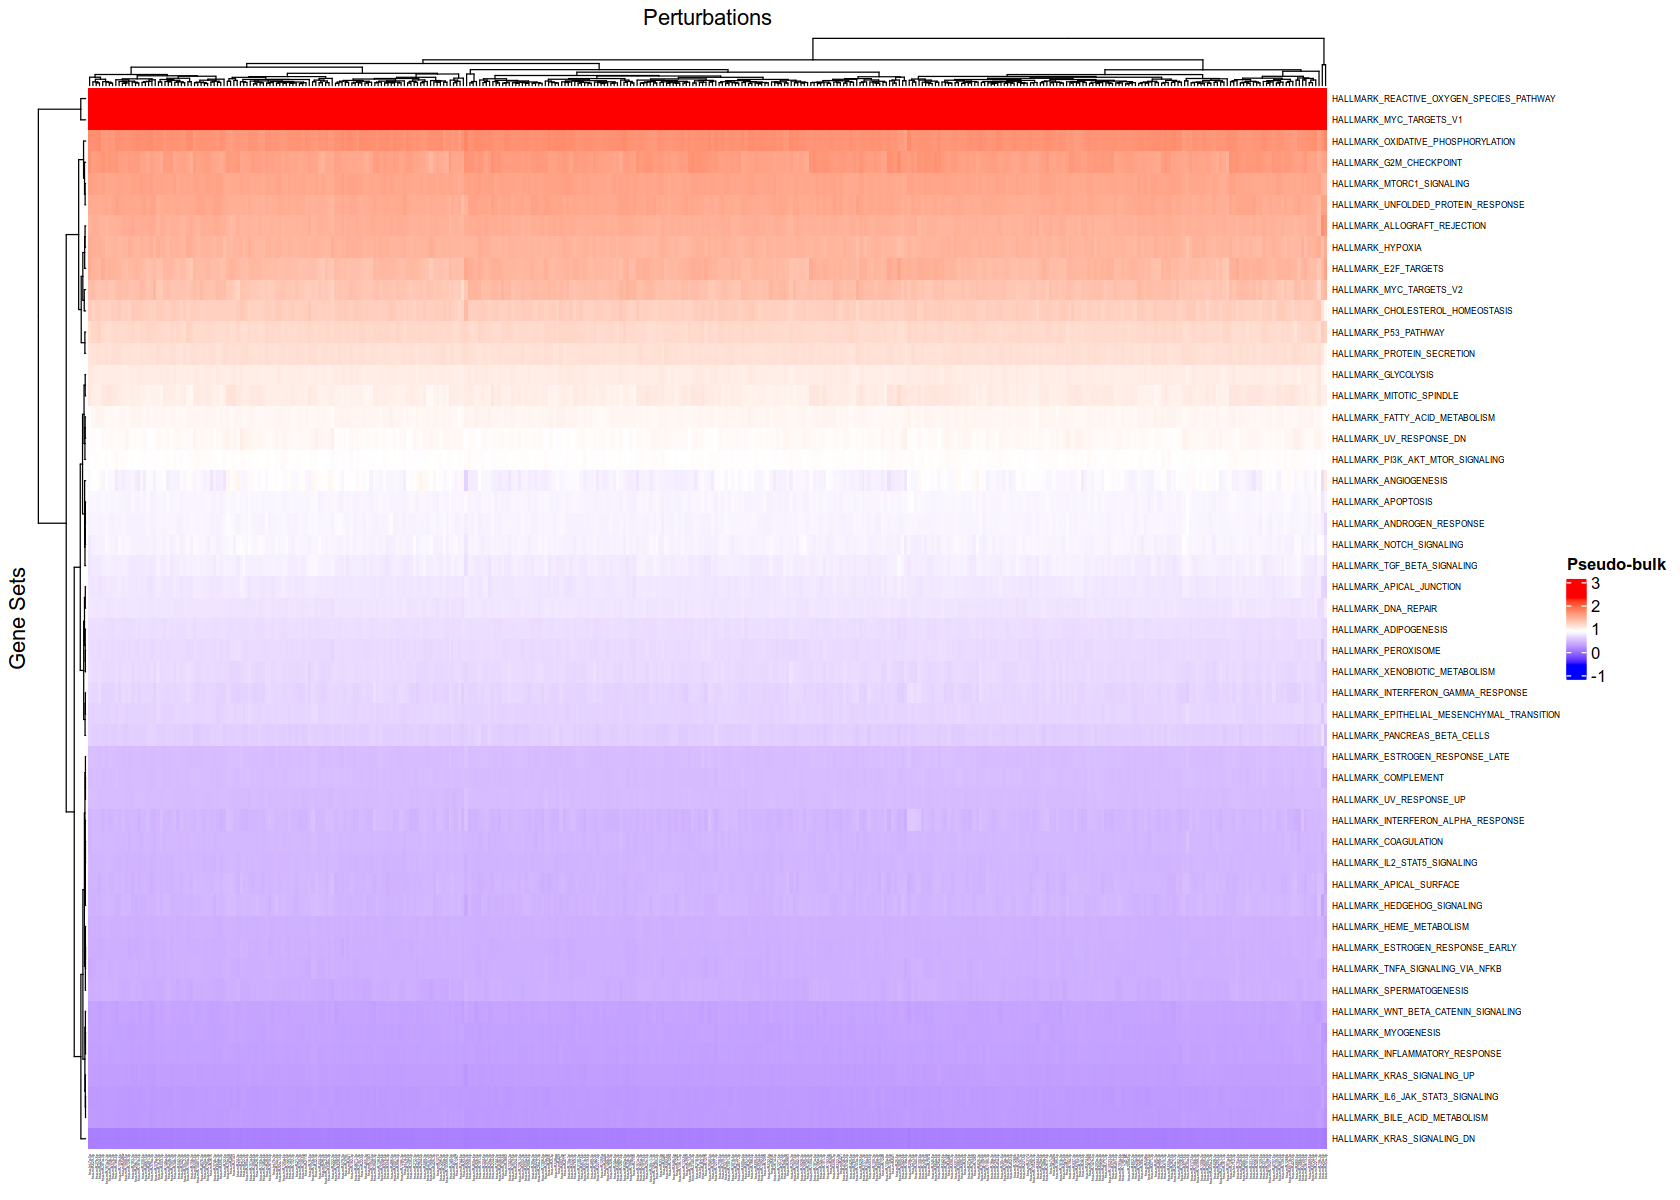

In [19]:
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(gridExtra))

avg = mean(genesetexp_x_guide)
lower_bound = mean(genesetexp_x_guide) - 2*sd(genesetexp_x_guide)
upper_bound = mean(genesetexp_x_guide) + 2*sd(genesetexp_x_guide)

coloring_map <- circlize::colorRamp2(c(lower_bound, avg, upper_bound), c("blue", "white", "red"))

perturb_htmp <- function(matrix, title, right_annot = NULL, bottom_annot = NULL) {
  draw(Heatmap(matrix, name = title, show_column_names = TRUE, show_row_names = TRUE, show_column_dend = TRUE,
               col = coloring_map, show_row_dend = TRUE, use_raster = TRUE, row_title = 'Gene Sets', 
               column_title = 'Perturbations', row_title_side = 'left', column_title_side = 'top', 
               column_names_gp = gpar(fontsize = 2), row_names_gp = gpar(fontsize = 5), right_annotation = right_annot, bottom_annotation = bottom_annot))
}


pdf('/home/ssobti/projects/mir_tud/output_data/genexp_pathway/pseudobulk_hallmark_htmap_miR.pdf', width = 12, height = 11)
perturb_htmp(genesetexp_x_guide, 'Pseudo-bulk')
dev.off()

perturb_htmp(genesetexp_x_guide, 'Pseudo-bulk')



## Heatmaps of gene set fold change expression to TuD_NC

In [20]:
class(genesetexp_x_guide)

[1] "matrix" "array"

In [21]:
tmp_df = as.data.frame(genesetexp_x_guide)
genesetexp_x_guide_FC = tmp_df
for (i in 1:ncol(tmp_df)){
    genesetexp_x_guide_FC[,i] = tmp_df[,i]/tmp_df[,'TuD_NC']
}

genesetexp_x_guide_FC = as.matrix(genesetexp_x_guide_FC)

In [22]:
range(genesetexp_x_guide_FC)

[1] 0.6715822 1.2490551

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  2

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



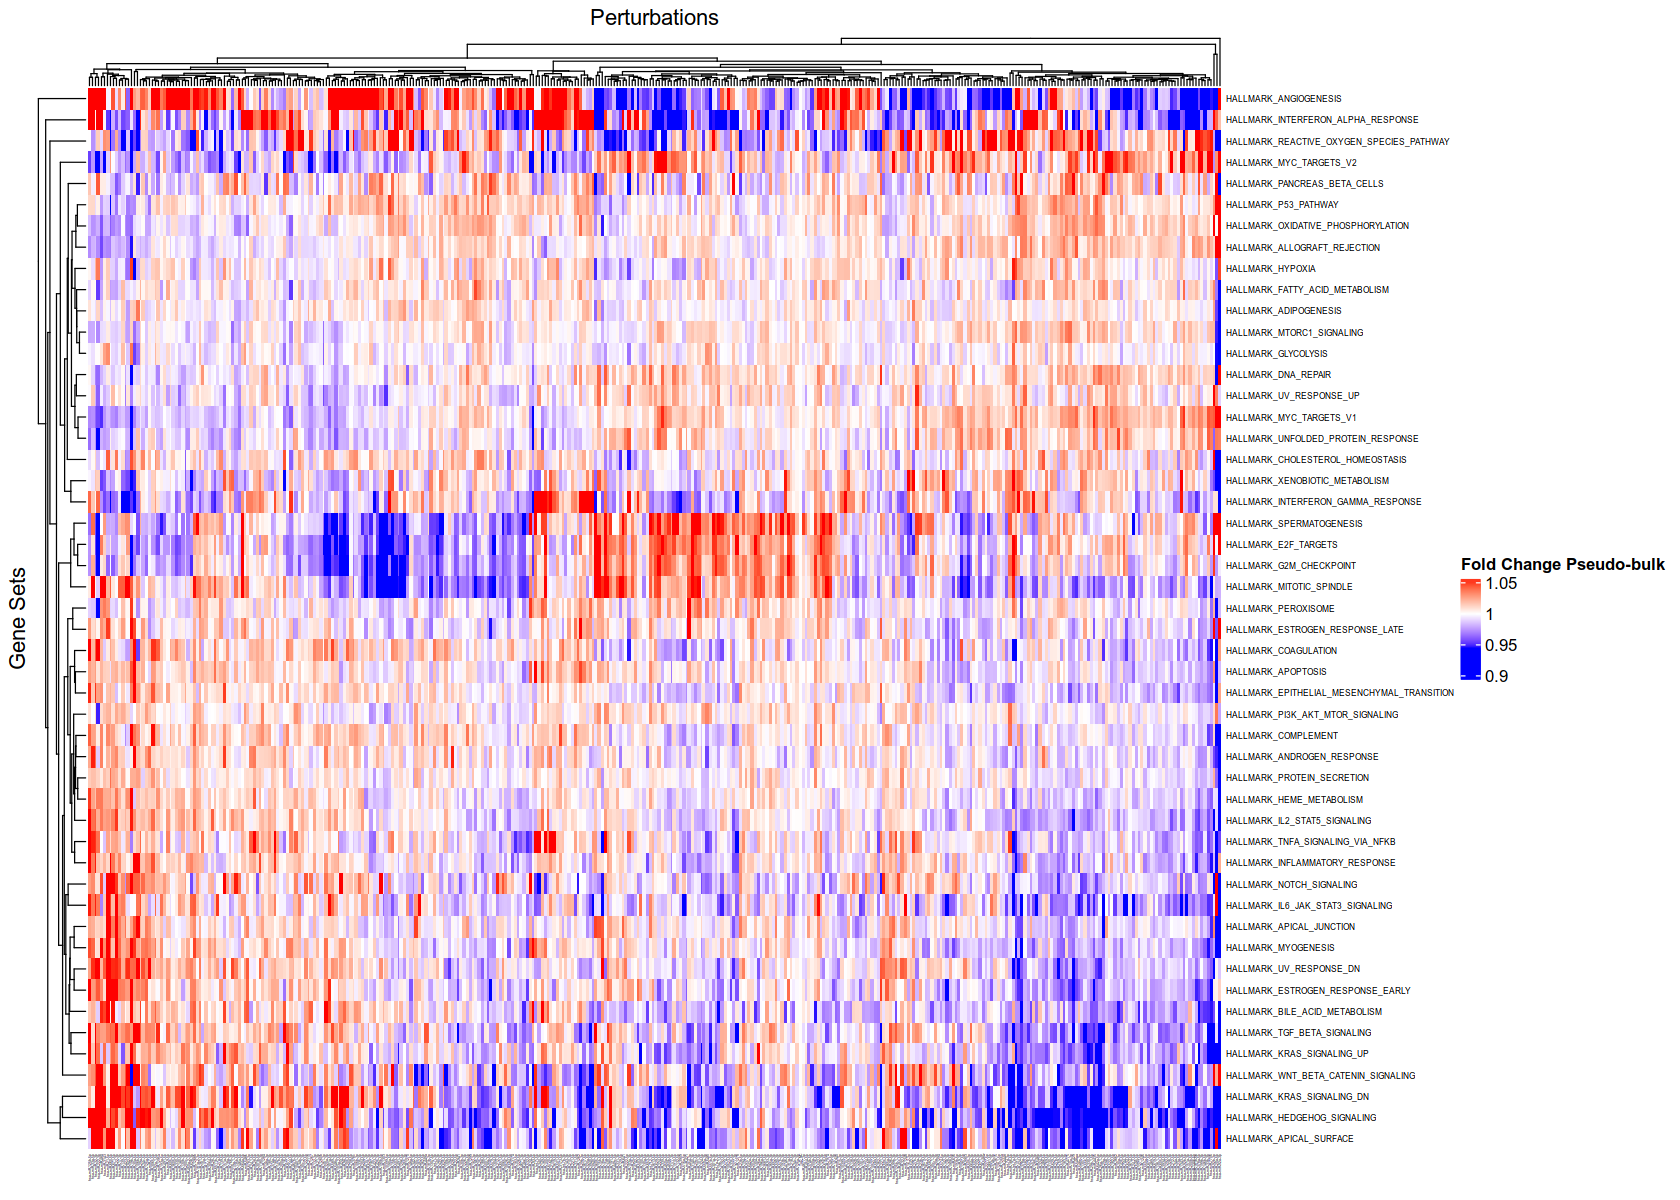

In [23]:
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(gridExtra))

avg = mean(genesetexp_x_guide_FC)
lower_bound = mean(genesetexp_x_guide_FC) - 2*sd(genesetexp_x_guide_FC)
upper_bound = mean(genesetexp_x_guide_FC) + 2*sd(genesetexp_x_guide_FC)

coloring_map <- circlize::colorRamp2(c(lower_bound, avg, upper_bound), c("blue", "white", "red"))

perturb_htmp <- function(matrix, title, right_annot = NULL, bottom_annot = NULL) {
  draw(Heatmap(matrix, name = title, show_column_names = TRUE, show_row_names = TRUE, show_column_dend = TRUE,
               col = coloring_map, show_row_dend = TRUE, use_raster = TRUE, row_title = 'Gene Sets', 
               column_title = 'Perturbations', row_title_side = 'left', column_title_side = 'top', 
               column_names_gp = gpar(fontsize = 2), row_names_gp = gpar(fontsize = 5), right_annotation = right_annot, bottom_annotation = bottom_annot))
}

pdf('/home/ssobti/projects/mir_tud/output_data/genexp_pathway/pseudobulk_foldchange_hallmark_htmap_miR.pdf', width = 12, height = 11)
perturb_htmp(genesetexp_x_guide_FC, 'Fold Change Pseudo-bulk')
dev.off()

foldchange_htmp = perturb_htmp(genesetexp_x_guide_FC, 'Fold Change Pseudo-bulk')

## Randomizing cell labels to see if all cells are cycling through prominent pathways or effect is guide specific

In [24]:
## Make sure variability in FC heatmap for cell cycle genes is greater than if cells were randomly assigned to perturbations
Pseudo_bulk_exp_randomized = AverageExpression(miR_seuratobj, assays = "RNA", group.by = "randomized_guide", slot = "data")
Pseudo_bulk_exp_randomized = Pseudo_bulk_exp_randomized[['RNA']]


genesetexp_x_randomized_guide = matrix(0, nrow = length(GS.hallmark), ncol = ncol(Pseudo_bulk_exp_randomized), dimnames = list(names(GS.hallmark), colnames(Pseudo_bulk_exp_randomized)))

for (j in 1:ncol(Pseudo_bulk_exp_randomized)){
    for (i in 1:length(GS.hallmark)){
        genes = GS.hallmark[[i]][GS.hallmark[[i]] %in% rownames(Pseudo_bulk_exp_randomized)]
        genesetexp_x_randomized_guide[i,j] = mean(Pseudo_bulk_exp_randomized[genes,j])
    }
}

tmp_df = as.data.frame(genesetexp_x_randomized_guide)
genesetexp_x_randomized_guide_FC = tmp_df
for (i in 1:ncol(tmp_df)){
    genesetexp_x_randomized_guide_FC[,i] = tmp_df[,i]/tmp_df[,'TuD_NC']
}

genesetexp_x_randomized_guide_FC = as.matrix(genesetexp_x_randomized_guide_FC)

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



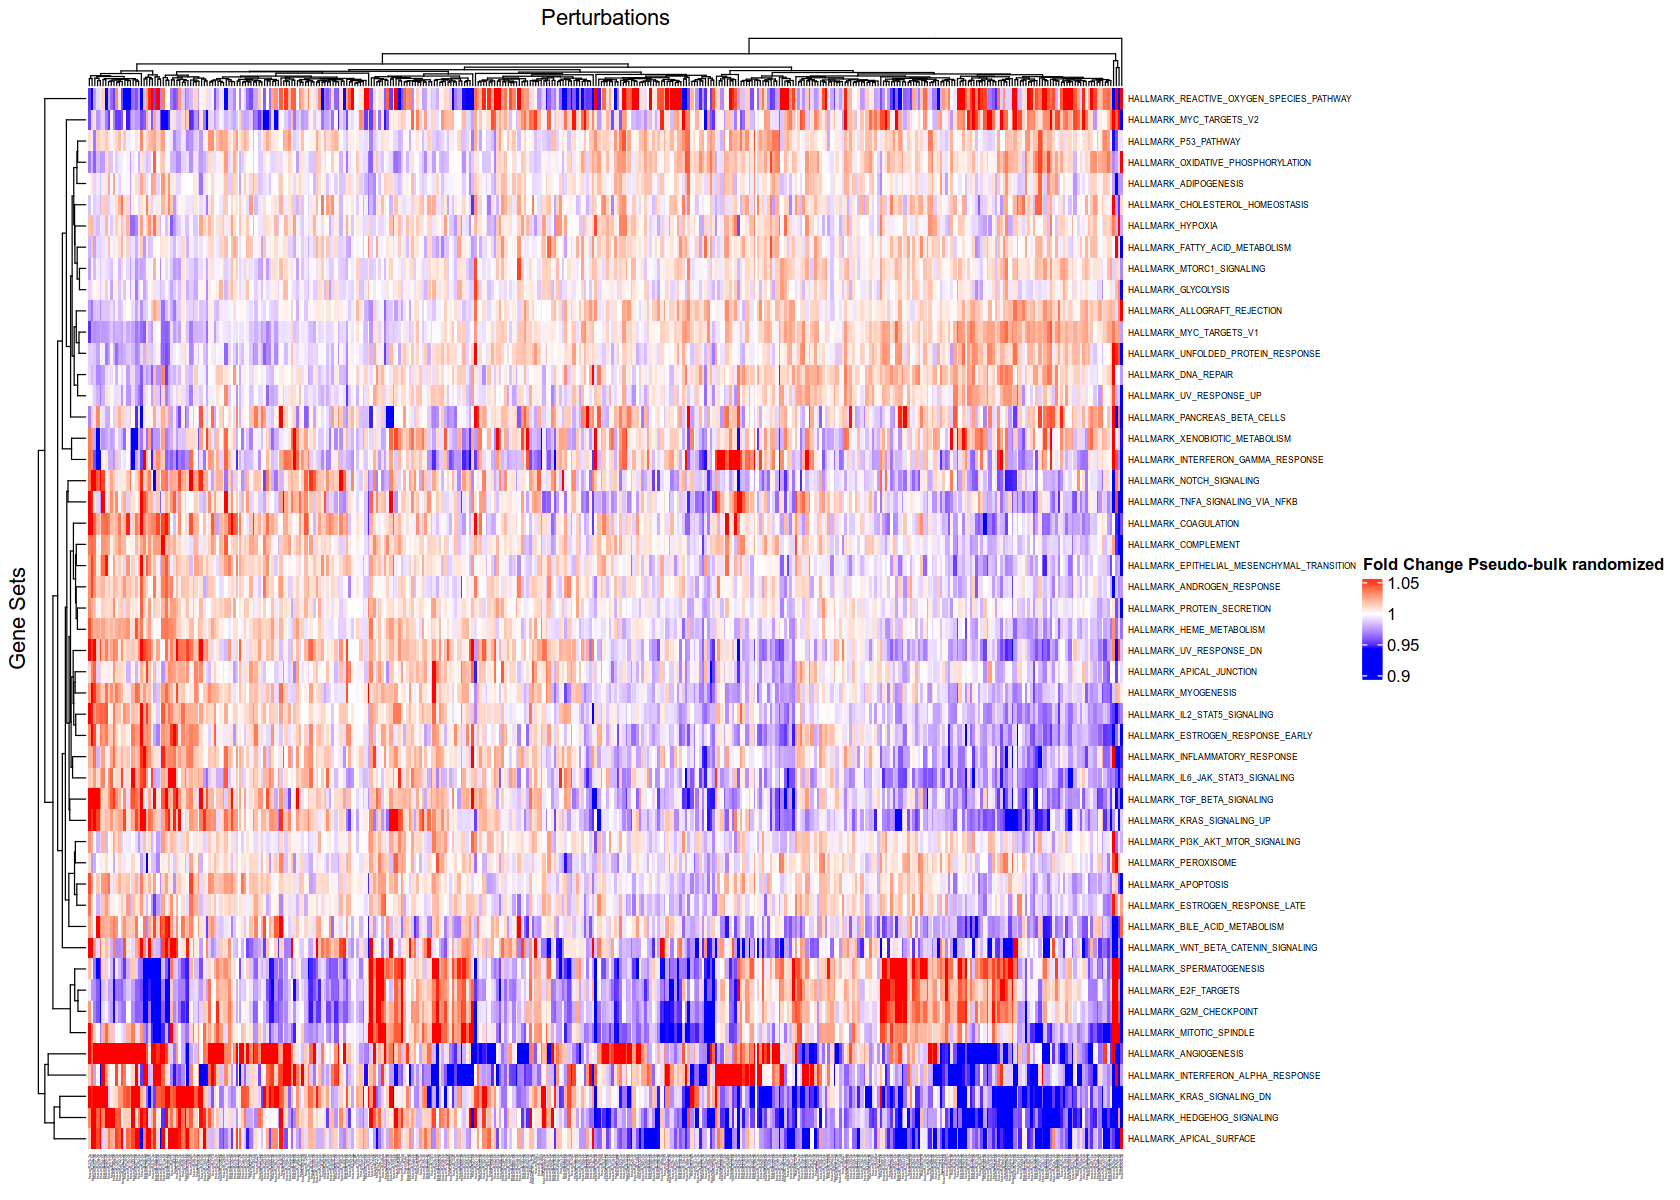

In [25]:
## random cell labels heatmap
avg = mean(genesetexp_x_randomized_guide_FC)
lower_bound = mean(genesetexp_x_randomized_guide_FC) - 2*sd(genesetexp_x_randomized_guide_FC)
upper_bound = mean(genesetexp_x_randomized_guide_FC) + 2*sd(genesetexp_x_randomized_guide_FC)

coloring_map <- circlize::colorRamp2(c(lower_bound, avg, upper_bound), c("blue", "white", "red"))

perturb_htmp(genesetexp_x_randomized_guide_FC, 'Fold Change Pseudo-bulk randomized')

In [26]:
### check distribution of prominent pathways for all the guides
## ie plot prominent rows in heatmaps as histograms

## prominent pathways
pathways_to_check = c('HALLMARK_G2M_CHECKPOINT', 'HALLMARK_SPERMATOGENESIS', 
                      'HALLMARK_E2F_TARGETS', 'HALLMARK_MITOTIC_SPINDLE',
                     'HALLMARK_GLYCOLYSIS', 'HALLMARK_MTORC1_SIGNALING', 
                      'HALLMARK_DNA_REPAIR', 'HALLMARK_UV_RESPONSE_UP')

## last 4 gene sets are control genesets
df1 = pivot_longer(as.data.frame(t(genesetexp_x_randomized_guide_FC[pathways_to_check,])), cols = everything(), names_to = 'pathway', values_to = 'guide_FC_exp')
df2 = pivot_longer(as.data.frame(t(genesetexp_x_guide_FC[pathways_to_check,])), cols = everything(), names_to = 'pathway', values_to = 'guide_FC_exp')

In [27]:
df1$label = 'random'
df2$label = 'actual'
df3 = rbind(df1,df2)
df3$label <- factor(df3$label, levels = c('random', 'actual'))


Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”


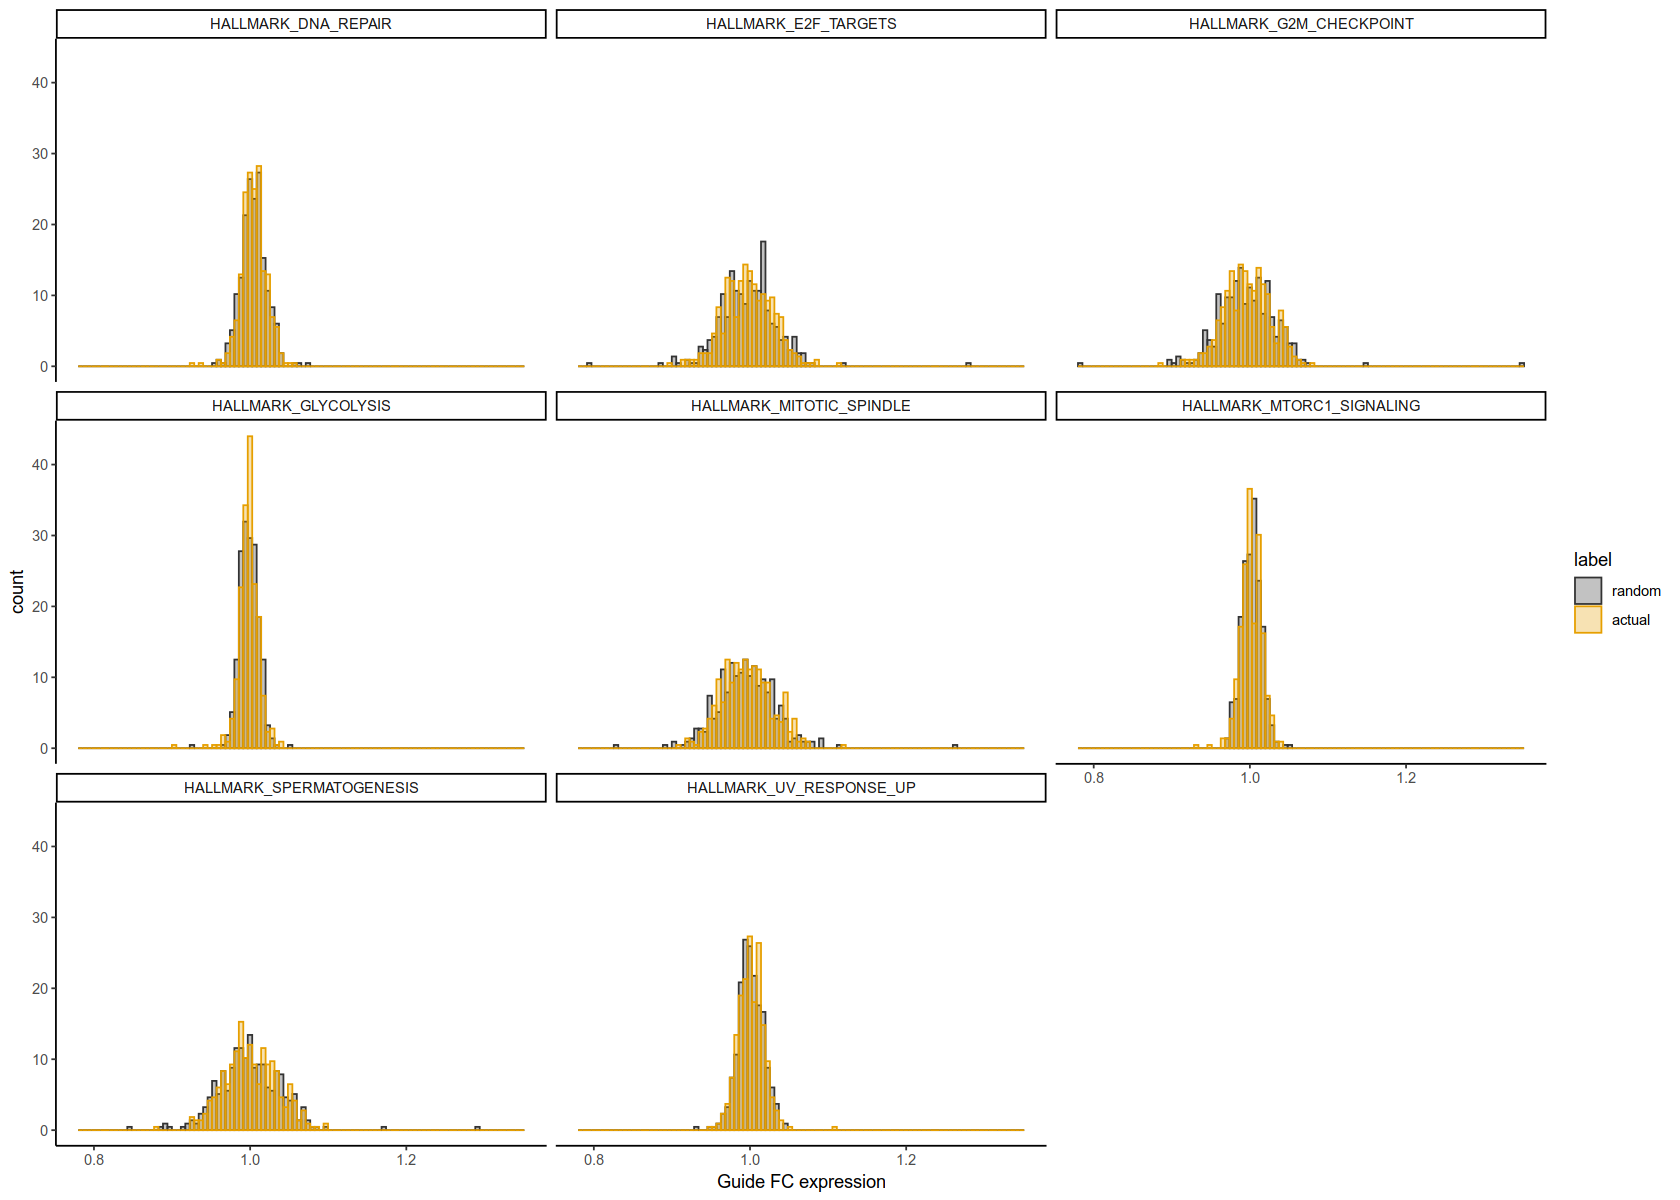

In [28]:
ggplot(df3, aes(x=guide_FC_exp, color=label, fill=label)) +
geom_histogram(aes(y=..density..), position="identity", alpha=0.3, bins = 100) +
scale_color_manual(values=c("grey20", "#E69F00", "#56B4E9")) +
scale_fill_manual(values=c("grey20", "#E69F00", "#56B4E9")) +
labs(x = "Guide FC expression", y = "count") +
theme_classic() + facet_wrap(~pathway)

## Comparing CVs of pathways between actual and random cell labels

###### CVs of each pathway across all guides should be different between actual and random guide cell labels ######

In [29]:
### since we don't see much difference between the actual and randomized label FC heatmaps, 
## can look to see if there is a difference in  their distributions CV for all pathways
library(matrixStats)
CVs_randomized = rowSds(genesetexp_x_randomized_guide_FC)/rowMeans2(genesetexp_x_randomized_guide_FC)
CVs_actual = rowSds(genesetexp_x_guide_FC)/rowMeans2(genesetexp_x_guide_FC)

In [30]:
identical(rownames(genesetexp_x_guide_FC), rownames(genesetexp_x_randomized_guide_FC))

[1] TRUE

In [31]:
CV_actual_randomized_labels_ratio = CVs_actual/CVs_randomized

In [32]:
df = data.frame(metric = c(CVs_actual, CVs_randomized, CV_actual_randomized_labels_ratio),
                type = c(rep('CVs_actual', length(CVs_actual)), 
                         rep('CVs_randomized', length(CVs_randomized)),
                         rep('CV_actual_randomized_labels_ratio', length(CV_actual_randomized_labels_ratio))))

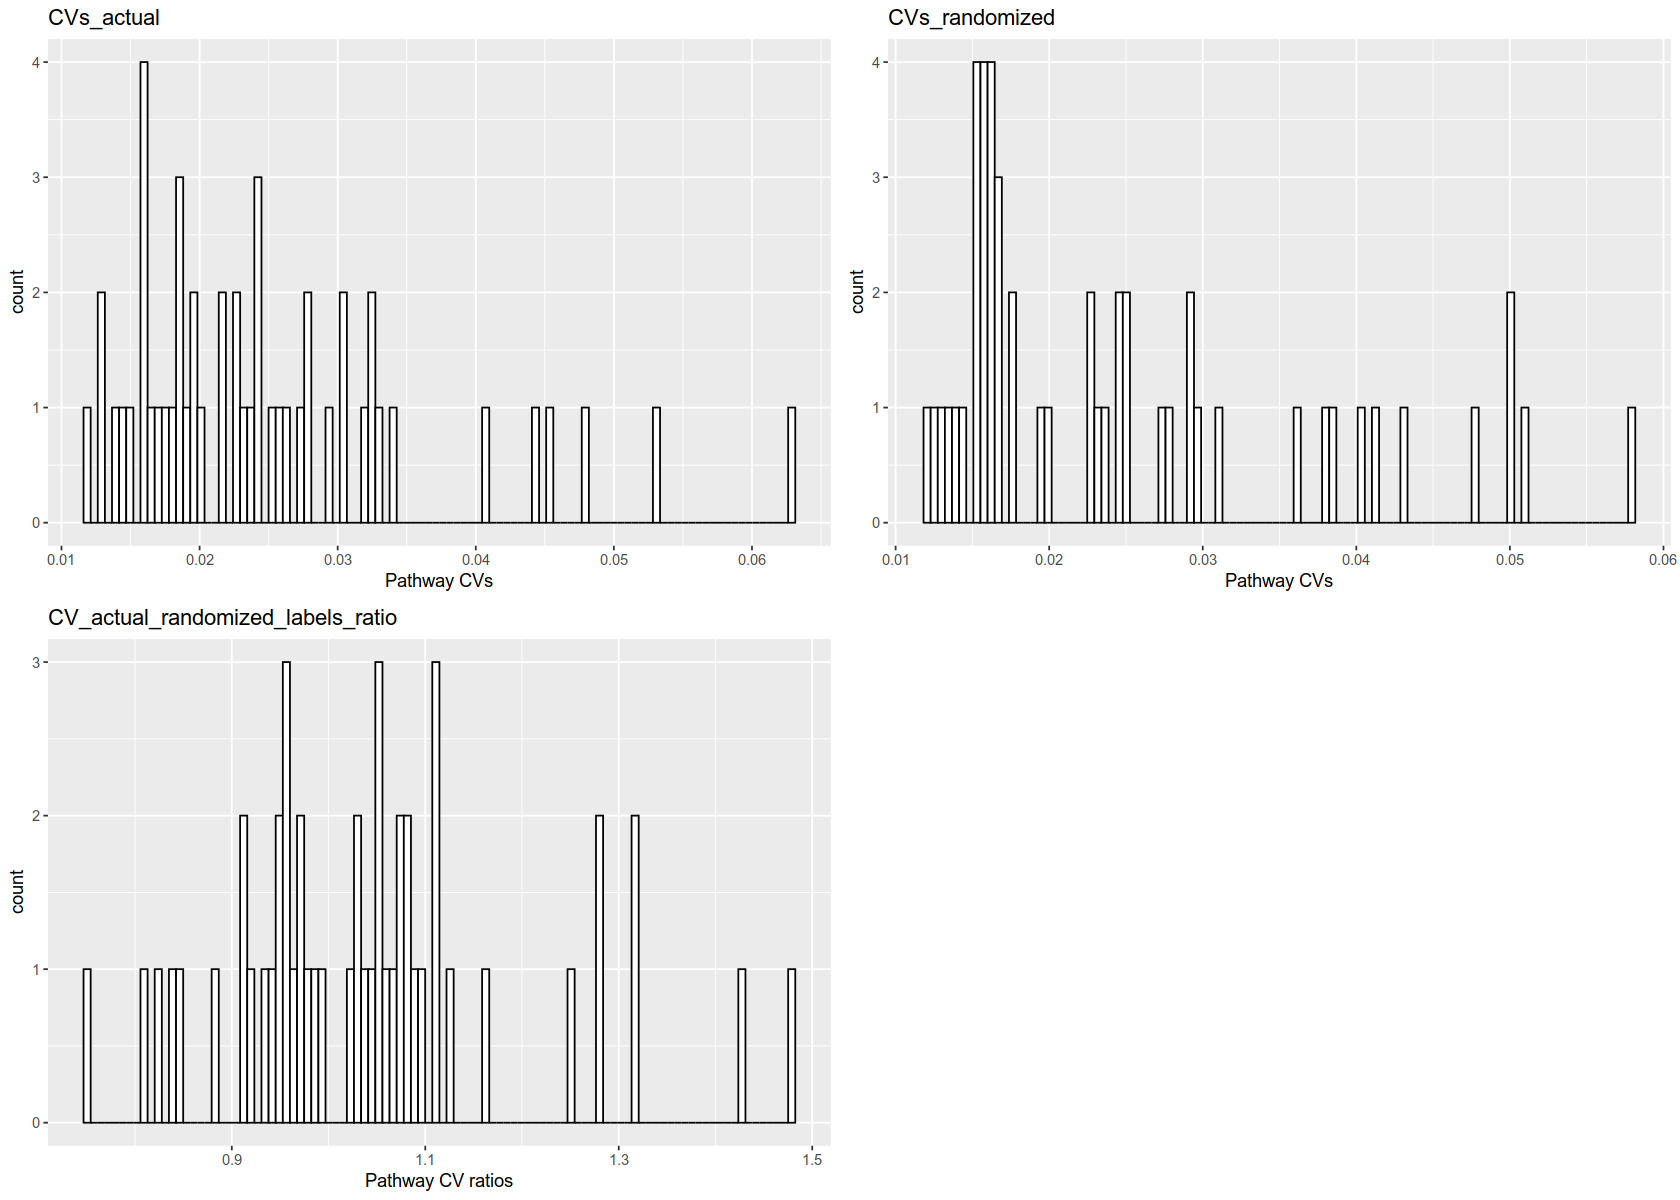

In [33]:
a <- ggplot(df[df$type == 'CVs_actual',], aes(x = metric)) + 
  geom_histogram(color = "black", fill = "white", bins = 100) + ggtitle('CVs_actual') + xlab('Pathway CVs')
b <- ggplot(df[df$type == 'CVs_randomized',], aes(x = metric)) + 
  geom_histogram(color = "black", fill = "white", bins = 100) + ggtitle('CVs_randomized') + xlab('Pathway CVs')
c <- ggplot(df[df$type == 'CV_actual_randomized_labels_ratio',], aes(x = metric)) + 
  geom_histogram(color = "black", fill = "white", bins = 100) + ggtitle('CV_actual_randomized_labels_ratio') + xlab('Pathway CV ratios')

ggarrange(a,b,c)

## Creating clustering based custom gene sets (trying both HDBSCAN and Louvain)

#### Converting gene x guide matrix to gene x guide PC matrix

In [34]:
## do a correlation analysis of how expression is in reality compared to what's expected from known target genes


In [35]:
## run spearman correlation on Pseudo_bulk_exp matrix
gene_gene_corr_mtx <- cor(t(Pseudo_bulk_exp), method = 'spearman')

In [36]:
gene_gene_corr_mtx[1:10,1:10]

AL627309.1  AL627309.5   AL627309.4   AP006222.2   AL669831.2  
AL627309.1  1.00000000  0.110139728  0.037938859  0.032850433  0.019729889
AL627309.5  0.11013973  1.000000000  0.062258345 -0.005908042 -0.039642958
AL627309.4  0.03793886  0.062258345  1.000000000  0.044411481 -0.003279383
AP006222.2  0.03285043 -0.005908042  0.044411481  1.000000000  0.007959026
AL669831.2  0.01972989 -0.039642958 -0.003279383  0.007959026  1.000000000
LINC01409   0.03781370 -0.004261597 -0.039290867  0.016330738  0.073870159
FAM87B     -0.01564699 -0.012421263  0.094121893  0.009351918  0.054317608
LINC01128   0.06591372 -0.047088219  0.007267487 -0.023922619 -0.055310181
LINC00115   0.01581436  0.049655681  0.013603089 -0.035061004  0.016400872
FAM41C     -0.03656204 -0.023899371  0.048432393  0.001289101  0.037397619
           LINC01409    FAM87B       LINC01128    LINC00115   FAM41C      
AL627309.1  0.037813701 -0.015646993  0.065913717  0.01581436 -0.036562040
AL627309.5 -0.004261597 -0.012421263 -0.047088219  0.04965568 -0.023899371
AL627309.4 -0.039290867  0.094121893  0.007267487  0.01360309  0.048432393
AP006222.2  0.016330738  0.009351918 -0.023922619 -0.03506100  0.001289101
AL669831.2  0.073870159  0.054317608 -0.055310181  0.01640087  0.037397619
LINC01409   1.000000000 -0.013979905  0.003660449  0.02364936 -0.004453084
FAM87B     -0.013979905  1.000000000  0.103599658 -0.05613211  0.070186594
LINC01128   0.003660449  0.103599658  1.000000000  0.08247071  0.011315610
LINC00115   0.023649360 -0.056132108  0.082470714  1.00000000 -0.045305639
FAM41C     -0.004453084  0.070186594  0.011315610 -0.04530564  1.000000000

In [37]:
### run HDBSCAN on cell x gene matrix to find gene clusters 
## that will define gene sets in heatmaps in pseudobulk_pathway_analysis_miR.ipynb

### first perform PCA on cell x gene to reduce cells (not genes) to 50 dims since HDBSCAN doesn't work well in high dims

## Convert FC matrix in next 2 cells and any other relevant places to logFC!!!

In [38]:
tmp_df = as.data.frame(Pseudo_bulk_exp)
Pseudo_bulk_exp_FC = tmp_df
for (i in 1:ncol(tmp_df)){
    Pseudo_bulk_exp_FC[,i] = tmp_df[,i]/tmp_df[,'TuD_NC']
}

Pseudo_bulk_exp_FC = as.matrix(Pseudo_bulk_exp_FC)

In [39]:
Pseudo_bulk_exp_FC = subset(Pseudo_bulk_exp_FC, select = -c(TuD_NC))

In [40]:
pca = prcomp(Pseudo_bulk_exp_FC, scale. = TRUE)
PCA_coordinates = pca$x
PCA_coordinates_final = PCA_coordinates[, 1:50]

#### Visualizing gene x guide matrix PCs with UMAP (genes plotted in UMAP below)

In [41]:
#umap1 = uwot::umap(PCA_coordinates_final)

In [42]:
## create a umap of genes and manually cluster

#colnames(umap1) <- c('UMAP_1', 'UMAP_2')
#umap1 = as.data.frame(umap1)

#ggplot(umap1, aes(UMAP_1, UMAP_2)) + geom_point()

#### Running HDBSCAN on data on the genes in gene x guide PC matrix to group them

In [43]:
#cl <- hdbscan(PCA_coordinates_final, minPts = 2)
#cl

In [44]:
#cl$cluster

#### Running louvain algorithm on data on the genes in gene x guide PC matrix SNN graph to group them

In [3]:
library(bluster)

In [4]:
graph.out0 = clusterRows(PCA_coordinates_final, SNNGraphParam(k=15, cluster.fun="louvain", cluster.args=list(resolution=5)))
table(graph.out0)

graph.out0
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
1446 2059 3171 1533 2867 1344 1706 1760  198 1036  302  262 1474  554  240  768 
  17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32 
 282  364   52  525   41   84  154  375  229  245  161  148  450  153   44  122 
  33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48 
 261   25  133  120  724  156   23   33   38   28  269   59   52  123   63   15 
  49   50 
  18    3 

In [5]:
graph.out1 = clusterRows(PCA_coordinates_final, SNNGraphParam(k=15, cluster.fun="louvain", cluster.args=list(resolution=5.5)))
table(graph.out1)

graph.out1
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
1424 2180 2542 2765 1316 1024 1559 1833 1410  183  866  524  243 1608  539  234 
  17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32 
 698  338  113  328   57   60   61  373  211  211   93  191   12  130   72   39 
  33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48 
 101  129  211  139   23  448  479  157  115   83   41  160   19   49   46   46 
  49   50   51   52   53   54   55   56   57   58   59   60   61   62   63 
  94   12  247   43  122   54   47   38   22   30   51   30   10    2    7 

In [6]:
graph.out2 = clusterRows(PCA_coordinates_final, SNNGraphParam(k=15, cluster.fun="louvain", cluster.args=list(resolution=6)))
table(graph.out2)

graph.out2
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
1068 1477 2372 2674 1236 1863 1396 1632 1068  161  780  234  219 1395  987  520 
  17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32 
   9  180   65  654   55  315   49  428   23  122   15   92  569  368  194  217 
  33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48 
 102  205   25   62  367  127   23   54   90  132   76   52  111   14  482   28 
  49   50   51   52   53   54   55   56   57   58   59   60   61   62   63   64 
 148   51   75   63   90   14  115   39   53   60  116   91   50   19   26  226 
  65   66   67   68   69   70   71   72   73   74   75   76   77   78   79   80 
 100   22   91  117   33   19    9   16   31   11    7   16    8   31   61    2 
  81   82   83   84   85 
   2   20   29   34   10 

In [7]:
graph.out3 = clusterRows(PCA_coordinates_final, SNNGraphParam(k=25, cluster.fun="louvain", cluster.args=list(resolution=5)))
table(graph.out3)

graph.out3
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
1572 1938 2289 2878 1213 1802 1680 2000 1773  104 1073  184  181  595  183   12 
  17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32 
  21  881  311   96  147   45  964  248  401  175  260  102   71  182   86   65 
  33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48 
 345   71  154   45  161  103  132  124  138   17   22   68   23   25   21   26 
  49   50   51   52   53   54   55   56   57   58   59   60   61   62   63   64 
  12   31   61   72   43   65   63   41   51   98  123    3   23   11    1   53 
  65   66   67   68   69   70   71   72   73   74   75   76   77   78   79   80 
  11   84   64    6   50   20   47    8   37    2    1   46   42   17   10    5 
  81   82   83   84   85   86   87   88   89   90   91   92   93   94   95   96 
   5    9   13    4    6    1    2    1   12    4    1    1    1    2    4    4 
  97   98   99  1

In [8]:
graph.out4 = clusterRows(PCA_coordinates_final, SNNGraphParam(k=25, cluster.fun="louvain", cluster.args=list(resolution=4)))
table(graph.out4)

graph.out4
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
1710 1816 2727 2039 3476 1693 1883 2309  239 1350  411  317  603 1012 1040  374 
  17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32 
  74  375    8  387  352  439  183  169  145  453   41  168   46   19  103  114 
  33   34   35   36   37   38   39   40   41   42   43   44   45 
  16   45   21   20    3   21   23   18   19   13    7    8    3 

In [9]:
graph.out5 = clusterRows(PCA_coordinates_final, SNNGraphParam(k=25, cluster.fun="louvain", cluster.args=list(resolution=6)))
table(graph.out5)

graph.out5
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
1372  560 2254 2558 1037 1257 1474 1799 1725 1616 1525   97  882   46  132  538 
  17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32 
  33   30  728  120   21   61  324  120  255   31   63  160   77  390  125   71 
  33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48 
  39   27  102   54   21   15    5   70  106  133   18    9  104  165  113   20 
  49   50   51   52   53   54   55   56   57   58   59   60   61   62   63   64 
   7   90  544   44   33   42   22   16   58  343    7  121    4   72   61   12 
  65   66   67   68   69   70   71   72   73   74   75   76   77   78   79   80 
 112   27   63   36    1  137   13    1   42   27    1   59   19    1    7   82 
  81   82   83   84   85   86   87   88   89   90   91   92   93   94   95   96 
   1   55   42   33   18   27    1    6   27   19   15    1    7   25   19    2 
  97   98   99  1

In [10]:
graph.out6 = clusterRows(PCA_coordinates_final, SNNGraphParam(k=25, cluster.fun="louvain", cluster.args=list(resolution=7)))
table(graph.out6)

graph.out6
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
 965 1439 2083 2519   31 1151 1264 1538 1463 1388   96  360 1123  685 1148   36 
  17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32 
  31  510   17  268  158   56  154   86  605  172   13   28  224   50   89    1 
  33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48 
  36   84  195  102   81  226   54   34   61  366   18   92   26   20   61    1 
  49   50   51   52   53   54   55   56   57   58   59   60   61   62   63   64 
  92   66   28    3   23    2   34   61   52   21   31   54   23    6   22   15 
  65   66   67   68   69   70   71   72   73   74   75   76   77   78   79   80 
 403   34    5   40    1   14   22   17    1  122   86   52   76   29   66   64 
  81   82   83   84   85   86   87   88   89   90   91   92   93   94   95   96 
  39   25   51   21   36   76   39   21   31   33    1  228    1   31    1    1 
  97   98   99  1

In [ ]:
graph.out7 = clusterRows(PCA_coordinates_final, SNNGraphParam(k=25, cluster.fun="louvain", cluster.args=list(resolution=6)))
table(graph.out7)

In [ ]:
graph.out8 = clusterRows(PCA_coordinates_final, SNNGraphParam(k=25, cluster.fun="louvain", cluster.args=list(resolution=6)))
table(graph.out8)

In [ ]:
graph.out9 = clusterRows(PCA_coordinates_final, SNNGraphParam(k=25, cluster.fun="louvain", cluster.args=list(resolution=6)))
table(graph.out9)

In [ ]:
graph.out10 = clusterRows(PCA_coordinates_final, SNNGraphParam(k=25, cluster.fun="louvain", cluster.args=list(resolution=6)))
table(graph.out10)

In [26]:
graph.out11 = clusterRows(PCA_coordinates_final, SNNGraphParam(k=5, cluster.fun="leiden", cluster.args=list(resolution=0.1)))
table(graph.out11)

graph.out11
  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20 
 17  17  19  27  15  19  21 190  13  63  29  22  35  26  54  33 841  11  14  19 
 21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40 
 12  32 619  12  20  17  15  19  14  28  19 564   7 335  18  13  41  38  13  26 
 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60 
 52  19 345  23  24  27  16   3 468 666  18  28  23  17  21  16  19  20  18  26 
 61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80 
 17  19  21  22  25  18  20  39  20  26  34 724  28  21 322 162  18  29   9 343 
 81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 
 27  18  38  54  22  23  12  20  13   8  31  16  14  14  22  41  31  32  19  15 
101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 
 22  19  23  13  17  15  20  21  55  59  15  10  11  21   9  33  14  18  55  18 
121 122 123 124 

In [28]:
graph.out11 = clusterRows(PCA_coordinates_final, SNNGraphParam(k=15, cluster.fun="leiden", cluster.args=list(resolution=0.01)))
table(graph.out11)

graph.out11
    1 
26292 

In [29]:
graph.out11 = clusterRows(PCA_coordinates_final, SNNGraphParam(k=10, cluster.fun="leiden", cluster.args=list(resolution=0.05)))
table(graph.out11)

graph.out11
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
2541  240  410  143   19   88 3517 2063 2325 2926 7870  200   86  163  285  431 
  17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32 
 173  185  159  133   67  124  224  149  180   94  175  104  158   98  154   39 
  33   34   35   36   37 
  67  122  301   79  200 

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



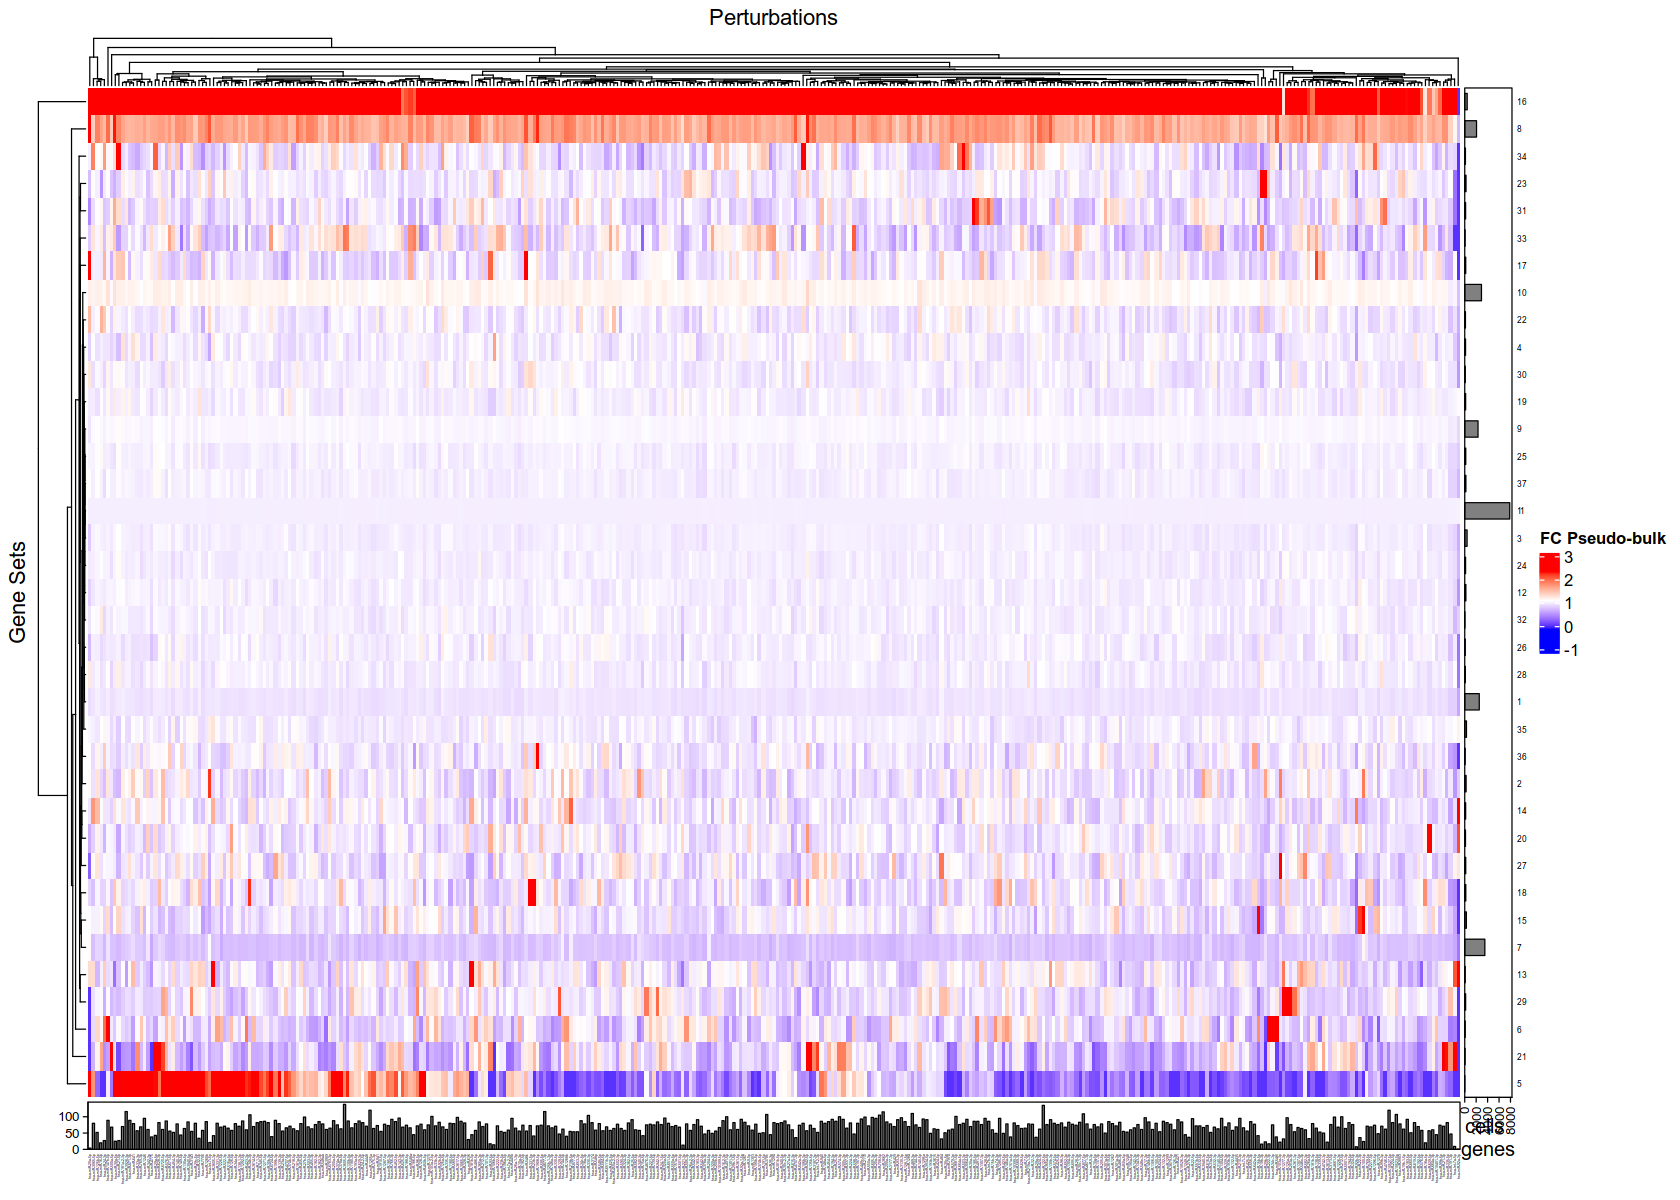

In [30]:
## get genesetexp x guide mtx for customized genesets
custom_genesets11 = split(rownames(PCA_coordinates_final), graph.out11)
custom_genesets = custom_genesets11
genesetexp_x_guide2 = matrix(0, nrow = length(custom_genesets), ncol = ncol(Pseudo_bulk_exp), dimnames = list(names(custom_genesets), colnames(Pseudo_bulk_exp)))

for (j in 1:ncol(Pseudo_bulk_exp)){
    for (i in 1:length(custom_genesets)){
        genes = custom_genesets[[i]][custom_genesets[[i]] %in% rownames(Pseudo_bulk_exp)]
        genesetexp_x_guide2[i,j] = mean(Pseudo_bulk_exp[genes,j])
    }
}

## get genesetexp x guide FC mtx for customized genesets
tmp_df = as.data.frame(genesetexp_x_guide2)
genesetexp_x_guide_FC2 = tmp_df
for (i in 1:ncol(tmp_df)){
    genesetexp_x_guide_FC2[,i] = tmp_df[,i]/tmp_df[,'TuD_NC']
}

genesetexp_x_guide_FC2 = as.matrix(genesetexp_x_guide_FC2)


## heatmap
genesetexp_x_guide_FC2_temp = subset(genesetexp_x_guide_FC2, select = -c(TuD_NC))
avg = mean(genesetexp_x_guide_FC2_temp)
lower_bound = mean(genesetexp_x_guide_FC2_temp) - 2*sd(genesetexp_x_guide_FC2_temp)
upper_bound = mean(genesetexp_x_guide_FC2_temp) + 2*sd(genesetexp_x_guide_FC2_temp)

coloring_map <- circlize::colorRamp2(c(lower_bound, avg, upper_bound), c("blue", "white", "red"))
row_ha = rowAnnotation(genes = anno_barplot(unlist(lapply(custom_genesets, length))))
column_ha = HeatmapAnnotation(cells = anno_barplot(count_df$cells[!count_df$guide == 'TuD_NC']))
perturb_htmp(genesetexp_x_guide_FC2_temp, 'FC Pseudo-bulk', right_annot = row_ha, bottom_annot = column_ha)

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



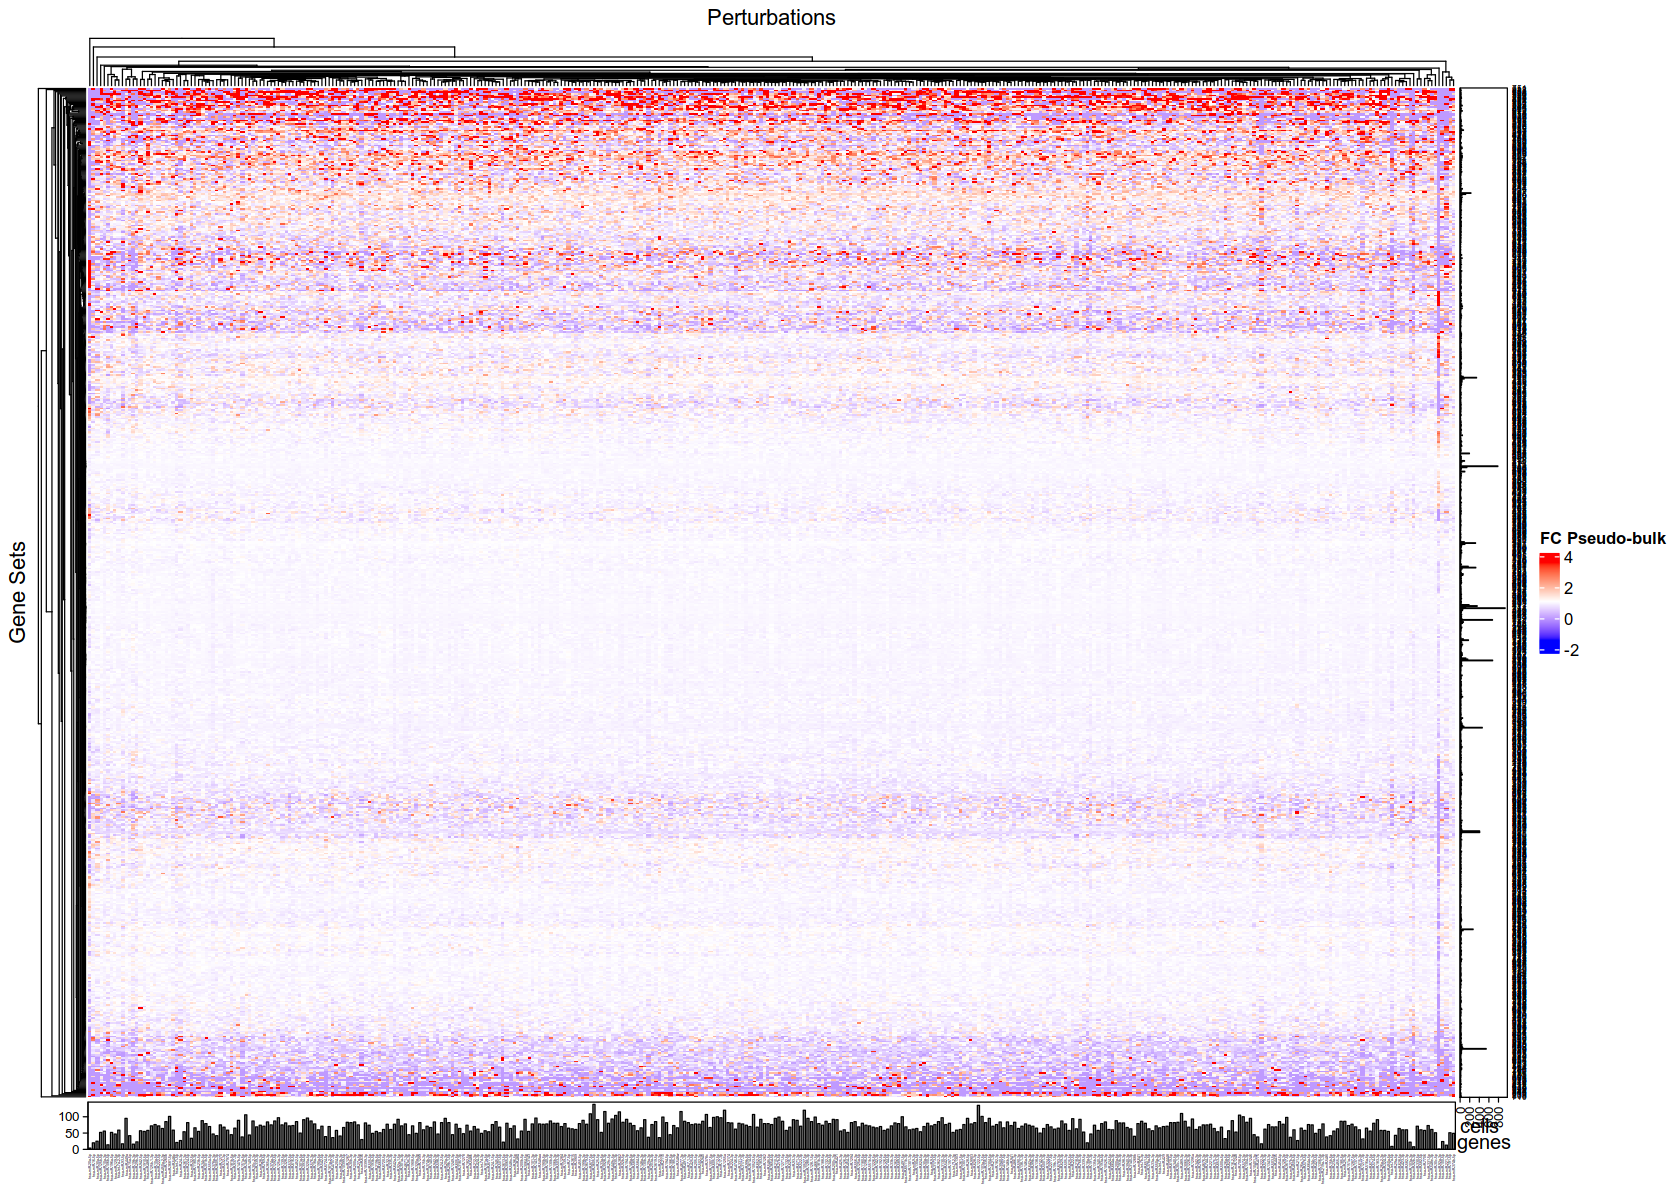

In [31]:

graph.out11 = clusterRows(PCA_coordinates_final, SNNGraphParam(k=5, cluster.fun="leiden", cluster.args=list(resolution=0.1)))
## get genesetexp x guide mtx for customized genesets
custom_genesets11 = split(rownames(PCA_coordinates_final), graph.out11)
custom_genesets = custom_genesets11
genesetexp_x_guide2 = matrix(0, nrow = length(custom_genesets), ncol = ncol(Pseudo_bulk_exp), dimnames = list(names(custom_genesets), colnames(Pseudo_bulk_exp)))

for (j in 1:ncol(Pseudo_bulk_exp)){
    for (i in 1:length(custom_genesets)){
        genes = custom_genesets[[i]][custom_genesets[[i]] %in% rownames(Pseudo_bulk_exp)]
        genesetexp_x_guide2[i,j] = mean(Pseudo_bulk_exp[genes,j])
    }
}

## get genesetexp x guide FC mtx for customized genesets
tmp_df = as.data.frame(genesetexp_x_guide2)
genesetexp_x_guide_FC2 = tmp_df
for (i in 1:ncol(tmp_df)){
    genesetexp_x_guide_FC2[,i] = tmp_df[,i]/tmp_df[,'TuD_NC']
}

genesetexp_x_guide_FC2 = as.matrix(genesetexp_x_guide_FC2)


## heatmap
genesetexp_x_guide_FC2_temp = subset(genesetexp_x_guide_FC2, select = -c(TuD_NC))
avg = mean(genesetexp_x_guide_FC2_temp)
lower_bound = mean(genesetexp_x_guide_FC2_temp) - 2*sd(genesetexp_x_guide_FC2_temp)
upper_bound = mean(genesetexp_x_guide_FC2_temp) + 2*sd(genesetexp_x_guide_FC2_temp)

coloring_map <- circlize::colorRamp2(c(lower_bound, avg, upper_bound), c("blue", "white", "red"))
row_ha = rowAnnotation(genes = anno_barplot(unlist(lapply(custom_genesets, length))))
column_ha = HeatmapAnnotation(cells = anno_barplot(count_df$cells[!count_df$guide == 'TuD_NC']))
perturb_htmp(genesetexp_x_guide_FC2_temp, 'FC Pseudo-bulk', right_annot = row_ha, bottom_annot = column_ha)



In [12]:
custom_genesets0 = split(rownames(PCA_coordinates_final), graph.out0)
custom_genesets1 = split(rownames(PCA_coordinates_final), graph.out1)
custom_genesets2 = split(rownames(PCA_coordinates_final), graph.out2)
custom_genesets3 = split(rownames(PCA_coordinates_final), graph.out3)
custom_genesets4 = split(rownames(PCA_coordinates_final), graph.out4)
custom_genesets5 = split(rownames(PCA_coordinates_final), graph.out5)
custom_genesets6 = split(rownames(PCA_coordinates_final), graph.out6)

In [14]:
names(custom_genesets)

[1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13" "14" "15"
[16] "16" "17" "18" "19" "20" "21" "22" "23" "24" "25" "26" "27" "28" "29" "30"
[31] "31" "32" "33" "34" "35" "36" "37" "38" "39" "40" "41" "42" "43" "44" "45"
[46] "46" "47" "48" "49" "50" "51" "52" "53" "54" "55" "56" "57" "58" "59" "60"
[61] "61" "62" "63" "64" "65" "66" "67" "68" "69" "70" "71" "72" "73" "74" "75"
[76] "76" "77" "78" "79" "80" "81" "82" "83" "84" "85"

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



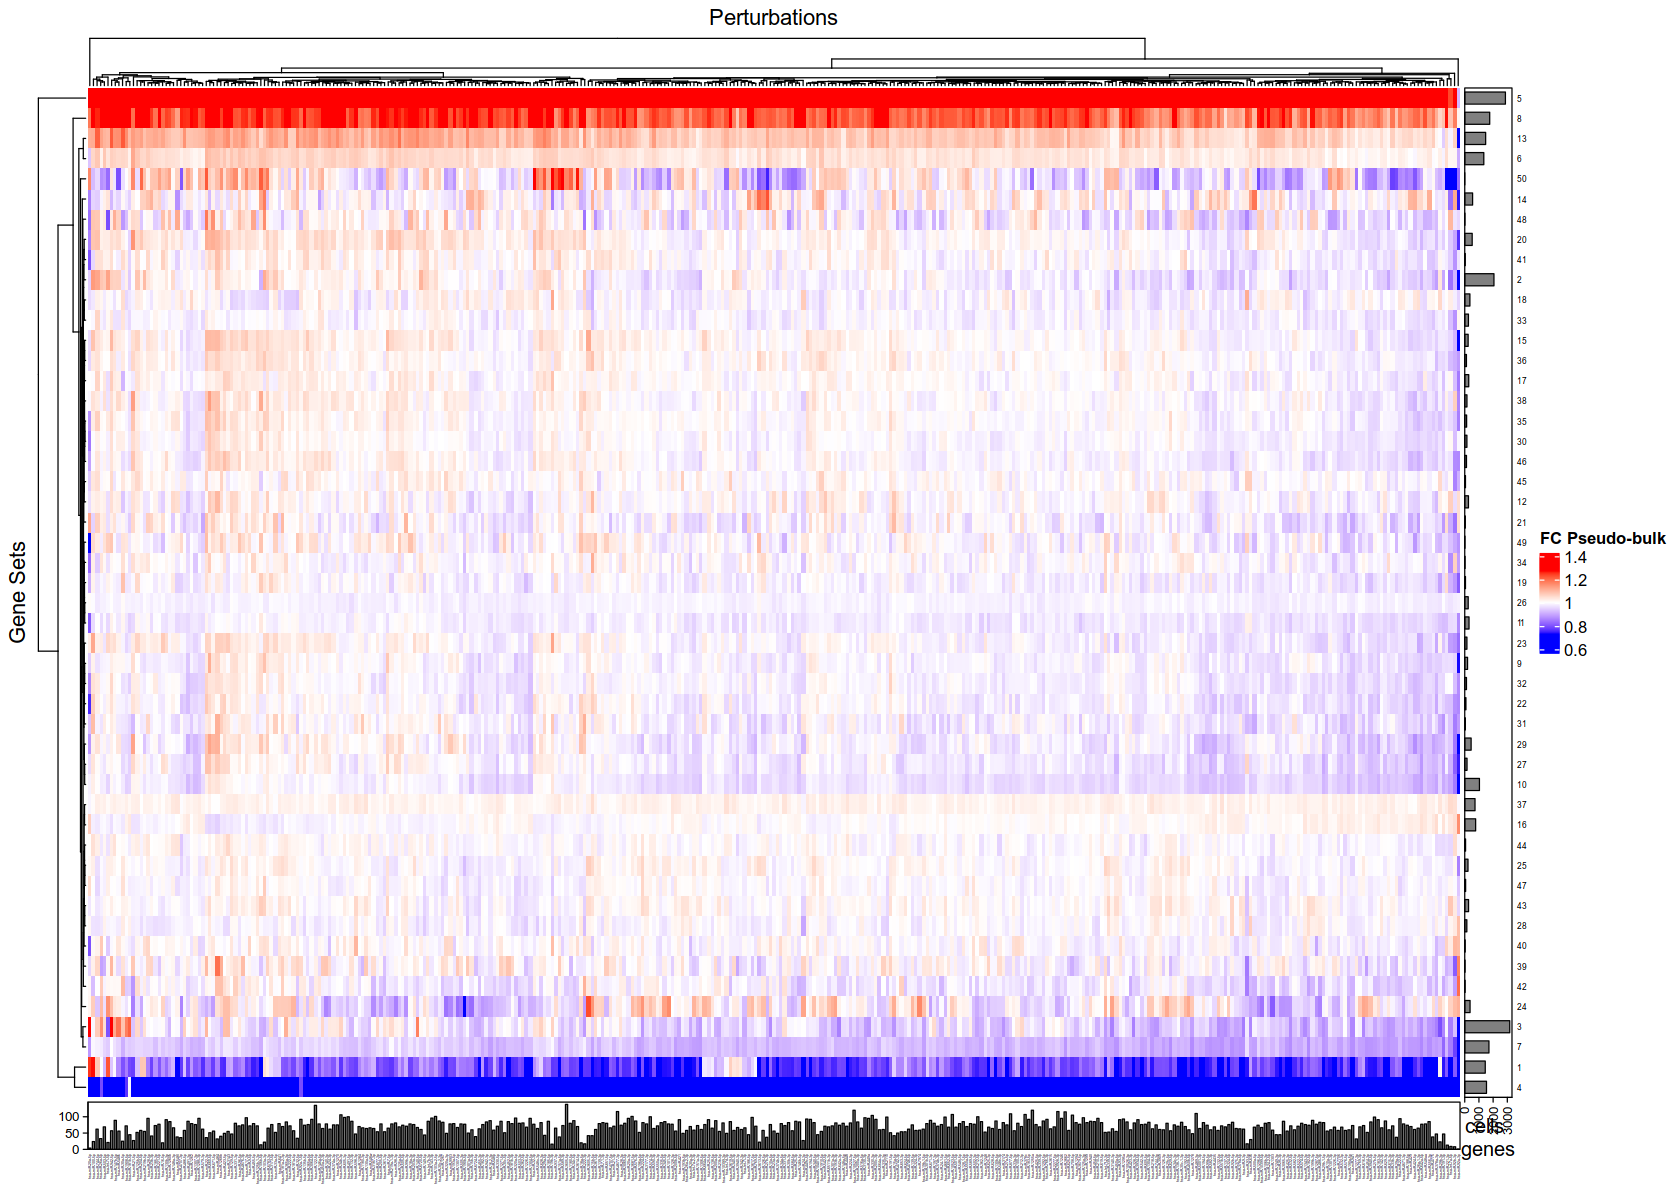

In [19]:
## get genesetexp x guide mtx for customized genesets
custom_genesets = custom_genesets0
genesetexp_x_guide2 = matrix(0, nrow = length(custom_genesets), ncol = ncol(Pseudo_bulk_exp), dimnames = list(names(custom_genesets), colnames(Pseudo_bulk_exp)))

for (j in 1:ncol(Pseudo_bulk_exp)){
    for (i in 1:length(custom_genesets)){
        genes = custom_genesets[[i]][custom_genesets[[i]] %in% rownames(Pseudo_bulk_exp)]
        genesetexp_x_guide2[i,j] = mean(Pseudo_bulk_exp[genes,j])
    }
}

## get genesetexp x guide FC mtx for customized genesets
tmp_df = as.data.frame(genesetexp_x_guide2)
genesetexp_x_guide_FC2 = tmp_df
for (i in 1:ncol(tmp_df)){
    genesetexp_x_guide_FC2[,i] = tmp_df[,i]/tmp_df[,'TuD_NC']
}

genesetexp_x_guide_FC2 = as.matrix(genesetexp_x_guide_FC2)


## heatmap
genesetexp_x_guide_FC2_temp = subset(genesetexp_x_guide_FC2, select = -c(TuD_NC))
avg = mean(genesetexp_x_guide_FC2_temp)
lower_bound = mean(genesetexp_x_guide_FC2_temp) - 2*sd(genesetexp_x_guide_FC2_temp)
upper_bound = mean(genesetexp_x_guide_FC2_temp) + 2*sd(genesetexp_x_guide_FC2_temp)

coloring_map <- circlize::colorRamp2(c(lower_bound, avg, upper_bound), c("blue", "white", "red"))
row_ha = rowAnnotation(genes = anno_barplot(unlist(lapply(custom_genesets, length))))
column_ha = HeatmapAnnotation(cells = anno_barplot(count_df$cells[!count_df$guide == 'TuD_NC']))
perturb_htmp(genesetexp_x_guide_FC2_temp, 'FC Pseudo-bulk', right_annot = row_ha, bottom_annot = column_ha)

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



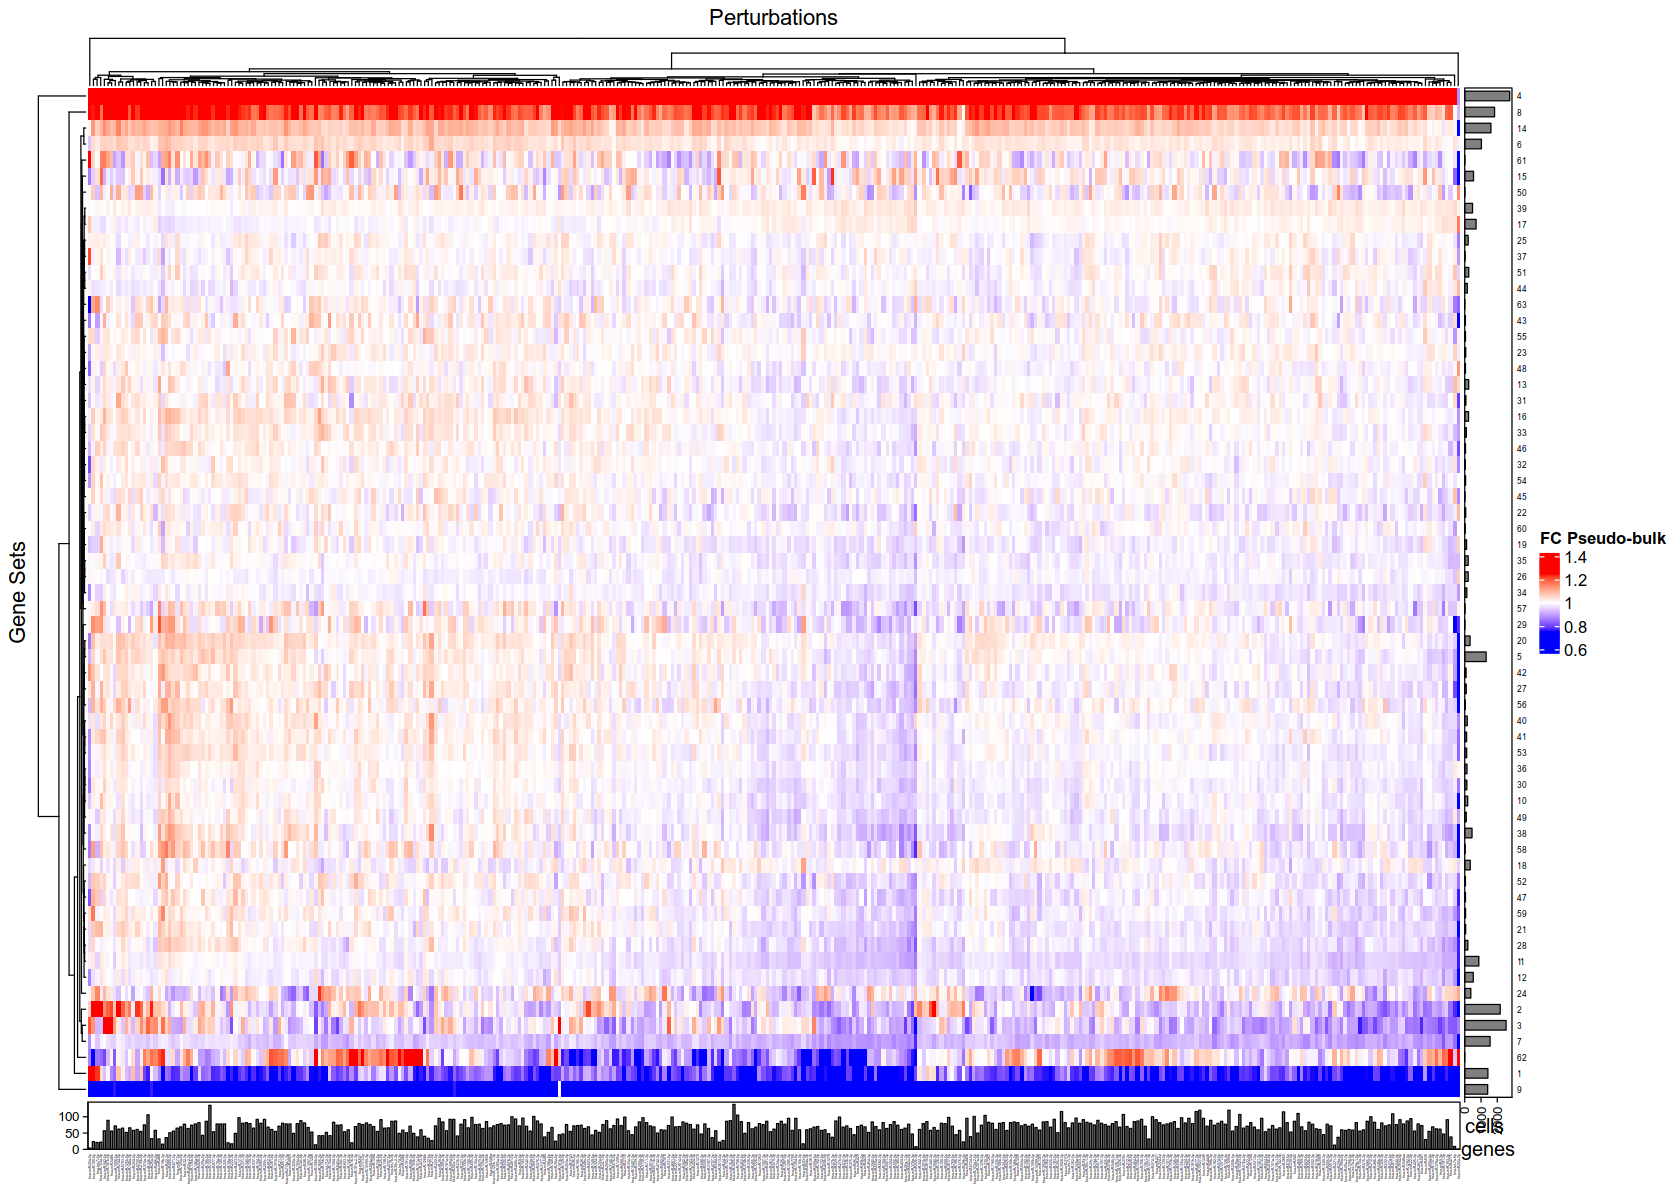

In [20]:
## get genesetexp x guide mtx for customized genesets
custom_genesets = custom_genesets1
genesetexp_x_guide2 = matrix(0, nrow = length(custom_genesets), ncol = ncol(Pseudo_bulk_exp), dimnames = list(names(custom_genesets), colnames(Pseudo_bulk_exp)))

for (j in 1:ncol(Pseudo_bulk_exp)){
    for (i in 1:length(custom_genesets)){
        genes = custom_genesets[[i]][custom_genesets[[i]] %in% rownames(Pseudo_bulk_exp)]
        genesetexp_x_guide2[i,j] = mean(Pseudo_bulk_exp[genes,j])
    }
}

## get genesetexp x guide FC mtx for customized genesets
tmp_df = as.data.frame(genesetexp_x_guide2)
genesetexp_x_guide_FC2 = tmp_df
for (i in 1:ncol(tmp_df)){
    genesetexp_x_guide_FC2[,i] = tmp_df[,i]/tmp_df[,'TuD_NC']
}

genesetexp_x_guide_FC2 = as.matrix(genesetexp_x_guide_FC2)


## heatmap
genesetexp_x_guide_FC2_temp = subset(genesetexp_x_guide_FC2, select = -c(TuD_NC))
avg = mean(genesetexp_x_guide_FC2_temp)
lower_bound = mean(genesetexp_x_guide_FC2_temp) - 2*sd(genesetexp_x_guide_FC2_temp)
upper_bound = mean(genesetexp_x_guide_FC2_temp) + 2*sd(genesetexp_x_guide_FC2_temp)

coloring_map <- circlize::colorRamp2(c(lower_bound, avg, upper_bound), c("blue", "white", "red"))
row_ha = rowAnnotation(genes = anno_barplot(unlist(lapply(custom_genesets, length))))
column_ha = HeatmapAnnotation(cells = anno_barplot(count_df$cells[!count_df$guide == 'TuD_NC']))
perturb_htmp(genesetexp_x_guide_FC2_temp, 'FC Pseudo-bulk', right_annot = row_ha, bottom_annot = column_ha)

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



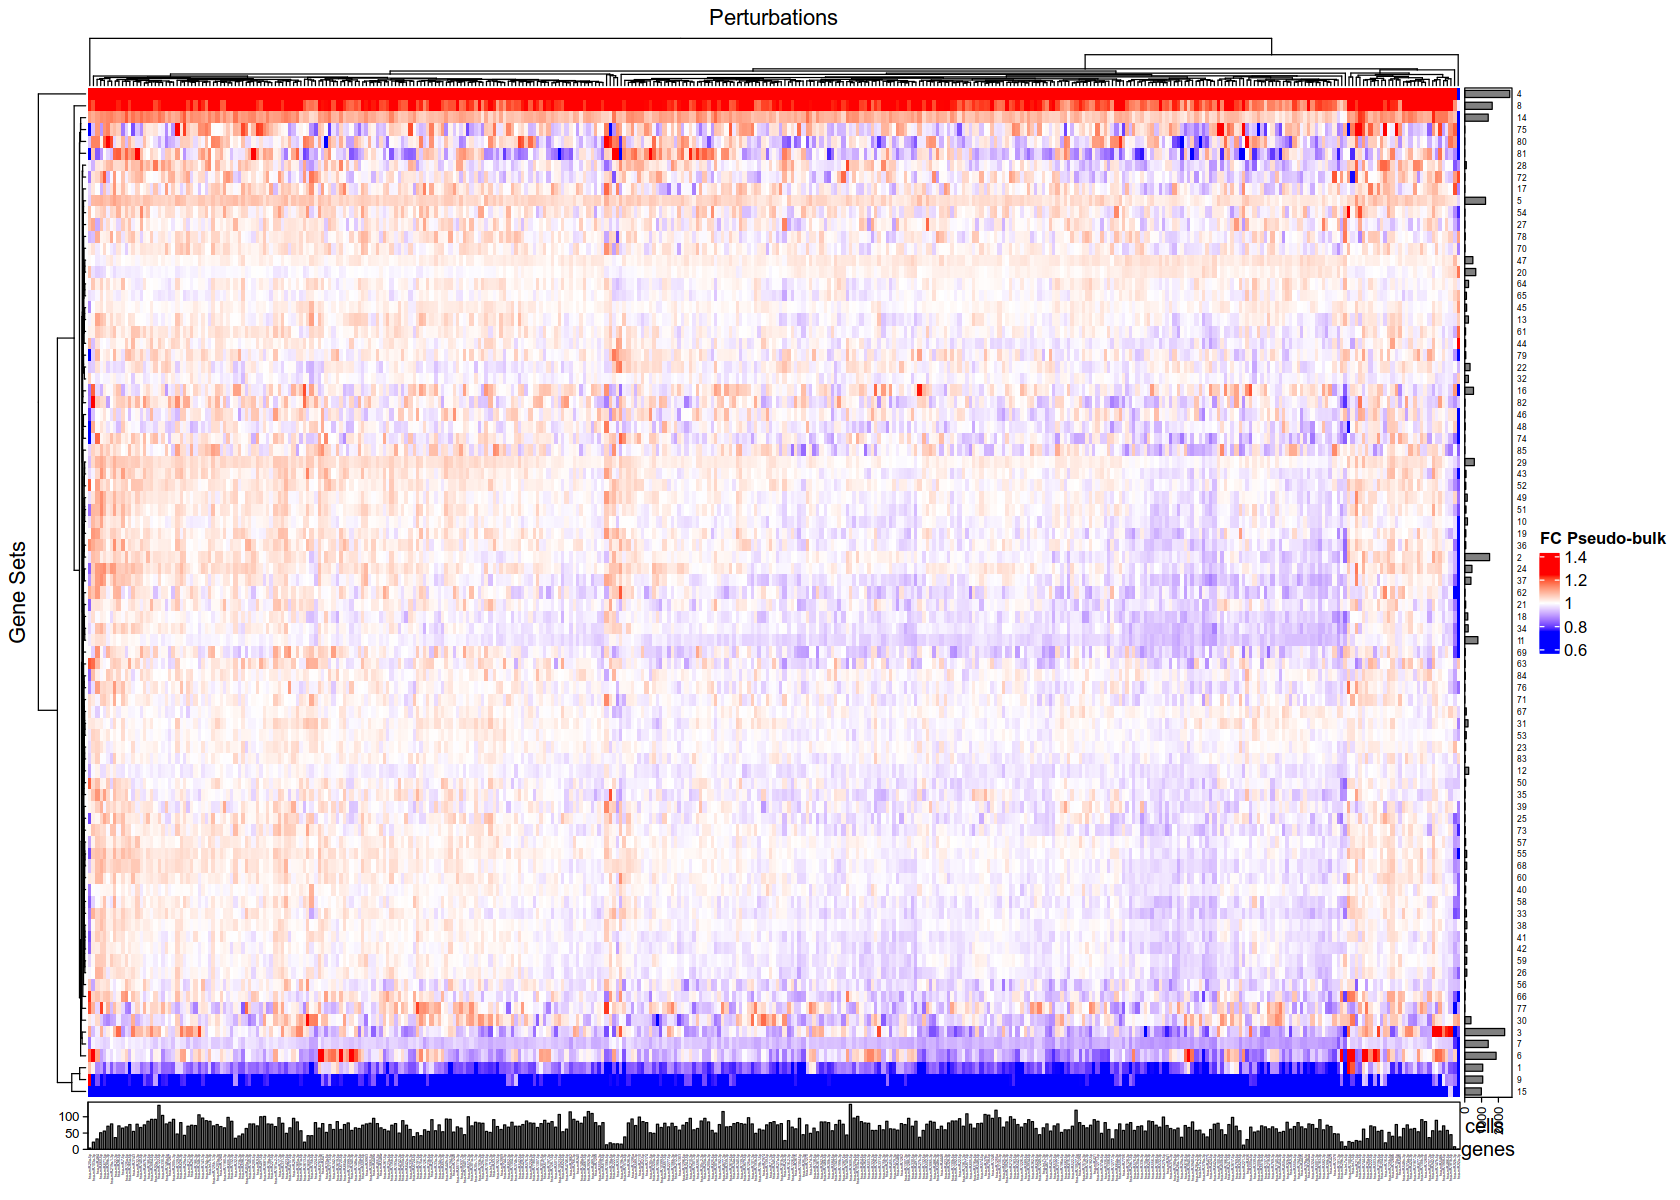

In [15]:
## get genesetexp x guide mtx for customized genesets
custom_genesets = custom_genesets2
genesetexp_x_guide2 = matrix(0, nrow = length(custom_genesets), ncol = ncol(Pseudo_bulk_exp), dimnames = list(names(custom_genesets), colnames(Pseudo_bulk_exp)))

for (j in 1:ncol(Pseudo_bulk_exp)){
    for (i in 1:length(custom_genesets)){
        genes = custom_genesets[[i]][custom_genesets[[i]] %in% rownames(Pseudo_bulk_exp)]
        genesetexp_x_guide2[i,j] = mean(Pseudo_bulk_exp[genes,j])
    }
}

## get genesetexp x guide FC mtx for customized genesets
tmp_df = as.data.frame(genesetexp_x_guide2)
genesetexp_x_guide_FC2 = tmp_df
for (i in 1:ncol(tmp_df)){
    genesetexp_x_guide_FC2[,i] = tmp_df[,i]/tmp_df[,'TuD_NC']
}

genesetexp_x_guide_FC2 = as.matrix(genesetexp_x_guide_FC2)


## heatmap
genesetexp_x_guide_FC2_temp = subset(genesetexp_x_guide_FC2, select = -c(TuD_NC))
avg = mean(genesetexp_x_guide_FC2_temp)
lower_bound = mean(genesetexp_x_guide_FC2_temp) - 2*sd(genesetexp_x_guide_FC2_temp)
upper_bound = mean(genesetexp_x_guide_FC2_temp) + 2*sd(genesetexp_x_guide_FC2_temp)

coloring_map <- circlize::colorRamp2(c(lower_bound, avg, upper_bound), c("blue", "white", "red"))
row_ha = rowAnnotation(genes = anno_barplot(unlist(lapply(custom_genesets, length))))
column_ha = HeatmapAnnotation(cells = anno_barplot(count_df$cells[!count_df$guide == 'TuD_NC']))
perturb_htmp(genesetexp_x_guide_FC2_temp, 'FC Pseudo-bulk', right_annot = row_ha, bottom_annot = column_ha)

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



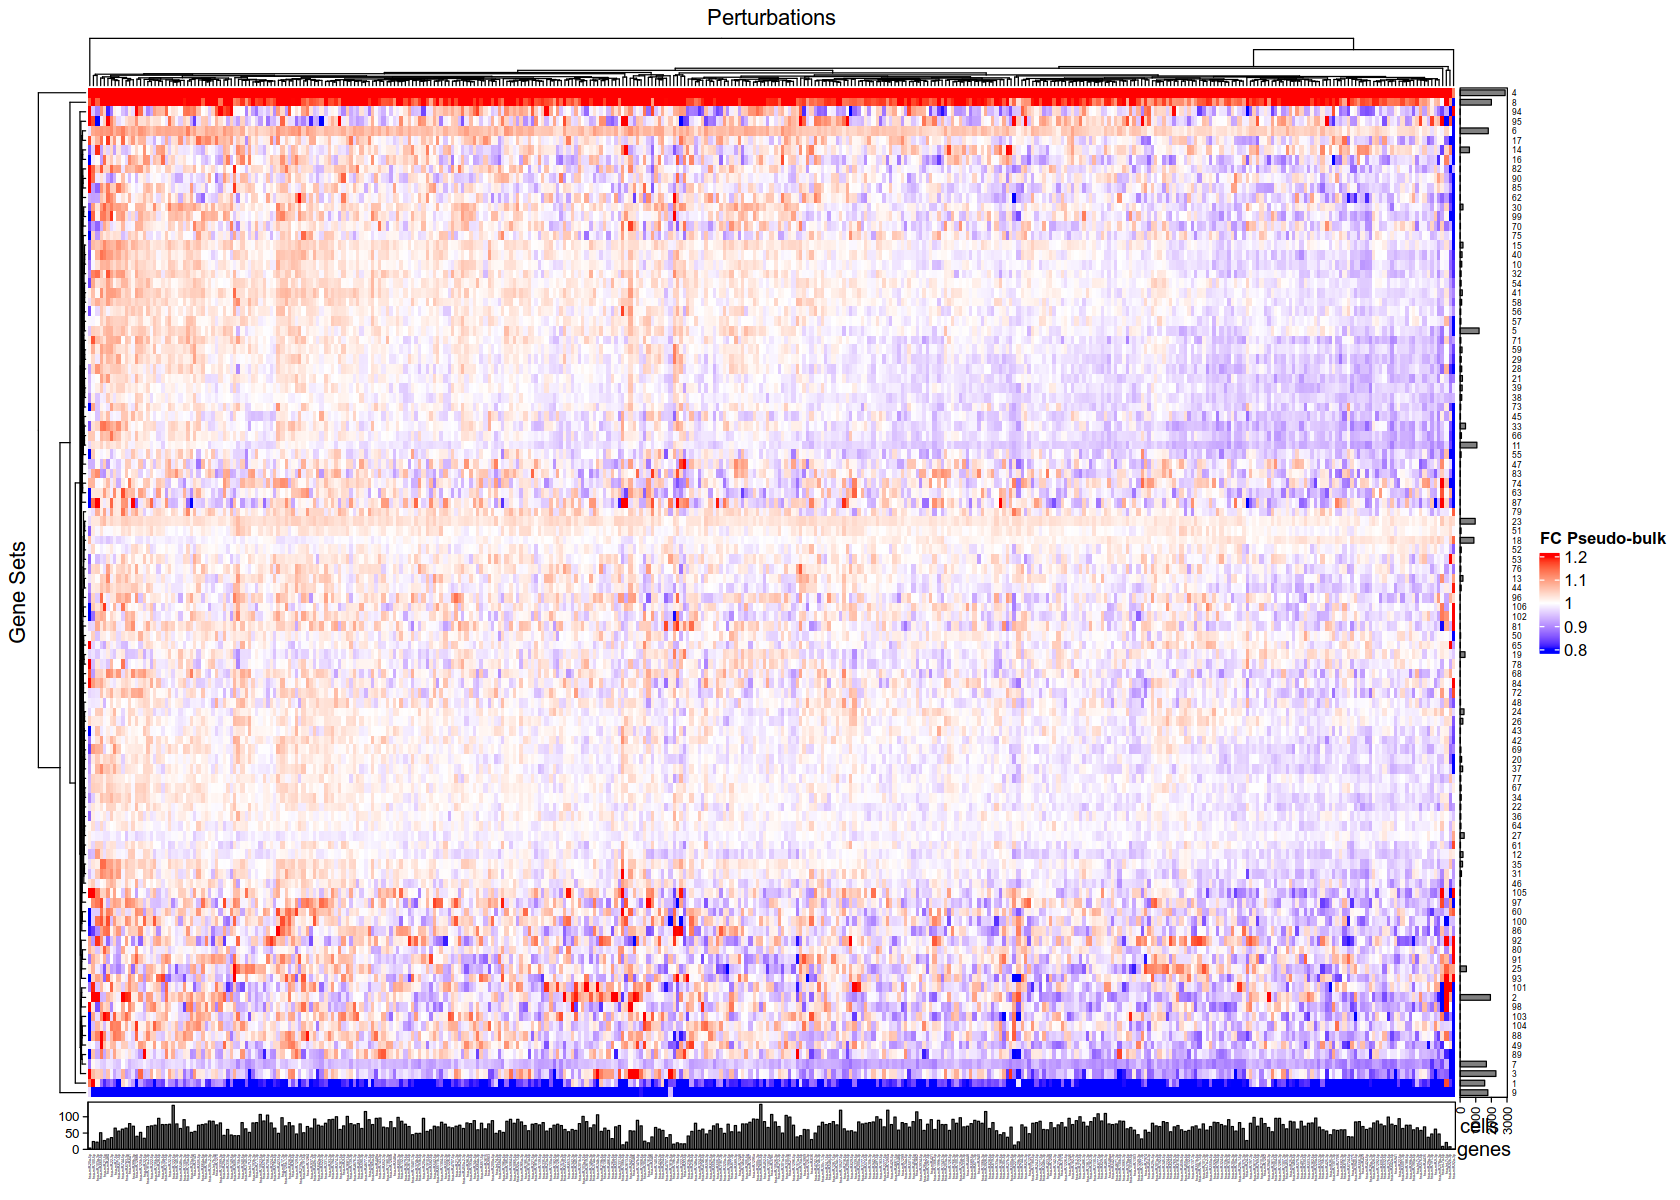

In [16]:
## get genesetexp x guide mtx for customized genesets
custom_genesets = custom_genesets3
genesetexp_x_guide2 = matrix(0, nrow = length(custom_genesets), ncol = ncol(Pseudo_bulk_exp), dimnames = list(names(custom_genesets), colnames(Pseudo_bulk_exp)))

for (j in 1:ncol(Pseudo_bulk_exp)){
    for (i in 1:length(custom_genesets)){
        genes = custom_genesets[[i]][custom_genesets[[i]] %in% rownames(Pseudo_bulk_exp)]
        genesetexp_x_guide2[i,j] = mean(Pseudo_bulk_exp[genes,j])
    }
}

## get genesetexp x guide FC mtx for customized genesets
tmp_df = as.data.frame(genesetexp_x_guide2)
genesetexp_x_guide_FC2 = tmp_df
for (i in 1:ncol(tmp_df)){
    genesetexp_x_guide_FC2[,i] = tmp_df[,i]/tmp_df[,'TuD_NC']
}

genesetexp_x_guide_FC2 = as.matrix(genesetexp_x_guide_FC2)

## heatmap
genesetexp_x_guide_FC2_temp = subset(genesetexp_x_guide_FC2, select = -c(TuD_NC))
avg = mean(genesetexp_x_guide_FC2_temp)
lower_bound = mean(genesetexp_x_guide_FC2_temp) - 2*sd(genesetexp_x_guide_FC2_temp)
upper_bound = mean(genesetexp_x_guide_FC2_temp) + 2*sd(genesetexp_x_guide_FC2_temp)

coloring_map <- circlize::colorRamp2(c(lower_bound, avg, upper_bound), c("blue", "white", "red"))
row_ha = rowAnnotation(genes = anno_barplot(unlist(lapply(custom_genesets, length))))
column_ha = HeatmapAnnotation(cells = anno_barplot(count_df$cells[!count_df$guide == 'TuD_NC']))
perturb_htmp(genesetexp_x_guide_FC2_temp, 'FC Pseudo-bulk', right_annot = row_ha, bottom_annot = column_ha)

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



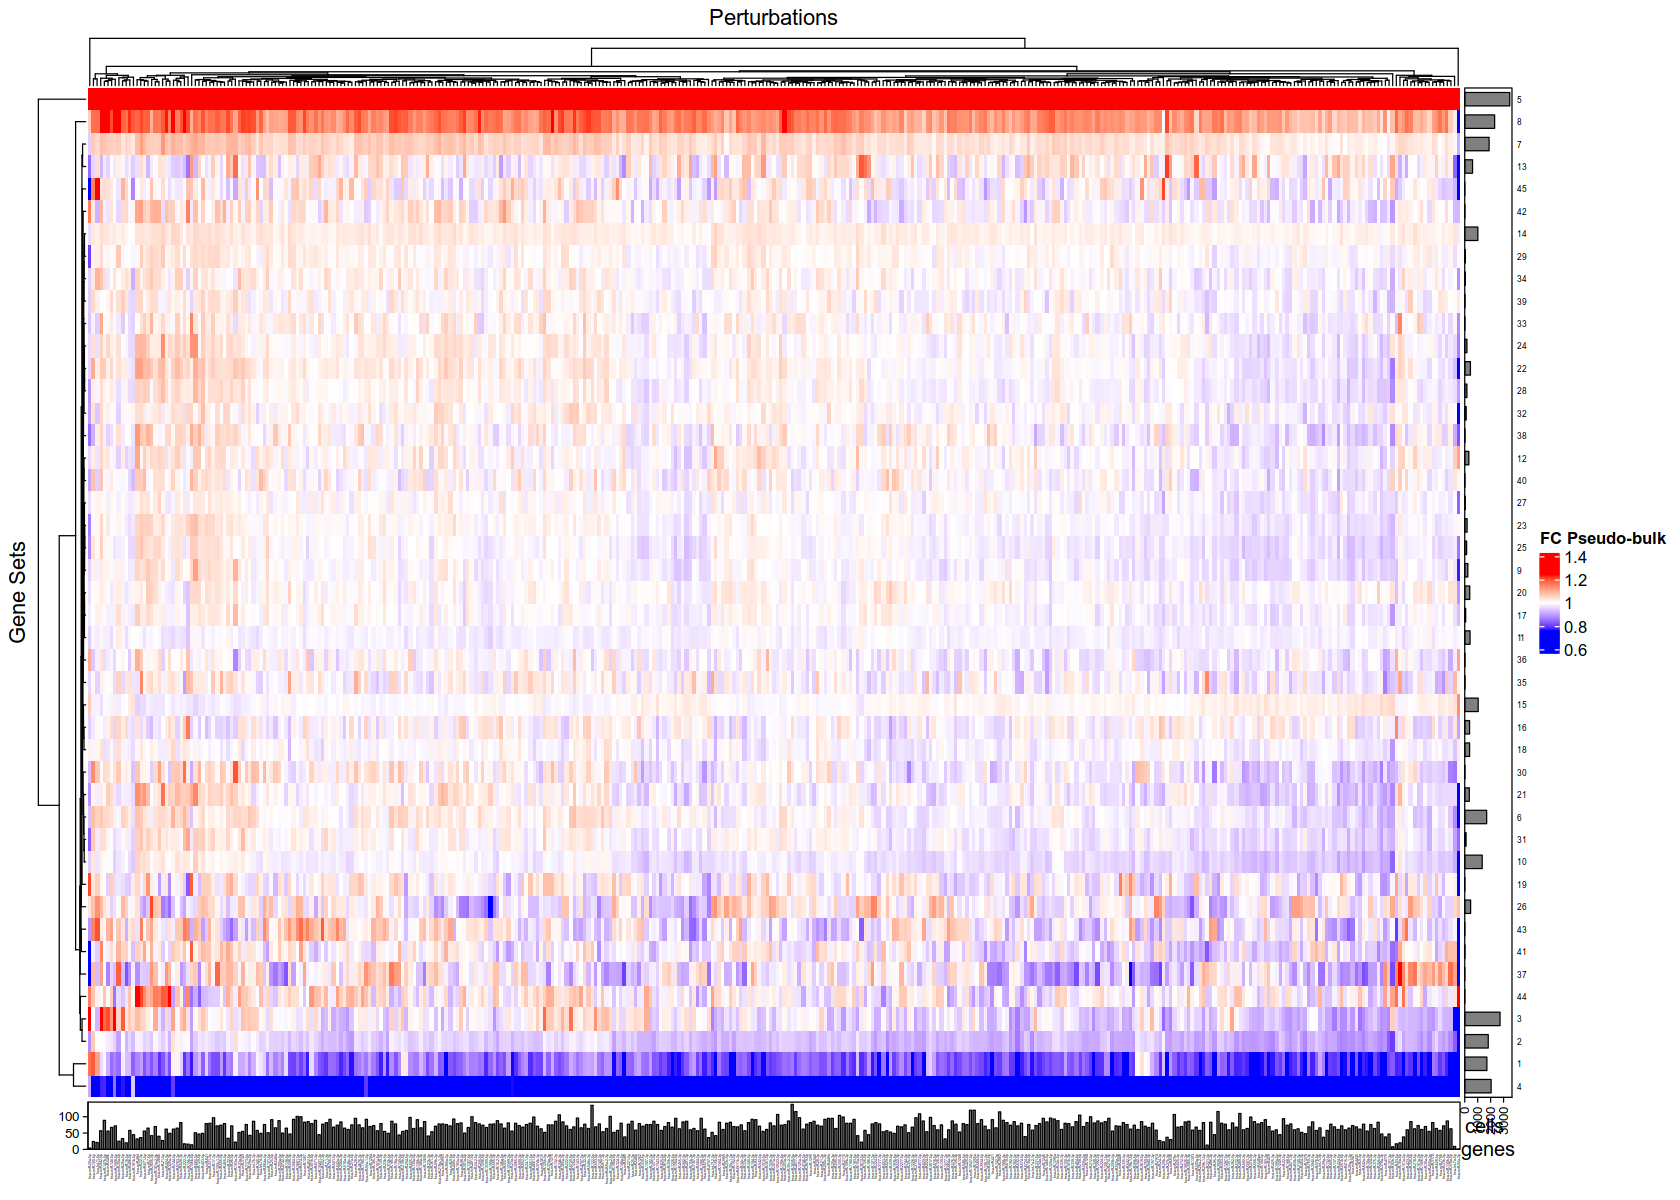

In [18]:
## get genesetexp x guide mtx for customized genesets
custom_genesets = custom_genesets4
genesetexp_x_guide2 = matrix(0, nrow = length(custom_genesets), ncol = ncol(Pseudo_bulk_exp), dimnames = list(names(custom_genesets), colnames(Pseudo_bulk_exp)))

for (j in 1:ncol(Pseudo_bulk_exp)){
    for (i in 1:length(custom_genesets)){
        genes = custom_genesets[[i]][custom_genesets[[i]] %in% rownames(Pseudo_bulk_exp)]
        genesetexp_x_guide2[i,j] = mean(Pseudo_bulk_exp[genes,j])
    }
}

## get genesetexp x guide FC mtx for customized genesets
tmp_df = as.data.frame(genesetexp_x_guide2)
genesetexp_x_guide_FC2 = tmp_df
for (i in 1:ncol(tmp_df)){
    genesetexp_x_guide_FC2[,i] = tmp_df[,i]/tmp_df[,'TuD_NC']
}

genesetexp_x_guide_FC2 = as.matrix(genesetexp_x_guide_FC2)

## heatmap
genesetexp_x_guide_FC2_temp = subset(genesetexp_x_guide_FC2, select = -c(TuD_NC))
avg = mean(genesetexp_x_guide_FC2_temp)
lower_bound = mean(genesetexp_x_guide_FC2_temp) - 2*sd(genesetexp_x_guide_FC2_temp)
upper_bound = mean(genesetexp_x_guide_FC2_temp) + 2*sd(genesetexp_x_guide_FC2_temp)

coloring_map <- circlize::colorRamp2(c(lower_bound, avg, upper_bound), c("blue", "white", "red"))
row_ha = rowAnnotation(genes = anno_barplot(unlist(lapply(custom_genesets, length))))
column_ha = HeatmapAnnotation(cells = anno_barplot(count_df$cells[!count_df$guide == 'TuD_NC']))
perturb_htmp(genesetexp_x_guide_FC2_temp, 'FC Pseudo-bulk', right_annot = row_ha, bottom_annot = column_ha)

In [45]:
library(bluster)

In [46]:
## default arguments k = 10, resolution = 4.5
graph.out = clusterRows(PCA_coordinates_final, SNNGraphParam(k=15, cluster.fun="louvain", cluster.args=list(resolution=5)))

In [47]:
table(graph.out)

graph.out
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
1463 2066 3309 1555 2975  944 1768 1934  194 1009  405  268 1792  569  318  738 
  17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32 
 344  118  244  123   63  275  383  236  296   23  443  141    9  289  154  213 
  33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48 
 118  453   10  152  135   22  114   81   33   51  118   98   10  124   40   44 
  49   50   51 
   4   21    3 

In [48]:
custom_genesets = split(rownames(PCA_coordinates_final), graph.out)

In [49]:
library(enrichR)
setEnrichrSite("Enrichr")

Welcome to enrichR
Checking connection ... 

Enrichr ... 
Connection is Live!

FlyEnrichr ... 
Connection is available!

WormEnrichr ... 
Connection is available!

YeastEnrichr ... 
Connection is available!

FishEnrichr ... 
Connection is available!

OxEnrichr ... 
Connection is available!

Connection changed to https://maayanlab.cloud/Enrichr/

Connection is Live!



In [50]:
dbs <- c("GO_Molecular_Function_2021", "GO_Cellular_Component_2021", "GO_Biological_Process_2021")
dbs <- c("GO_Biological_Process_2021")
enriched <- enrichr(custom_genesets[[5]], dbs)

Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


In [51]:
enriched_list = lapply(custom_genesets, enrichr, dbs)
enriched_list = lapply(enriched_list, '[[', 1)

Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  

In [52]:
pathway_names <- vector()
for (i in 1:length(enriched_list)){
    filtered_0.05 = enriched_list[[i]]$P.value < 0.05
    max = which.max(sapply(enriched_list[[i]]$Overlap, function(x) eval(parse(text=x)))[filtered_0.05])
    pathway_names[i] <- enriched_list[[i]]$Term[filtered_0.05][max]
}

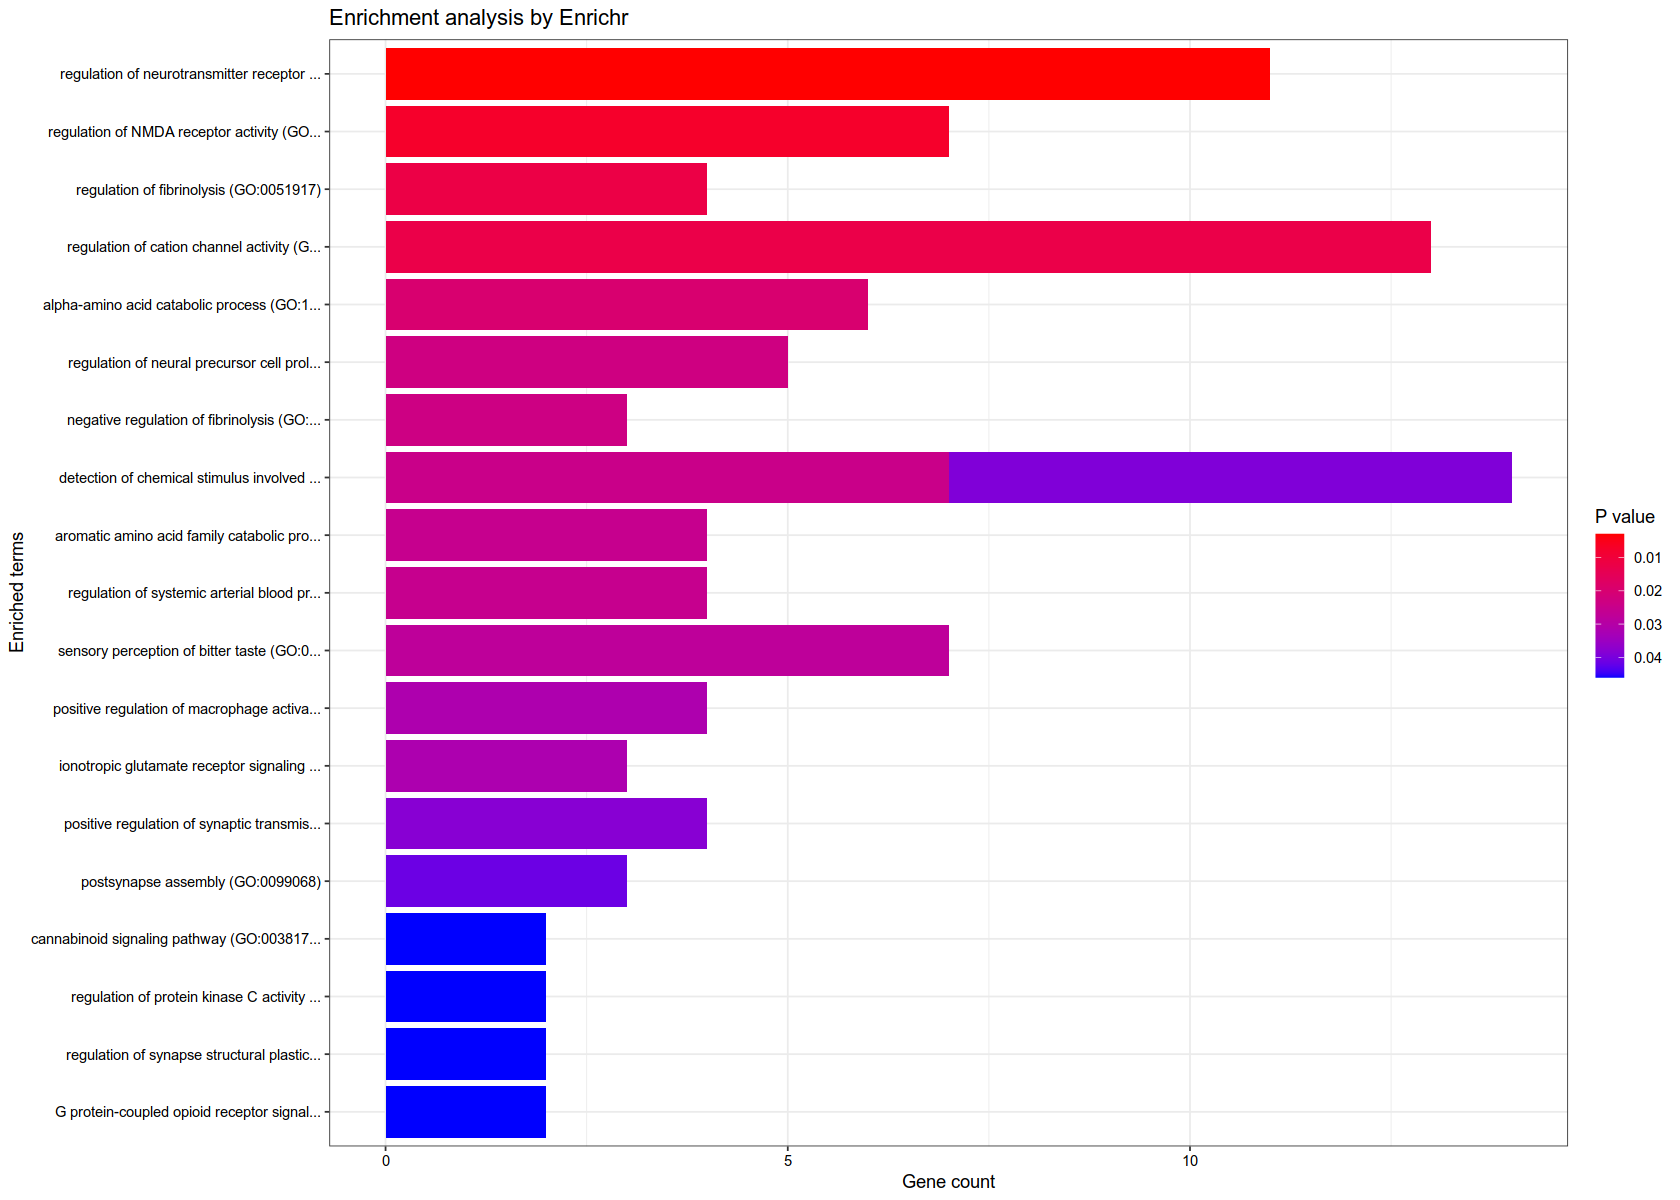

In [53]:
plotEnrich(enriched_list[[1]], showTerms = 20, numChar = 40, y = "Count", orderBy = "P.value")

In [54]:
pathway_names = make.unique(pathway_names)

In [55]:
## get genesetexp x guide mtx for customized genesets
genesetexp_x_guide2 = matrix(0, nrow = length(custom_genesets), ncol = ncol(Pseudo_bulk_exp), dimnames = list(names(custom_genesets), colnames(Pseudo_bulk_exp)))

for (j in 1:ncol(Pseudo_bulk_exp)){
    for (i in 1:length(custom_genesets)){
        genes = custom_genesets[[i]][custom_genesets[[i]] %in% rownames(Pseudo_bulk_exp)]
        genesetexp_x_guide2[i,j] = mean(Pseudo_bulk_exp[genes,j])
    }
}

In [56]:
## get genesetexp x guide FC mtx for customized genesets
tmp_df = as.data.frame(genesetexp_x_guide2)
genesetexp_x_guide_FC2 = tmp_df
for (i in 1:ncol(tmp_df)){
    genesetexp_x_guide_FC2[,i] = tmp_df[,i]/tmp_df[,'TuD_NC']
}

genesetexp_x_guide_FC2 = as.matrix(genesetexp_x_guide_FC2)
rownames(genesetexp_x_guide_FC2) = pathway_names

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



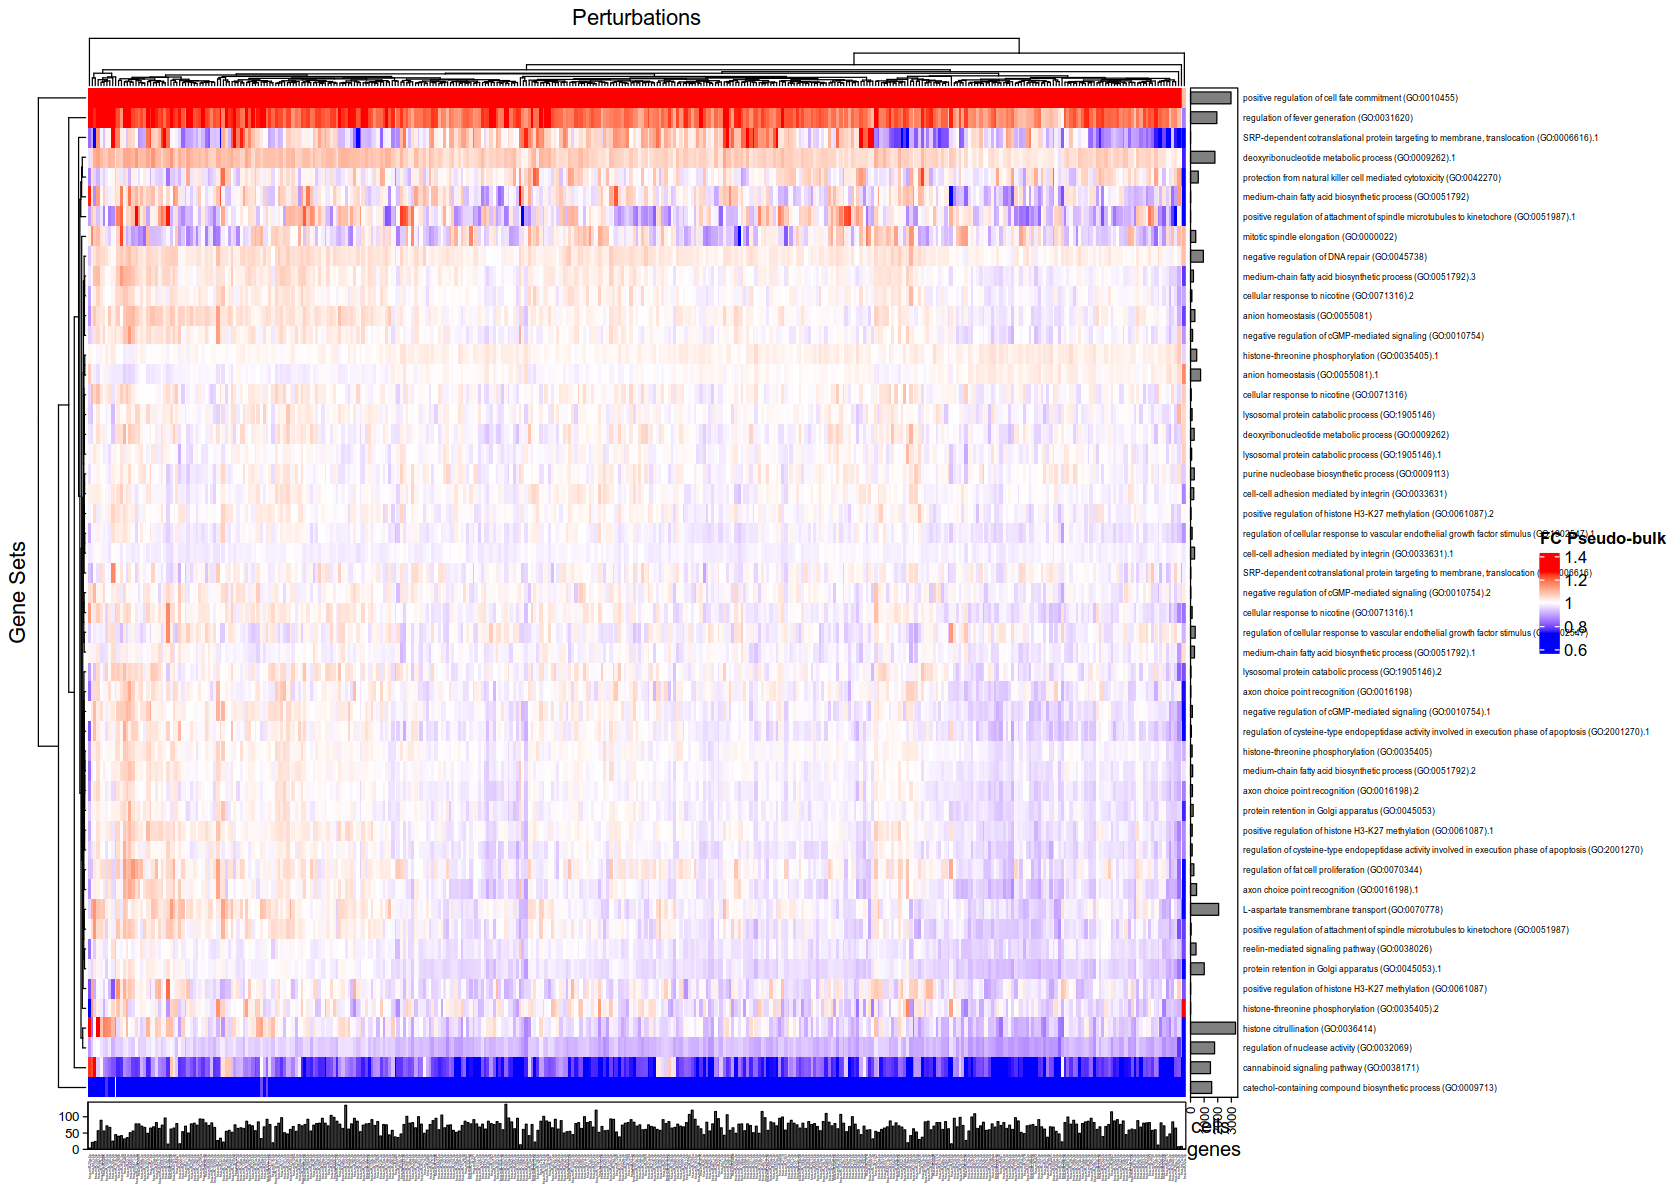

In [57]:
## heatmap
genesetexp_x_guide_FC2_temp = subset(genesetexp_x_guide_FC2, select = -c(TuD_NC))
avg = mean(genesetexp_x_guide_FC2_temp)
lower_bound = mean(genesetexp_x_guide_FC2_temp) - 2*sd(genesetexp_x_guide_FC2_temp)
upper_bound = mean(genesetexp_x_guide_FC2_temp) + 2*sd(genesetexp_x_guide_FC2_temp)

coloring_map <- circlize::colorRamp2(c(lower_bound, avg, upper_bound), c("blue", "white", "red"))
row_ha = rowAnnotation(genes = anno_barplot(unlist(lapply(custom_genesets, length))))
column_ha = HeatmapAnnotation(cells = anno_barplot(count_df$cells[!count_df$guide == 'TuD_NC']))
perturb_htmp(genesetexp_x_guide_FC2_temp, 'FC Pseudo-bulk', right_annot = row_ha, bottom_annot = column_ha)

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



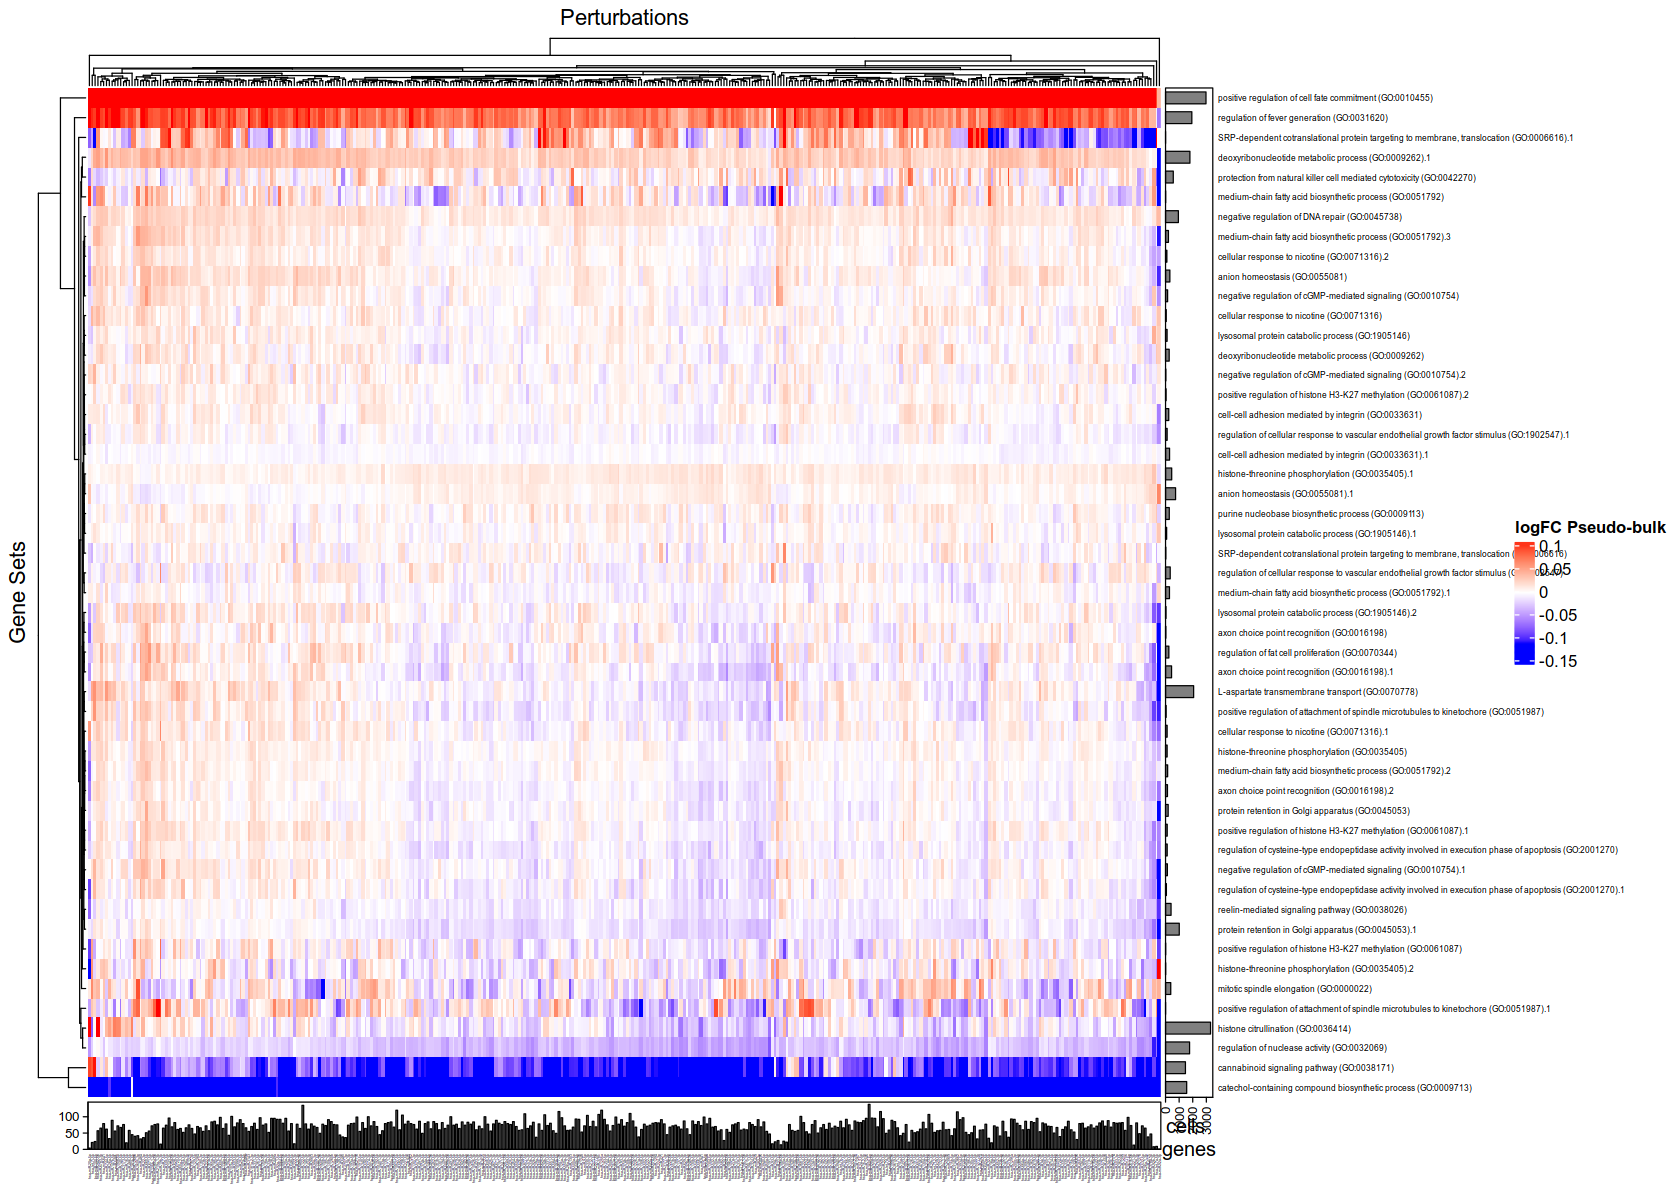

In [58]:
## change to logFC (and run rowsums on absolute valeus)
genesetexp_x_guide_logFC2_temp = log10(genesetexp_x_guide_FC2_temp)
genesetexp_x_guide_logFC2_temp[is.infinite(genesetexp_x_guide_logFC2_temp)] = 0

avg_log = mean(genesetexp_x_guide_logFC2_temp)
lower_bound_log = mean(genesetexp_x_guide_logFC2_temp) - 2*sd(genesetexp_x_guide_logFC2_temp)
upper_bound_log = mean(genesetexp_x_guide_logFC2_temp) + 2*sd(genesetexp_x_guide_logFC2_temp)

coloring_map <- circlize::colorRamp2(c(lower_bound_log, avg_log, upper_bound_log), c("blue", "white", "red"))
row_ha = rowAnnotation(genes = anno_barplot(unlist(lapply(custom_genesets, length))))
column_ha = HeatmapAnnotation(cells = anno_barplot(count_df$cells[!count_df$guide == 'TuD_NC']))
perturb_htmp(genesetexp_x_guide_logFC2_temp, 'logFC Pseudo-bulk', right_annot = row_ha, bottom_annot = column_ha)

In [59]:
identical(colnames(genesetexp_x_guide_FC2), count_df$guide)

[1] TRUE

In [60]:
## prep random label custom geneset heatmap

genesetexp_x_randomized_guide2 = matrix(0, nrow = length(custom_genesets), ncol = ncol(Pseudo_bulk_exp_randomized), dimnames = list(names(custom_genesets), colnames(Pseudo_bulk_exp_randomized)))

for (j in 1:ncol(Pseudo_bulk_exp_randomized)){
    for (i in 1:length(custom_genesets)){
        genes = custom_genesets[[i]][custom_genesets[[i]] %in% rownames(Pseudo_bulk_exp_randomized)]
        genesetexp_x_randomized_guide2[i,j] = mean(Pseudo_bulk_exp_randomized[genes,j])
    }
}

tmp_df = as.data.frame(genesetexp_x_randomized_guide2)
genesetexp_x_randomized_guide_FC2 = tmp_df
for (i in 1:ncol(tmp_df)){
    genesetexp_x_randomized_guide_FC2[,i] = tmp_df[,i]/tmp_df[,'TuD_NC']
}

genesetexp_x_randomized_guide_FC2 = as.matrix(genesetexp_x_randomized_guide_FC2)

rownames(genesetexp_x_randomized_guide_FC2) = pathway_names
genesetexp_x_randomized_guide_FC2_temp = subset(genesetexp_x_randomized_guide_FC2, select = -c(TuD_NC))

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



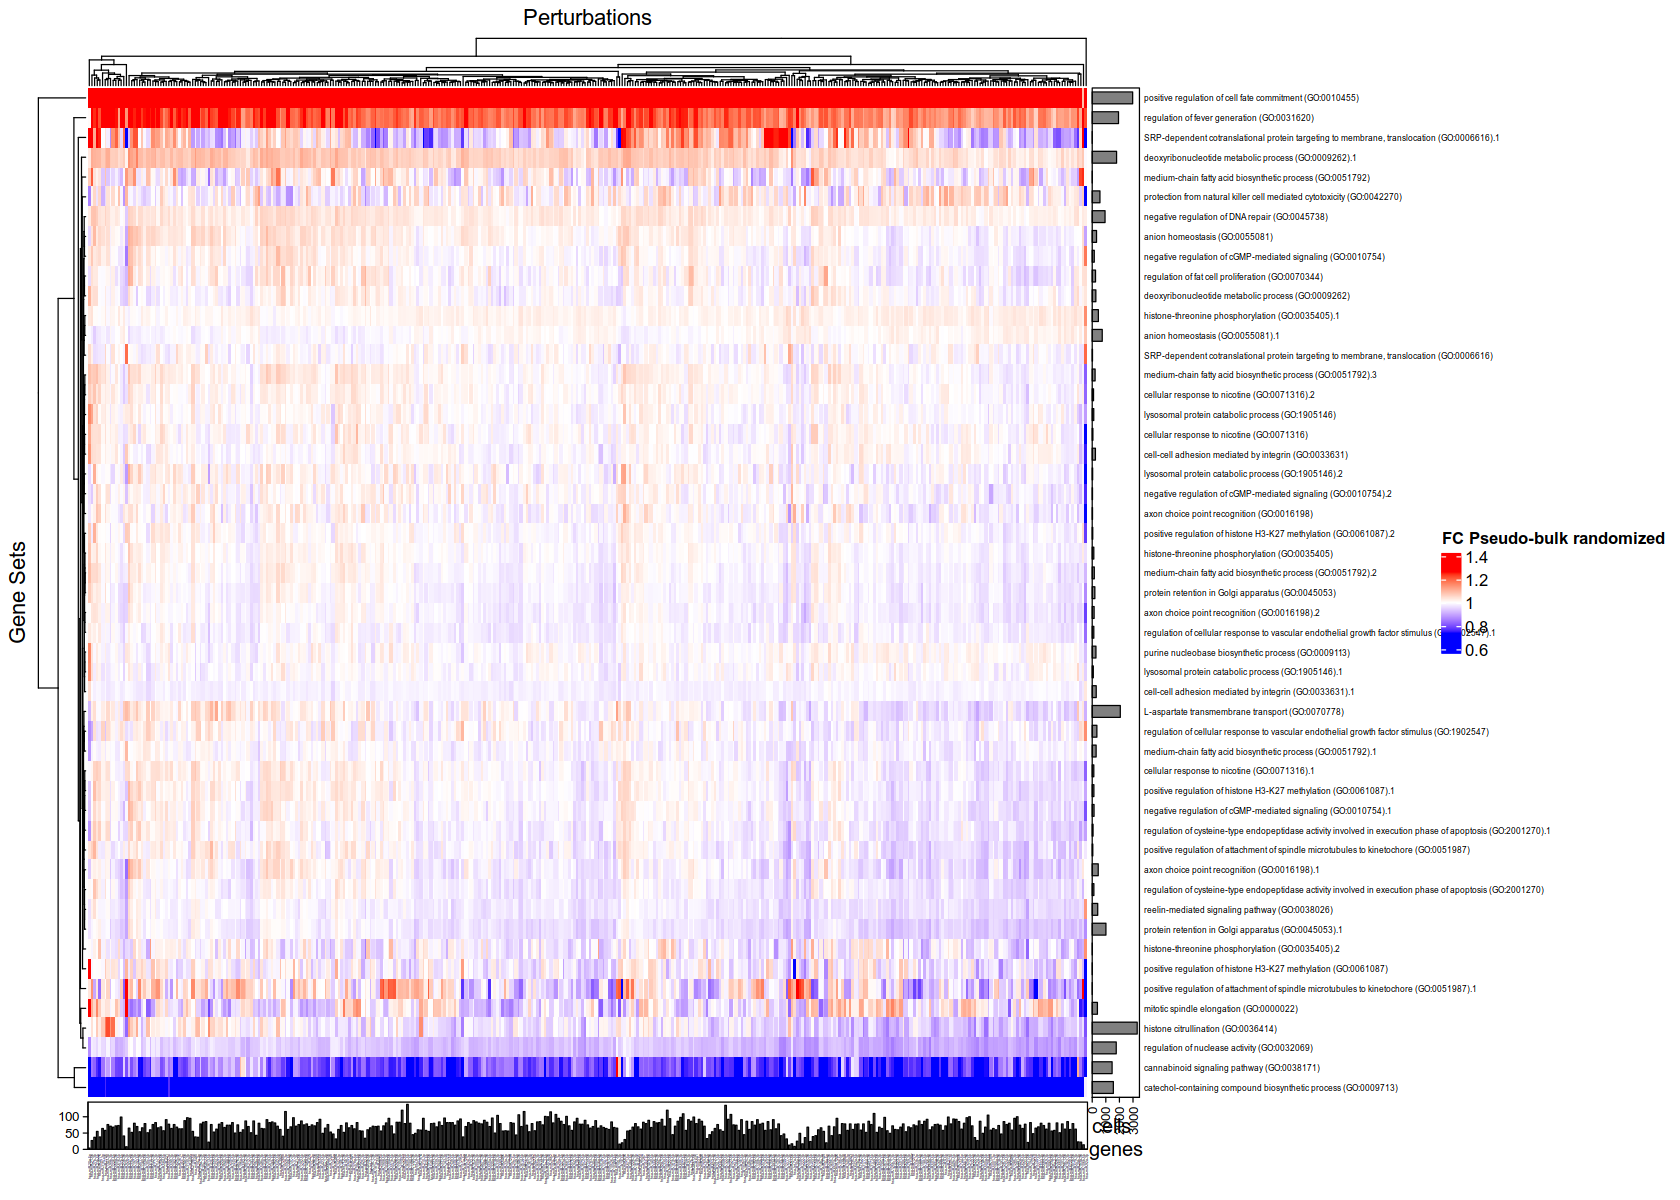

In [61]:
## random label custom geneset heatmap
## avg, lower_bound, and upper_bound inheireted from above graph

coloring_map <- circlize::colorRamp2(c(lower_bound, avg, upper_bound), c("blue", "white", "red"))
row_ha = rowAnnotation(genes = anno_barplot(unlist(lapply(custom_genesets, length))))
column_ha = HeatmapAnnotation(cells = anno_barplot(count_df$cells[!count_df$guide == 'TuD_NC']))
perturb_htmp(genesetexp_x_randomized_guide_FC2_temp, 'FC Pseudo-bulk randomized', right_annot = row_ha, bottom_annot = column_ha)

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



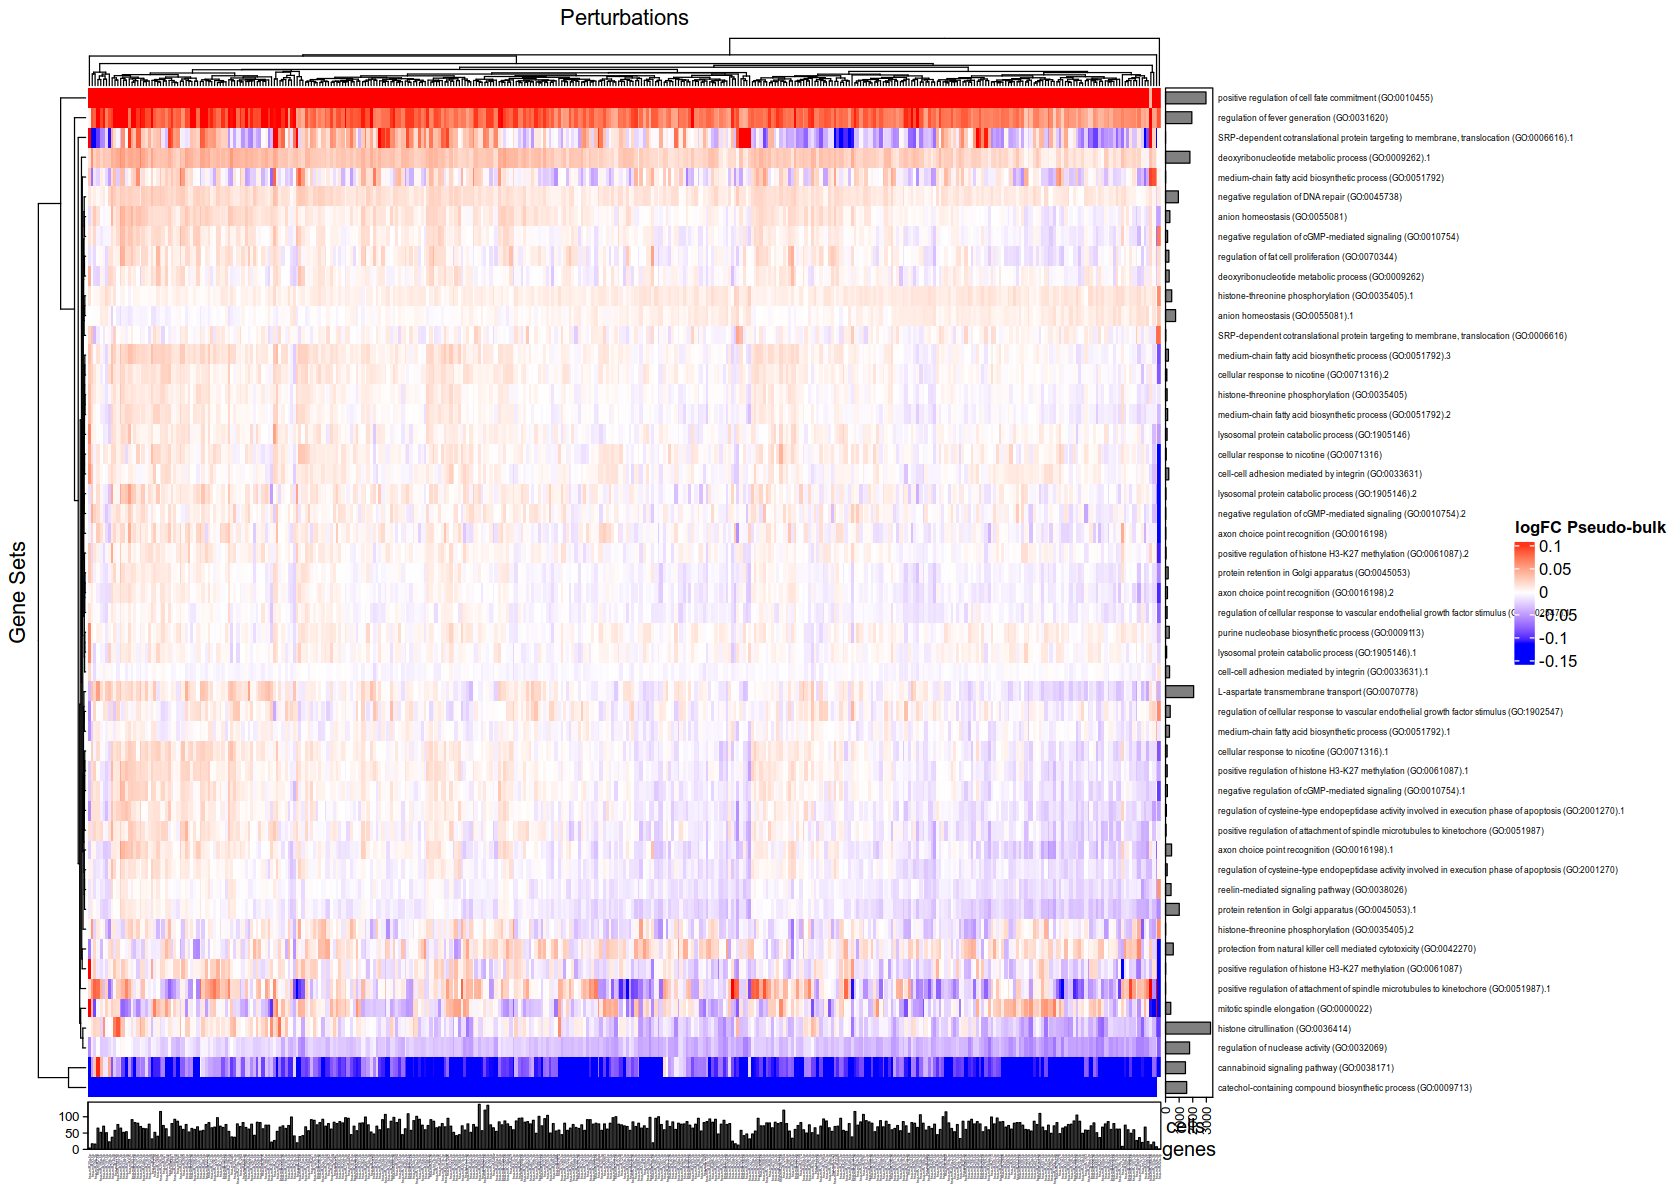

In [62]:
## change random label graph to logFC
genesetexp_x_randomized_guide_logFC2_temp = log10(genesetexp_x_randomized_guide_FC2_temp)
genesetexp_x_randomized_guide_logFC2_temp[is.infinite(genesetexp_x_randomized_guide_logFC2_temp)] = 0


coloring_map <- circlize::colorRamp2(c(lower_bound_log, avg_log, upper_bound_log), c("blue", "white", "red"))
row_ha = rowAnnotation(genes = anno_barplot(unlist(lapply(custom_genesets, length))))
column_ha = HeatmapAnnotation(cells = anno_barplot(count_df$cells[!count_df$guide == 'TuD_NC']))
perturb_htmp(genesetexp_x_randomized_guide_logFC2_temp, 'logFC Pseudo-bulk', right_annot = row_ha, bottom_annot = column_ha)

In [63]:
logFC_exp_df = data.frame(exp = c(as.numeric(genesetexp_x_guide_logFC2_temp), as.numeric(genesetexp_x_randomized_guide_logFC2_temp)),
                          type = c(rep('actual', length(genesetexp_x_guide_logFC2_temp)), rep('random', length(genesetexp_x_randomized_guide_logFC2_temp))),
                         guide = c(melt(genesetexp_x_guide_logFC2_temp)$Var2, melt(genesetexp_x_randomized_guide_logFC2_temp)$Var2), gene_set = c(melt(genesetexp_x_guide_logFC2_temp)$Var1, melt(genesetexp_x_randomized_guide_logFC2_temp)$Var1))

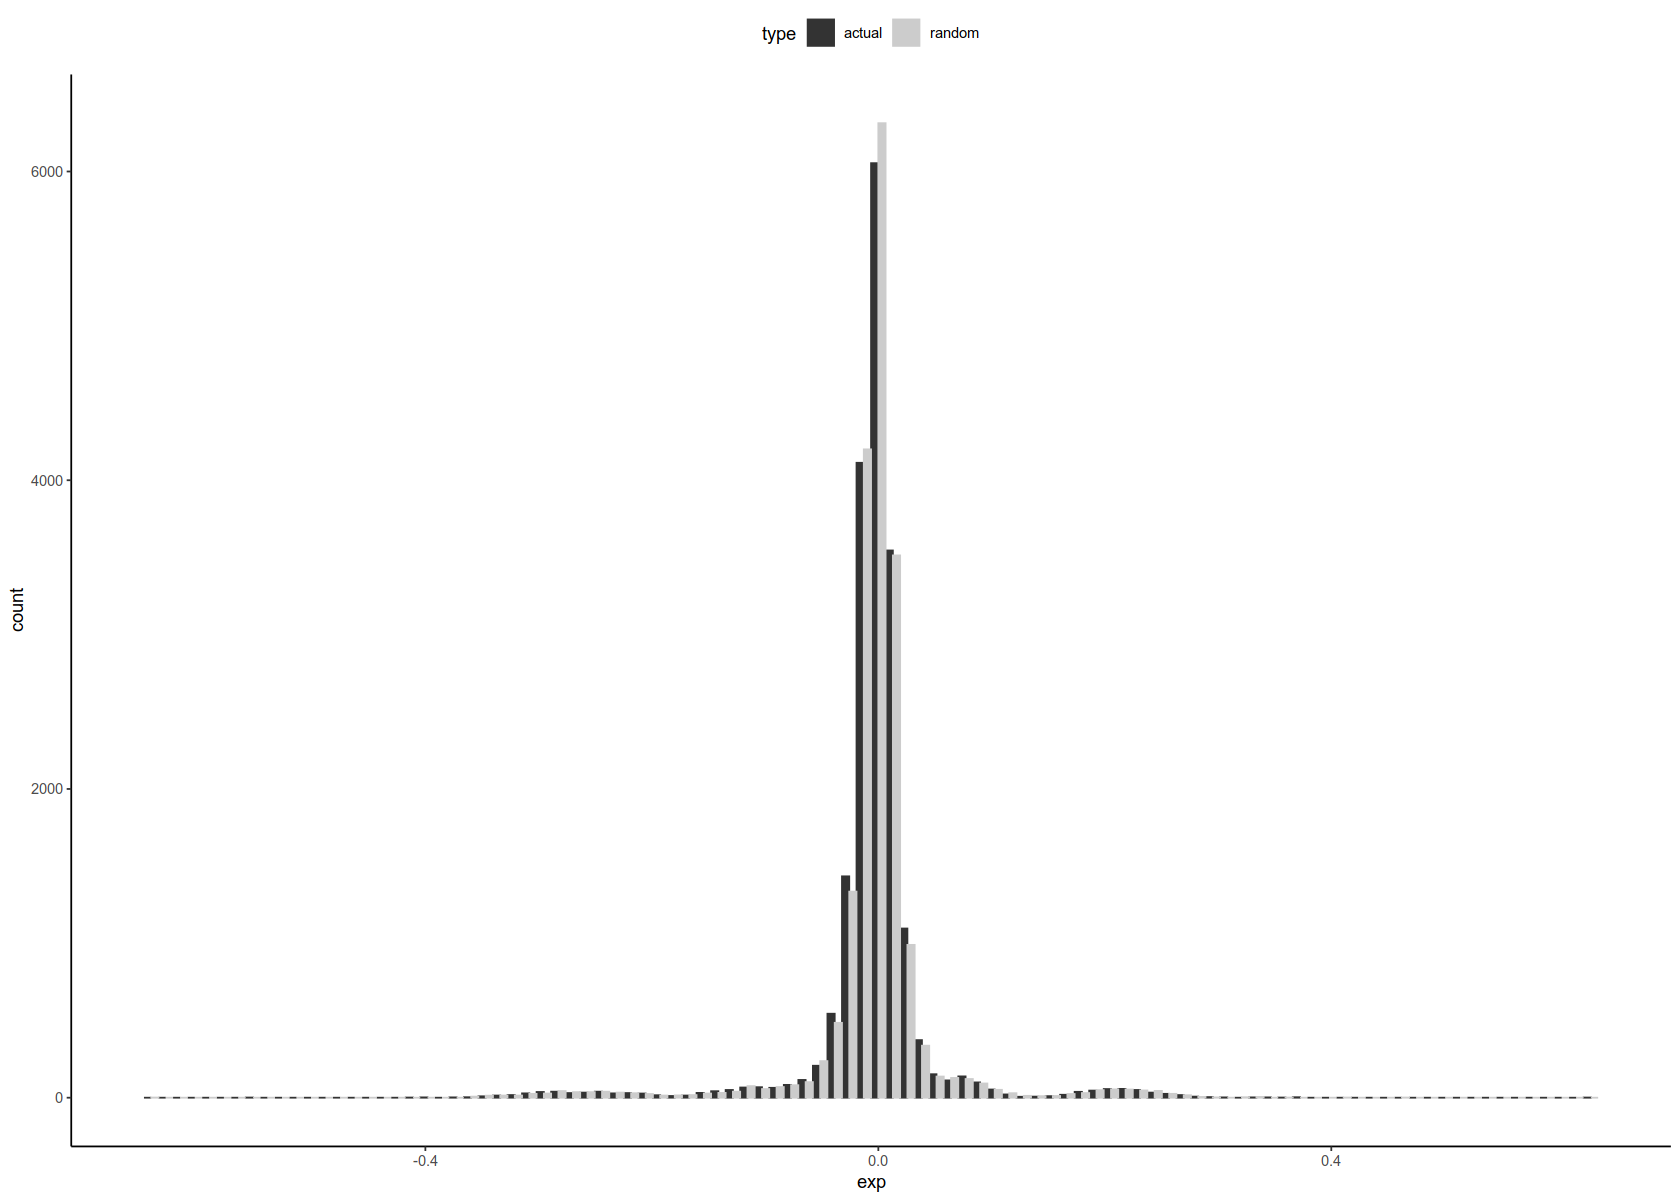

In [64]:
ggplot(logFC_exp_df, aes(x=exp, color=type, fill = type)) +
  geom_histogram(bins = 100, position="dodge") + scale_color_grey() + scale_fill_grey() + theme_classic() + theme(legend.position="top")

In [65]:
logFC_exp_df$sign = logFC_exp_df$exp
logFC_exp_df$sign[logFC_exp_df$sign < 0] = 'negative'
logFC_exp_df$sign[logFC_exp_df$sign > 0] = 'positive'
logFC_exp_df$sign[logFC_exp_df$sign == 0] = 'zero'

In [66]:
logFC_exp_df$exp <- abs(logFC_exp_df$exp)

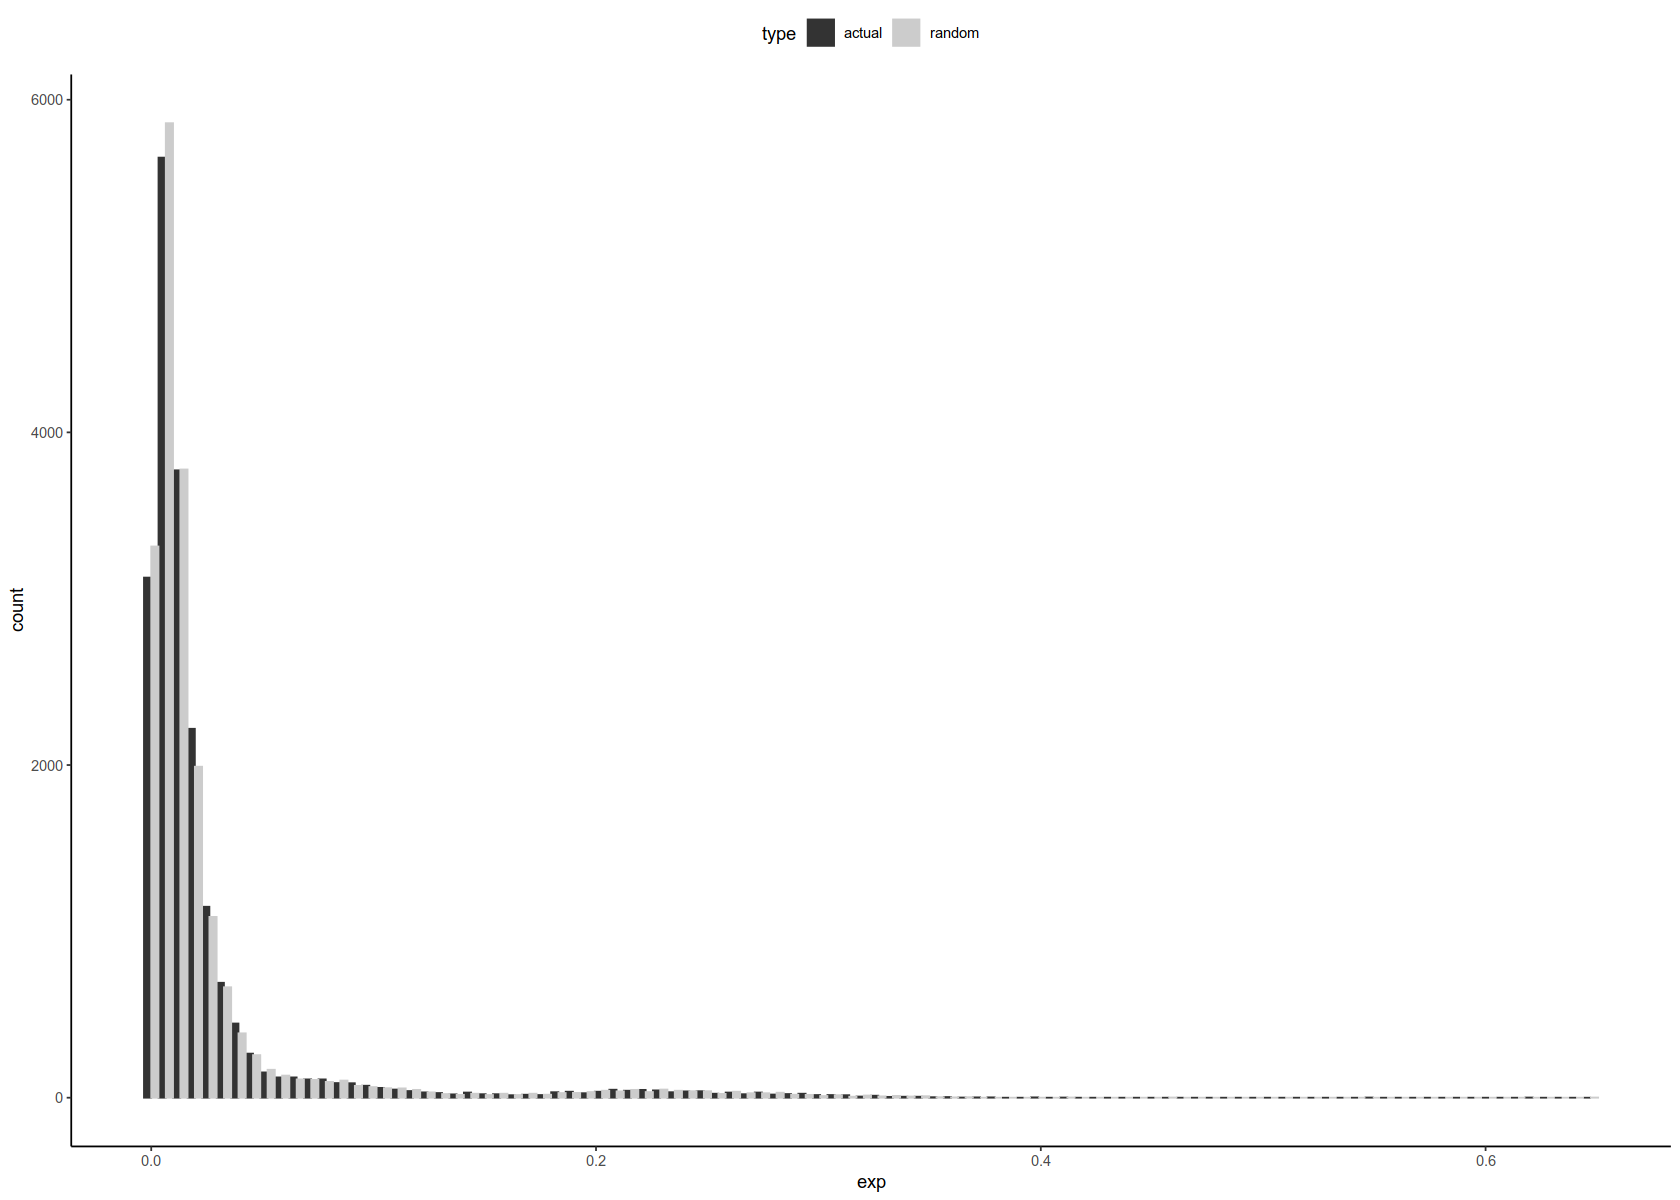

In [67]:
ggplot(logFC_exp_df, aes(x=exp, color=type, fill = type)) +
  geom_histogram(bins = 100, position="dodge") + scale_color_grey() + scale_fill_grey() + theme_classic() + theme(legend.position="top")

In [68]:
logFC_exp_df_rearranged = arrange(logFC_exp_df, exp)

In [69]:
logFC_exp_df_rearranged$actual_cumulative_count = logFC_exp_df_rearranged$type
logFC_exp_df_rearranged$actual_cumulative_count[logFC_exp_df_rearranged$actual_cumulative_count == 'random'] = 0
logFC_exp_df_rearranged$actual_cumulative_count[logFC_exp_df_rearranged$actual_cumulative_count == 'actual'] = 1
logFC_exp_df_rearranged$actual_cumulative_count = rev(cumsum(rev(logFC_exp_df_rearranged$actual_cumulative_count)))
logFC_exp_df_rearranged$random_cumulative_count = logFC_exp_df_rearranged$type
logFC_exp_df_rearranged$random_cumulative_count[logFC_exp_df_rearranged$random_cumulative_count == 'random'] = 1
logFC_exp_df_rearranged$random_cumulative_count[logFC_exp_df_rearranged$random_cumulative_count == 'actual'] = 0
logFC_exp_df_rearranged$random_cumulative_count = rev(cumsum(rev(logFC_exp_df_rearranged$random_cumulative_count)))

In [70]:
logFC_exp_df_rearranged$ratio_f = logFC_exp_df_rearranged$actual_cumulative_count/logFC_exp_df_rearranged$random_cumulative_count

In [71]:
logFC_exp_df_rearranged %>% arrange(-ratio_f)

exp       type   guide            
1     0.3684097 actual hsa-miR-4775     
2     0.3714021 actual hsa-miR-140-5p   
3     0.3751343 actual hsa-miR-147b-5p  
4     0.3653782 random hsa-miR-139-3p   
5     0.3781075 actual hsa-miR-4746-5p  
6     0.3578530 actual hsa-miR-1908-5p  
7     0.3634786 random hsa-miR-92a-3p   
8     0.3785003 actual hsa-miR-548k     
9     0.5495987 actual hsa-miR-92a-3p   
10    0.3591938 actual hsa-miR-3613-5p  
11    0.3623502 actual hsa-miR-629-3p   
12    0.3569732 random hsa-miR-23b-3p   
13    0.3615006 actual hsa-miR-191-5p   
14    0.3633553 random hsa-miR-95-3p    
15    0.3963504 actual hsa-miR-642a-5p  
16    0.3486022 actual hsa-miR-1226-5p  
17    0.3618556 random hsa-miR-579-3p   
18    0.3558685 random hsa-miR-550a-3p  
19    0.3510085 actual hsa-miR-142-3p   
20    0.3486579 actual hsa-miR-3177-3p  
21    0.4139923 actual hsa-miR-653-3p   
22    0.3484373 random hsa-miR-664a-3p  
23    0.3520047 actual hsa-miR-103a-3p  
24    0.3476504 actual hsa-miR-942-5p   
25    0.3495051 random hsa-miR-30a-5p   
26    0.3548476 random hsa-miR-576-3p   
27    0.3524774 actual hsa-miR-92a-3p   
28    0.3483263 random hsa-miR-1303     
29    0.3445181 actual hsa-miR-182-3p   
30    0.3476405 random hsa-miR-140-3p   
⋮     ⋮         ⋮      ⋮                
38425 0.3284974 actual hsa-miR-1277-3p  
38426 0.3164046 actual hsa-miR-551b-5p  
38427 0.3183997 random hsa-miR-660-5p   
38428 0.3328184 random hsa-miR-616-5p   
38429 0.3244797 random hsa-let-7a-5p    
38430 0.3250400 actual hsa-let-7i-3p    
38431 0.3164705 actual hsa-miR-7706     
38432 0.3261093 random hsa-miR-22-3p    
38433 0.3278597 random hsa-miR-1226-5p  
38434 0.3183273 random hsa-miR-616-5p   
38435 0.3290482 actual hsa-let-7i-5p    
38436 0.3291103 actual hsa-miR-522-3p   
38437 0.3171262 actual hsa-miR-3619-5p  
38438 0.3326789 random hsa-miR-27b-5p   
38439 0.3175565 actual hsa-miR-937-3p   
38440 0.3181598 random hsa-miR-149-5p   
38441 0.3250911 random hsa-miR-605-5p   
38442 0.3291055 random hsa-miR-3614-5p  
38443 0.3291999 actual hsa-miR-186-5p   
38444 0.3173195 random hsa-miR-6724-5p  
38445 0.3297494 actual hsa-miR-423-5p   
38446 0.3176721 random hsa-miR-29c-5p   
38447 0.3302760 actual hsa-miR-330-5p   
38448 0.3310052 actual hsa-miR-671-5p   
38449 0.3322979 random hsa-miR-653-3p   
38450 0.3293367 random hsa-miR-7706     
38451 0.3298711 random hsa-miR-19b-1-5p 
38452 0.3303554 random hsa-miR-99b-3p   
38453 0.3319533 random hsa-miR-181a-2-3p
38454 0.6473502 random hsa-miR-92b-3p   
      gene_set                                                       sign    
1     catechol-containing compound biosynthetic process (GO:0009713) positive
2     positive regulation of cell fate commitment (GO:0010455)       positive
3     positive regulation of cell fate commitment (GO:0010455)       positive
4     catechol-containing compound biosynthetic process (GO:0009713) positive
5     catechol-containing compound biosynthetic process (GO:0009713) positive
6     positive regulation of cell fate commitment (GO:0010455)       positive
7     cannabinoid signaling pathway (GO:0038171)                     positive
8     positive regulation of cell fate commitment (GO:0010455)       positive
9     cannabinoid signaling pathway (GO:0038171)                     positive
10    catechol-containing compound biosynthetic process (GO:0009713) positive
11    catechol-containing compound biosynthetic process (GO:0009713) positive
12    catechol-containing compound biosynthetic process (GO:0009713) positive
13    catechol-containing compound biosynthetic process (GO:0009713) positive
14    catechol-containing compound biosynthetic process (GO:0009713) positive
15    catechol-containing compound biosynthetic process (GO:0009713) positive
16    catechol-containing compound biosynthetic process (GO:0009713) positive
17    catechol-containing compound biosynthetic process (GO:0009713) positive
18    positive regulation of cell fate commitment (GO:001045

In [72]:
#logFC_exp_df_rearranged %>% write.csv('~/projects/mir_tud/notebooks/miR_basic_analysis/matrix_df.csv')

In [73]:
length(which(logFC_exp_df_rearranged$ratio_f > 10))

[1] 0

In [74]:
## percent of total elements passing FDR ratio above 10
100*length(which(logFC_exp_df_rearranged$ratio_f > 10))/nrow(logFC_exp_df_rearranged)

[1] 0

In [75]:
elements_passing_FDR = logFC_exp_df_rearranged[logFC_exp_df_rearranged$ratio_f > 10, ]

In [76]:
elements_passing_FDR_summarized_counts = elements_passing_FDR %>% group_by(gene_set) %>% summarize(counts = n())

In [77]:
elements_passing_FDR_summarized_counts

gene_set counts

In [78]:
pathway_passed_counts = rep(0, length(pathway_names))

for (i in 1:length(pathway_names)){
    if (pathway_names[i] %in% as.character(elements_passing_FDR_summarized_counts$gene_set)){
        idx <- which(pathway_names[i] == as.character(elements_passing_FDR_summarized_counts$gene_set))
        pathway_passed_counts[i] = elements_passing_FDR_summarized_counts[idx,'counts']
    }
}

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



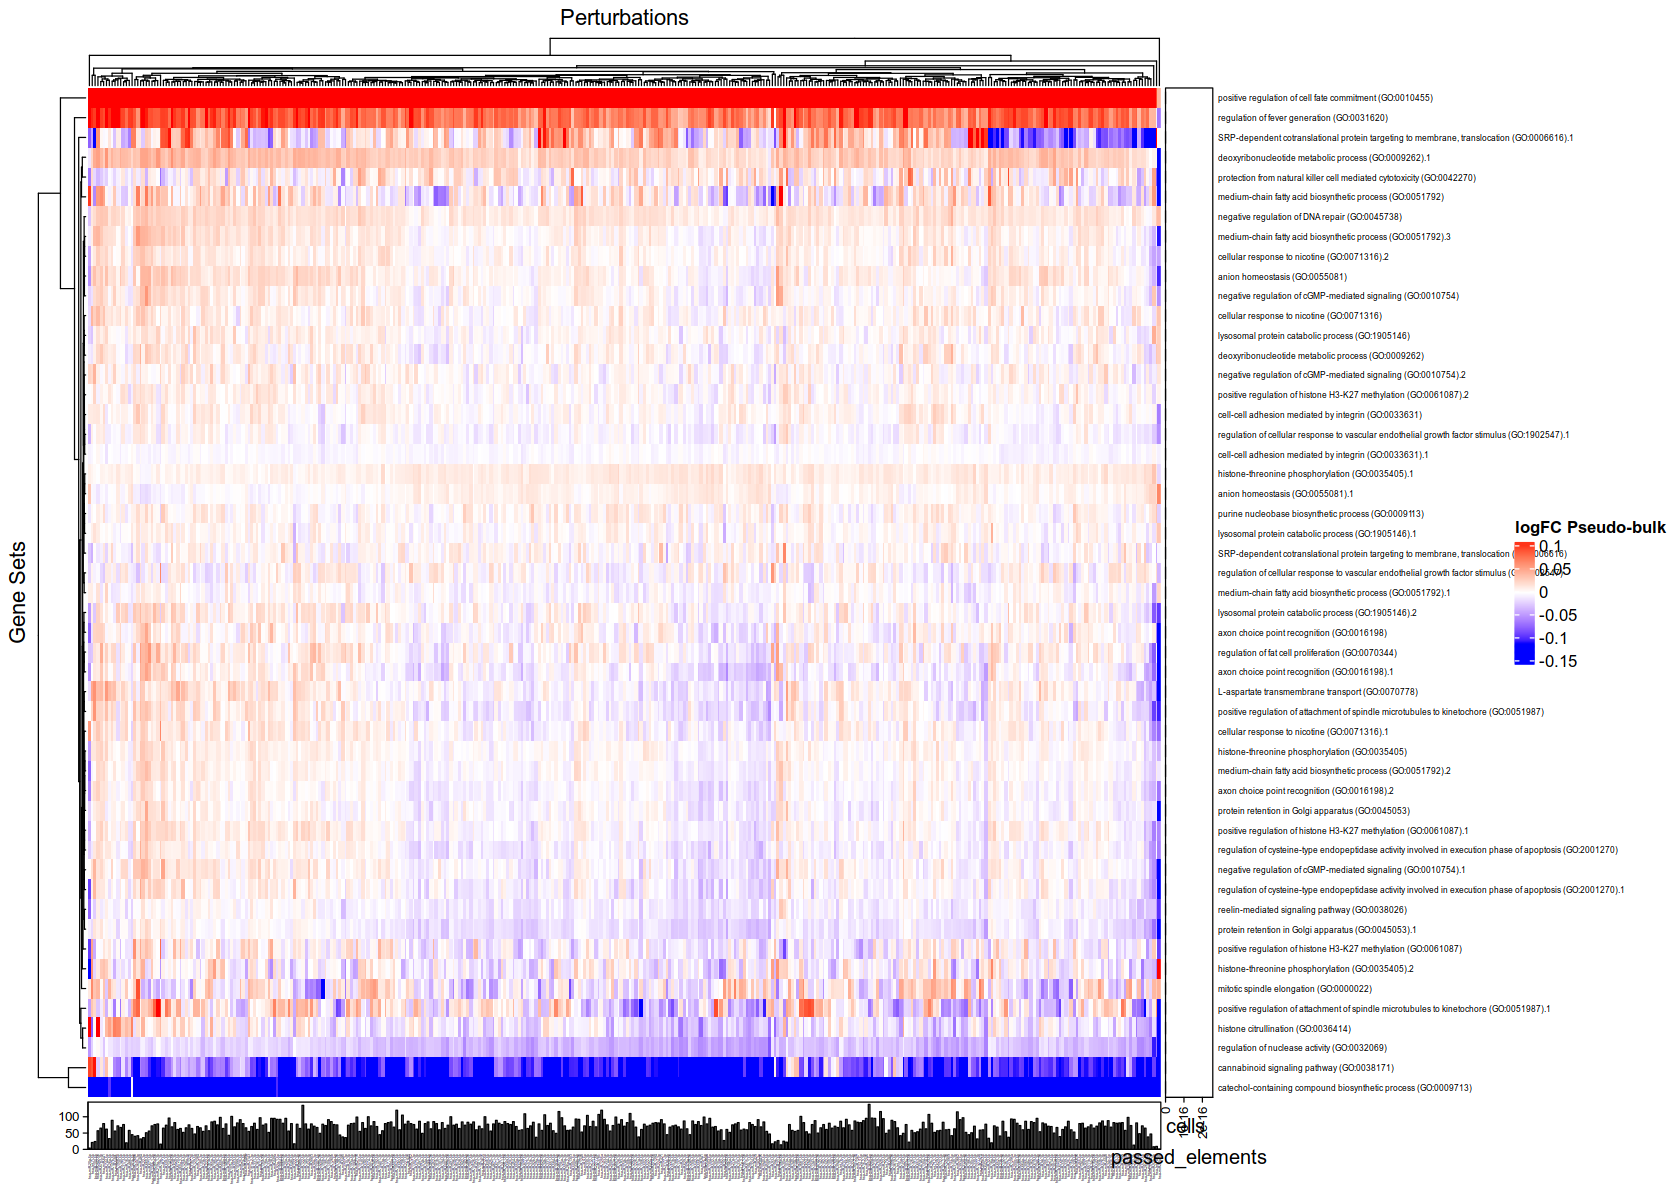

In [79]:
## logFC heatmap with number of genes in gene set that pass FDR 0.1 on right side
genesetexp_x_guide_logFC2_temp = log10(genesetexp_x_guide_FC2_temp)
genesetexp_x_guide_logFC2_temp[is.infinite(genesetexp_x_guide_logFC2_temp)] = 0

avg_log = mean(genesetexp_x_guide_logFC2_temp)
lower_bound_log = mean(genesetexp_x_guide_logFC2_temp) - 2*sd(genesetexp_x_guide_logFC2_temp)
upper_bound_log = mean(genesetexp_x_guide_logFC2_temp) + 2*sd(genesetexp_x_guide_logFC2_temp)

coloring_map <- circlize::colorRamp2(c(lower_bound_log, avg_log, upper_bound_log), c("blue", "white", "red"))
row_ha = rowAnnotation(passed_elements = anno_barplot(as.numeric(pathway_passed_counts)))
column_ha = HeatmapAnnotation(cells = anno_barplot(count_df$cells[!count_df$guide == 'TuD_NC']))
perturb_htmp(genesetexp_x_guide_logFC2_temp, 'logFC Pseudo-bulk', right_annot = row_ha, bottom_annot = column_ha)

In [78]:
## zero out nonsignificant elements
genesetexp_x_guide_logFC3_temp = genesetexp_x_guide_logFC2_temp
progress_bar = txtProgressBar(min=0, max=nrow(genesetexp_x_guide_logFC2_temp), style = 3, char="=")
for (i in 1:nrow(genesetexp_x_guide_logFC2_temp)){
    for (j in 1:ncol(genesetexp_x_guide_logFC2_temp)){
        ratio = as.numeric(dplyr::filter(logFC_exp_df_rearranged, gene_set == rownames(genesetexp_x_guide_logFC3_temp)[i] 
                      & guide == colnames(genesetexp_x_guide_logFC3_temp)[j] & type == 'actual')['ratio_f'])
        if (ratio <= 10){
            genesetexp_x_guide_logFC3_temp[i,j] = 0
        }
    }
    setTxtProgressBar(progress_bar, value = i)
}

  |=====                                                                 |   8%

In [ ]:
write.csv(genesetexp_x_guide_logFC3_temp, '/home/ssobti/projects/mir_tud/output_data/genexp_pathway/pseudobulk_logFC_custom_geneset_htmap_miR_zeroed_nonsig_elements_mtx.csv')

In [ ]:
avg_log = mean(genesetexp_x_guide_logFC3_temp)
lower_bound_log = mean(genesetexp_x_guide_logFC3_temp) - 2*sd(genesetexp_x_guide_logFC3_temp)
upper_bound_log = mean(genesetexp_x_guide_logFC3_temp) + 2*sd(genesetexp_x_guide_logFC3_temp)

coloring_map <- magma(10, begin = 0.03, end = 0.99, direction = 1)
row_ha = rowAnnotation(passed_elements = anno_barplot(as.numeric(pathway_passed_counts)))
column_ha = HeatmapAnnotation(cells = anno_barplot(count_df$cells[!count_df$guide == 'TuD_NC']))
perturb_htmp(genesetexp_x_guide_logFC3_temp, 'logFC Pseudo-bulk', right_annot = row_ha, bottom_annot = column_ha)

pdf('/home/ssobti/projects/mir_tud/output_data/genexp_pathway/pseudobulk_logFC_custom_geneset_htmap_miR_zeroed_nonsig_elements.pdf', width = 15, height = 11)
perturb_htmp(genesetexp_x_guide_logFC3_temp, 'logFC Pseudo-bulk', right_annot = row_ha, bottom_annot = column_ha)
dev.off()

In [46]:
coloring_map <- plasma(10, begin = 0, end = 1, direction = 1)

pdf('/home/ssobti/projects/mir_tud/output_data/genexp_pathway/pseudobulk_logFC_custom_geneset_htmap_miR_zeroed_nonsig_elements2.pdf', width = 15, height = 11)
perturb_htmp(genesetexp_x_guide_logFC3_temp, 'logFC Pseudo-bulk', right_annot = row_ha, bottom_annot = column_ha)
dev.off()

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  2

In [154]:
objs_to_save = setdiff(ls(), c('miR_loaded_seuratobj', 'miR_seuratobj', 'miR_seuratobj_rel_norlmalized'))

In [129]:
object.size(miR_loaded_seuratobj, units = 'Mb')

ERROR: Error in object.size(miR_loaded_seuratobj, units = "Mb"): unused argument (units = "Mb")


In [150]:
sum(as.numeric(sapply(objs_to_save, function(x) stringr::str_sub(format(object.size(x), units = "Kb"), start = 1, end = -4))))

[1] 8.6

In [ ]:
#save.image('/home/ssobti/projects/mir_tud/output_data/genexp_pathway/pseudobulk_pathway_analysis_miR_abridged_progress_save.RData')

In [96]:
genes_top_row_red = as.character(unlist(custom_genesets[pathway_names == 'positive regulation of cell fate commitment (GO:0010455)']))
genes_bottom_row_blue = as.character(unlist(custom_genesets[pathway_names == 'catechol-containing compound biosynthetic process (GO:0009713)']))

In [99]:
colnames(Pseudo_bulk_exp)

[1] "hsa-let-7a-2-3p"   "hsa-let-7a-5p"     "hsa-let-7b-3p"    
  [4] "hsa-let-7d-3p"     "hsa-let-7f-2-3p"   "hsa-let-7i-3p"    
  [7] "hsa-let-7i-5p"     "hsa-miR-100-3p"    "hsa-miR-100-5p"   
 [10] "hsa-miR-101-3p"    "hsa-miR-10399-3p"  "hsa-miR-10399-5p" 
 [13] "hsa-miR-103a-2-5p" "hsa-miR-103a-3p"   "hsa-miR-10401-3p" 
 [16] "hsa-miR-10523-5p"  "hsa-miR-10526-3p"  "hsa-miR-10527-5p" 
 [19] "hsa-miR-106b-3p"   "hsa-miR-106b-5p"   "hsa-miR-10a-3p"   
 [22] "hsa-miR-10a-5p"    "hsa-miR-1180-3p"   "hsa-miR-1180-5p"  
 [25] "hsa-miR-122-5p"    "hsa-miR-1226-3p"   "hsa-miR-1226-5p"  
 [28] "hsa-miR-1246"      "hsa-miR-1248"      "hsa-miR-1249-3p"  
 [31] "hsa-miR-1255a"     "hsa-miR-125a-3p"   "hsa-miR-125a-5p"  
 [34] "hsa-miR-125b-1-3p" "hsa-miR-125b-5p"   "hsa-miR-126-3p"   
 [37] "hsa-miR-126-5p"    "hsa-miR-1260b"     "hsa-miR-1262"     
 [40] "hsa-miR-1267"      "hsa-miR-1268b"     "hsa-miR-1270"     
 [43] "hsa-miR-1271-5p"   "hsa-miR-1277-3p"   "hsa-miR-1278"     
 [46] "hsa-miR-128-1-5p"  "hsa-miR-128-3p"    "hsa-miR-1284"     
 [49] "hsa-miR-1285-3p"   "hsa-miR-1287-5p"   "hsa-miR-129-5p"   
 [52] "hsa-miR-1292-5p"   "hsa-miR-1294"      "hsa-miR-1295a"    
 [55] "hsa-miR-1296-5p"   "hsa-miR-1299"      "hsa-miR-1301-3p"  
 [58] "hsa-miR-1303"      "hsa-miR-1304-3p"   "hsa-miR-1304-5p"  
 [61] "hsa-miR-1306-5p"   "hsa-miR-1307-3p"   "hsa-miR-1307-5p"  
 [64] "hsa-miR-130a-5p"   "hsa-miR-130b-3p"   "hsa-miR-130b-5p"  
 [67] "hsa-miR-132-3p"    "hsa-miR-132-5p"    "hsa-miR-1343-3p"  
 [70] "hsa-miR-135b-5p"   "hsa-miR-137-3p"    "hsa-miR-138-1-3p" 
 [73] "hsa-miR-138-5p"    "hsa-miR-139-3p"    "hsa-miR-139-5p"   
 [76] "hsa-miR-140-3p"    "hsa-miR-140-5p"    "hsa-miR-142-3p"   
 [79] "hsa-miR-143-3p"    "hsa-miR-146a-5p"   "hsa-miR-146b-5p"  
 [82] "hsa-miR-147b-5p"   "hsa-miR-148a-3p"   "hsa-miR-148a-5p"  
 [85] "hsa-miR-149-5p"    "hsa-miR-151a-3p"   "hsa-miR-151a-5p"  
 [88] "hsa-miR-15a-5p"    "hsa-miR-15b-3p"    "hsa-miR-15b-5p"   
 [91] "hsa-miR-16-2-3p"   "hsa-miR-16-5p"     "hsa-miR-17-3p"    
 [94] "hsa-miR-181a-2-3p" "hsa-miR-181a-5p"   "hsa-miR-181b-3p"  
 [97] "hsa-miR-181b-5p"   "hsa-miR-182-3p"    "hsa-miR-182-5p"   
[100] "hsa-miR-183-3p"    "hsa-miR-183-5p"    "hsa-miR-185-3p"   
[103] "hsa-miR-185-5p"    "hsa-miR-186-5p"    "hsa-miR-188-5p"   
[106] "hsa-miR-18a-3p"    "hsa-miR-18a-5p"    "hsa-miR-1908-5p"  
[109] "hsa-miR-190a-5p"   "hsa-miR-190b-5p"   "hsa-miR-191-3p"   
[112] "hsa-miR-191-5p"    "hsa-miR-1910-5p"   "hsa-miR-192-5p"   
[115] "hsa-miR-193a-5p"   "hsa-miR-193b-3p"   "hsa-miR-193b-5p"  
[118] "hsa-miR-194-3p"    "hsa-miR-194-5p"    "hsa-miR-196a-5p"  
[121] "hsa-miR-197-3p"    "hsa-miR-199b-3p"   "hsa-miR-19b-1-5p" 
[124] "hsa-miR-19b-3p"    "hsa-miR-200a-3p"   "hsa-miR-200a-5p"  
[127] "hsa-miR-200b-5p"   "hsa-miR-200c-3p"   "hsa-miR-203a-3p"  
[130] "hsa-miR-204-5p"    "hsa-miR-205-5p"    "hsa-miR-20a-3p"   
[133] "hsa-miR-20a-5p"    "hsa-miR-21-3p"     "hsa-miR-21-5p"    
[136] "hsa-miR-210-3p"    "hsa-miR-2110"      "hsa-miR-212-3p"   
[139] "hsa-miR-212-5p"    "hsa-miR-218-5p"    "hsa-miR-219a-1-3p"
[142] "hsa-miR-219b-5p"   "hsa-miR-22-3p"     "hsa-miR-22-5p"    
[145] "hsa-miR-221-3p"    "hsa-miR-221-5p"    "hsa-miR-222-3p"   
[148] "hsa-miR-222-5p"    "hsa-miR-224-3p"    "hsa-miR-224-5p"   
[151] "hsa-miR-2277-5p"   "hsa-miR-23a-5p"    "hsa-miR-23b-3p"   
[154] "hsa-miR-23b-5p"    "hsa-miR-24-1-5p"   "hsa-miR-24-2-5p"  
[157] "hsa-miR-24-3p"     "hsa-miR-25-3p"     "hsa-miR-25-5p"    
[160] "hsa-miR-26a-1-3p"  "hsa-miR-26a-2-3p"  "hsa-miR-26a-5p"   
[163] "hsa-miR-27a-5p"    "hsa-miR-27b-3p"    "hsa-miR-27b-5p"   
[166] "hsa-miR-28-3p"     "hsa-miR-28-5p"     "hsa-miR-29a-3p"   
[169] "hsa-miR-29a-5p"    "hsa-miR-29b-1-5p"  "hsa-miR-29b-3p"   
[172] "hsa-miR-29c-5p"    "hsa-miR-301a-3p"   "hsa-miR-301a-5p"  
[175] "hsa-miR-301b-5p"   "hsa-miR-3064-5p"   "hsa-miR-3065-3p"  
[178] "hsa-miR-3065-5p"   "hsa-miR-30a-3p"    "hsa-miR-30a-5p"   
[181] "hsa-miR-30b-3p"    "hsa-miR-30c-1-3

In [104]:
data = colMeans(Pseudo_bulk_exp[genes_top_row_red,])
gds = names(data)
gds[!gds == 'TuD_NC'] = 'other'
genes_top_row_red_df = data.frame(guide = names(data), exp = as.numeric(data), 
                                 status = gds)

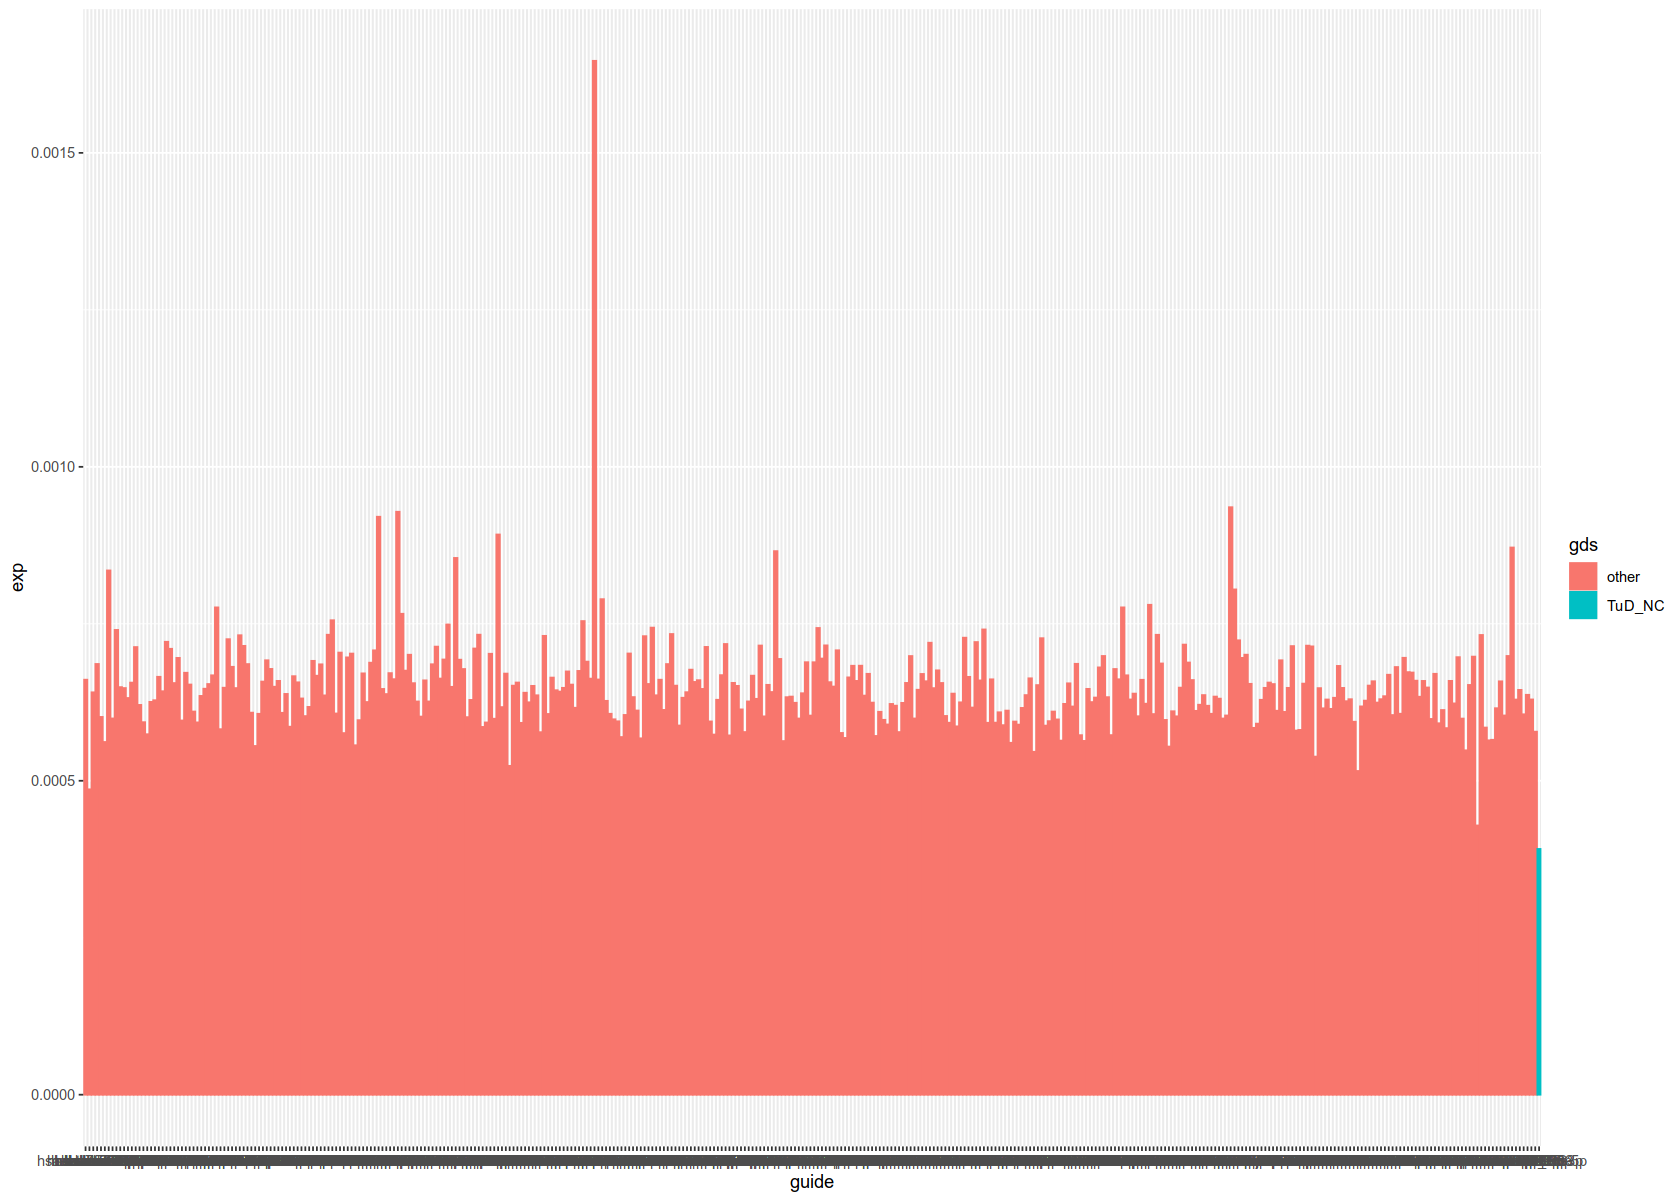

In [109]:
ggplot(data=genes_top_row_red_df, aes(x=guide, y=exp, color = gds, fill = gds)) +
  geom_bar(stat="identity")

In [110]:
data = colMeans(Pseudo_bulk_exp[genes_bottom_row_blue,])
gds = names(data)
gds[!gds == 'TuD_NC'] = 'other'
genes_bottom_row_blue_df = data.frame(guide = names(data), exp = as.numeric(data), 
                                 status = gds)

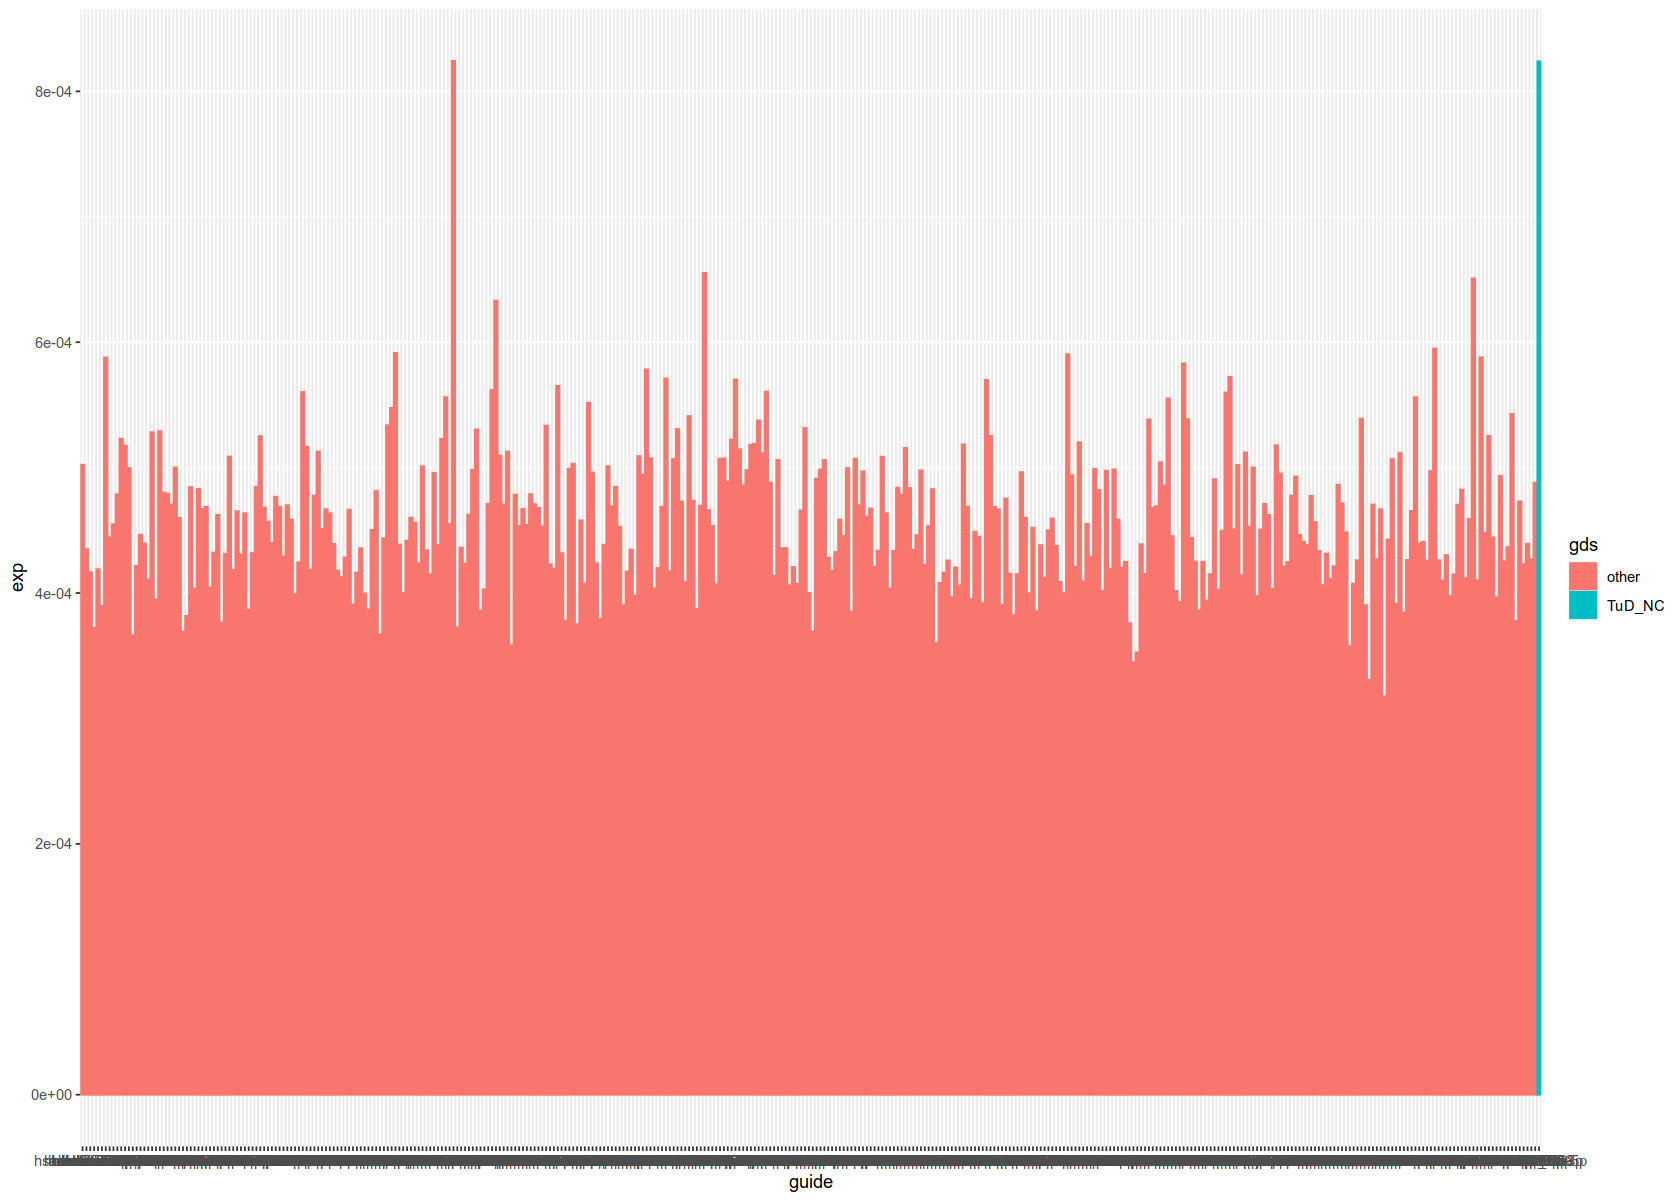

In [111]:
ggplot(data=genes_bottom_row_blue_df, aes(x=guide, y=exp, color = gds, fill = gds)) +
  geom_bar(stat="identity")

In [112]:
genes_bottom_row_blue_df %>% arrange(-exp)

guide            exp          status
1   hsa-miR-181b-5p  0.0008243391 other 
2   TuD_NC           0.0008239894 TuD_NC
3   hsa-miR-26a-5p   0.0006552129 other 
4   hsa-miR-92a-1-5p 0.0006508562 other 
5   hsa-miR-1908-5p  0.0006331697 other 
6   hsa-miR-744-5p   0.0005949737 other 
7   hsa-miR-147b-5p  0.0005914993 other 
8   hsa-miR-449a     0.0005904158 other 
9   hsa-miR-92b-3p   0.0005880127 other 
10  hsa-let-7i-5p    0.0005878845 other 
11  hsa-miR-503-5p   0.0005832002 other 
12  hsa-miR-222-3p   0.0005783142 other 
13  hsa-miR-548k     0.0005723508 other 
14  hsa-miR-23a-5p   0.0005710854 other 
15  hsa-miR-29b-1-5p 0.0005703459 other 
16  hsa-miR-374b-3p  0.0005699559 other 
17  hsa-miR-19b-3p   0.0005652174 other 
18  hsa-miR-18a-5p   0.0005619462 other 
19  hsa-miR-3065-5p  0.0005605876 other 
20  hsa-miR-1303     0.0005603676 other 
21  hsa-miR-548j-5p  0.0005599092 other 
22  hsa-miR-181a-5p  0.0005561824 other 
23  hsa-miR-6783-3p  0.0005561299 other 
24  hsa-miR-500a-5p  0.0005552024 other 
25  hsa-miR-20a-3p   0.0005517274 other 
26  hsa-miR-146b-5p  0.0005476065 other 
27  hsa-miR-942-5p   0.0005428183 other 
28  hsa-miR-25-3p    0.0005411419 other 
29  hsa-miR-641      0.0005390990 other 
30  hsa-miR-505-3p   0.0005386793 other 
⋮   ⋮                ⋮            ⋮     
349 hsa-let-7i-3p    0.0003898357 other 
350 hsa-miR-26a-1-3p 0.0003873710 other 
351 hsa-miR-139-5p   0.0003869004 other 
352 hsa-miR-1277-3p  0.0003867446 other 
353 hsa-miR-522-3p   0.0003861992 other 
354 hsa-miR-186-5p   0.0003861195 other 
355 hsa-miR-423-5p   0.0003856312 other 
356 hsa-miR-330-5p   0.0003851640 other 
357 hsa-miR-671-5p   0.0003845178 other 
358 hsa-miR-3928-3p  0.0003823813 other 
359 hsa-miR-1246     0.0003817772 other 
360 hsa-miR-21-5p    0.0003796828 other 
361 hsa-miR-200a-5p  0.0003779943 other 
362 hsa-miR-95-3p    0.0003777902 other 
363 hsa-miR-126-5p   0.0003765367 other 
364 hsa-miR-4742-3p  0.0003759625 other 
365 hsa-miR-203a-3p  0.0003751617 other 
366 hsa-miR-182-3p   0.0003727379 other 
367 hsa-let-7d-3p    0.0003723106 other 
368 hsa-miR-1226-5p  0.0003692491 other 
369 hsa-miR-3177-3p  0.0003692017 other 
370 hsa-miR-142-3p   0.0003672089 other 
371 hsa-miR-103a-3p  0.0003663674 other 
372 hsa-miR-3613-5p  0.0003603527 other 
373 hsa-miR-191-5p   0.0003584437 other 
374 hsa-miR-629-3p   0.0003577432 other 
375 hsa-miR-4775     0.0003527865 other 
376 hsa-miR-4746-5p  0.0003449960 other 
377 hsa-miR-642a-5p  0.0003308044 other 
378 hsa-miR-653-3p   0.0003176357 other

In [156]:
save(list = objs_to_save, file = '/home/ssobti/projects/mir_tud/output_data/genexp_pathway/pseudobulk_pathway_analysis_miR_abridged_progress_save2.RData')

In [ ]:
## combine genes by cluster to get gene sets
## put gene sets thru enrich to define their function
## run pseudobulk heatmap of guide x gene set FC

In [ ]:
column_dendogram = column_dend(foldchange_htmp)

In [ ]:
class(column_dendogram)

[1] "dendrogram"

In [ ]:
saveRDS(column_dendogram, '/home/ssobti/projects/mir_tud/output_data/genexp_pathway/miR_pseudobulk_FC_dendo.rds')

In [ ]:
library(ggdendro)
dend_data <- dendro_data(column_dendogram, type = "rectangle")

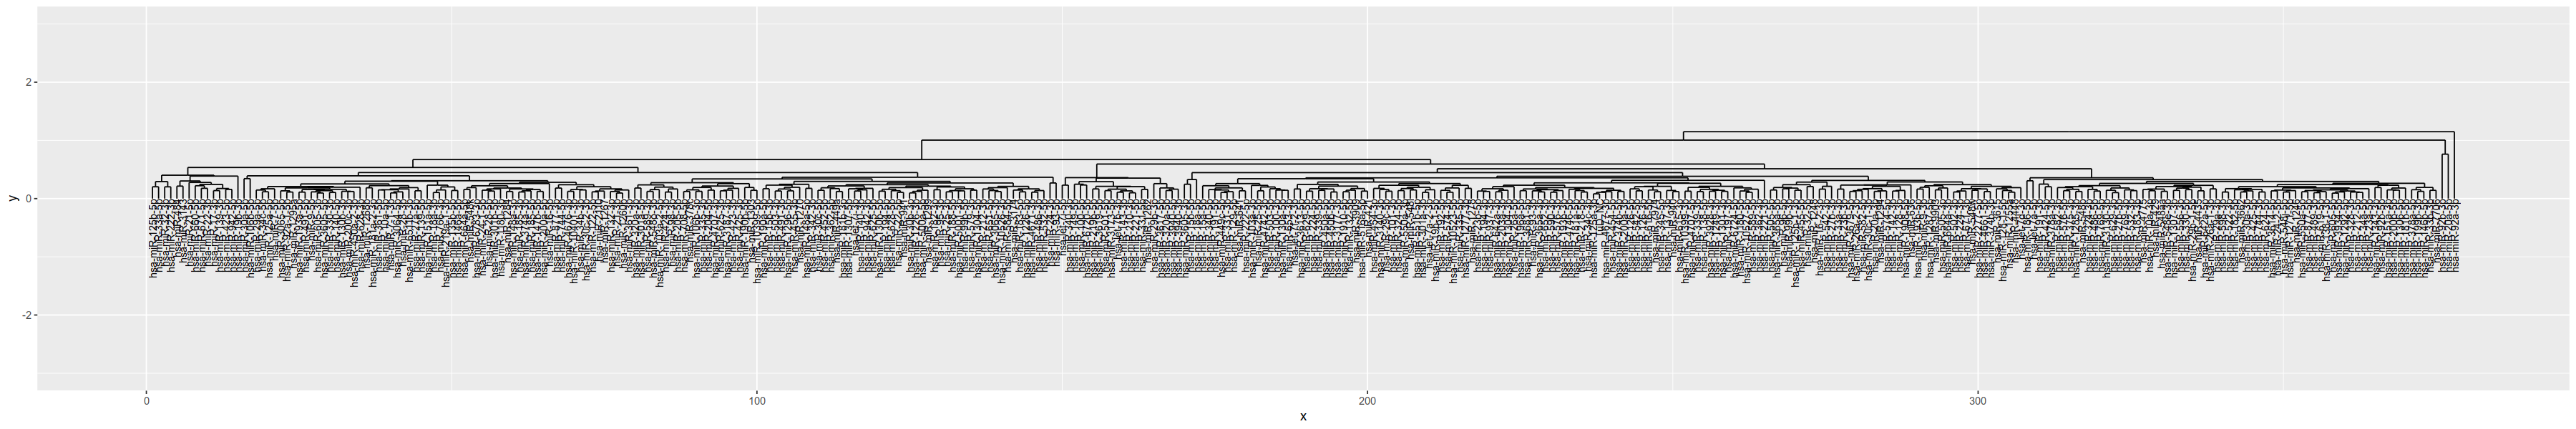

In [ ]:
options(repr.plot.width = 30, repr.plot.height = 5)
ggplot(dend_data$segments) + 
  geom_segment(aes(x = x, y = y, xend = xend, yend = yend))+
  geom_text(data = dend_data$labels, aes(x, y, label = label),
            hjust = 1, angle = 90, size = 3) + ylim(-3, 3)

## An object of class dendogram is simply nested lists (ie list of lists).
### The initial list contains two nested lists (the two leaves of the first node) and both of those nested lists contain two nested lists and so on

In [ ]:
## The labels() function allows you to see all of the members within a nested dendogram list
labels(column_dendogram[[2]])

[1] "hsa-miR-92a-3p"

In [ ]:
labels(column_dendogram[[1]][[2]])

[1] "hsa-miR-92b-3p" "hsa-miR-20a-5p"

In [ ]:
labels(column_dendogram[[1]][[1]])

[1] "hsa-miR-125b-5p"   "hsa-miR-33a-5p"    "hsa-miR-32-3p"    
  [4] "hsa-miR-222-3p"    "hsa-miR-484"       "hsa-miR-3143"     
  [7] "hsa-miR-21-5p"     "hsa-miR-660-5p"    "hsa-miR-671-5p"   
 [10] "hsa-miR-22-3p"     "hsa-miR-17-3p"     "hsa-miR-139-3p"   
 [13] "hsa-miR-423-5p"    "hsa-miR-942-5p"    "hsa-miR-19b-3p"   
 [16] "hsa-miR-30a-5p"    "hsa-miR-106b-5p"   "hsa-miR-29a-5p"   
 [19] "hsa-miR-34c-5p"    "hsa-miR-125a-5p"   "hsa-miR-7-5p"     
 [22] "hsa-miR-3065-5p"   "hsa-miR-92a-1-5p"  "hsa-miR-1295a"    
 [25] "hsa-miR-193a-5p"   "hsa-miR-491-5p"    "hsa-miR-9-5p"     
 [28] "hsa-miR-605-3p"    "hsa-miR-3605-5p"   "hsa-miR-330-3p"   
 [31] "hsa-miR-140-5p"    "hsa-miR-130b-3p"   "hsa-miR-200c-3p"  
 [34] "hsa-miR-450a-2-3p" "hsa-miR-628-3p"    "hsa-miR-1268b"    
 [37] "hsa-miR-181a-2-3p" "hsa-miR-361-5p"    "hsa-miR-10a-5p"   
 [40] "hsa-miR-7-1-3p"    "hsa-miR-3064-5p"   "hsa-miR-28-3p"    
 [43] "hsa-miR-6511b-3p"  "hsa-miR-27a-5p"    "hsa-miR-139-5p"   
 [46] "hsa-miR-151a-5p"   "hsa-miR-18a-3p"    "hsa-miR-766-3p"   
 [49] "hsa-miR-219a-1-3p" "hsa-miR-135b-5p"   "hsa-miR-146a-5p"  
 [52] "hsa-miR-664a-5p"   "hsa-miR-548k"      "hsa-miR-6783-3p"  
 [55] "hsa-miR-24-1-5p"   "hsa-miR-28-5p"     "hsa-miR-301b-5p"  
 [58] "hsa-miR-1180-3p"   "hsa-miR-1284"      "hsa-miR-148a-3p"  
 [61] "hsa-miR-185-3p"    "hsa-miR-374a-3p"   "hsa-miR-185-5p"   
 [64] "hsa-miR-147b-5p"   "hsa-miR-200a-5p"   "hsa-miR-16-5p"    
 [67] "hsa-miR-877-3p"    "hsa-miR-744-5p"    "hsa-miR-4676-3p"  
 [70] "hsa-miR-10401-3p"  "hsa-miR-34b-3p"    "hsa-miR-30c-2-3p" 
 [73] "hsa-miR-122-5p"    "hsa-miR-2110"      "hsa-miR-1267"     
 [76] "hsa-miR-132-3p"    "hsa-miR-21-3p"     "hsa-miR-1260b"    
 [79] "hsa-miR-361-3p"    "hsa-miR-320a-3p"   "hsa-miR-301a-5p"  
 [82] "hsa-miR-589-3p"    "hsa-miR-548o-3p"   "hsa-miR-103a-2-5p"
 [85] "hsa-miR-424-3p"    "hsa-miR-98-3p"     "hsa-miR-205-5p"   
 [88] "hsa-miR-708-5p"    "hsa-miR-378c"      "hsa-miR-106b-3p"  
 [91] "hsa-miR-335-3p"    "hsa-miR-204-5p"    "hsa-miR-4707-3p"  
 [94] "hsa-miR-625-3p"    "hsa-miR-3187-3p"   "hsa-miR-423-3p"   
 [97] "hsa-miR-425-3p"    "hsa-miR-190b-5p"   "hsa-miR-1303"     
[100] "hsa-miR-10399-5p"  "hsa-miR-190a-5p"   "hsa-miR-15b-3p"   
[103] "hsa-miR-503-3p"    "hsa-miR-491-3p"    "hsa-miR-1296-5p"  
[106] "hsa-miR-455-3p"    "hsa-miR-1270"      "hsa-miR-148a-5p"  
[109] "hsa-miR-342-3p"    "hsa-miR-30c-5p"    "hsa-miR-452-5p"   
[112] "hsa-miR-362-5p"    "hsa-miR-449a"      "hsa-miR-181b-3p"  
[115] "hsa-miR-1307-5p"   "hsa-let-7i-3p"     "hsa-miR-140-3p"   
[118] "hsa-miR-942-3p"    "hsa-miR-625-5p"    "hsa-miR-130b-5p"  
[121] "hsa-miR-194-5p"    "hsa-miR-628-5p"    "hsa-miR-22-5p"    
[124] "hsa-miR-941"       "hsa-miR-30b-3p"    "hsa-miR-1226-3p"  
[127] "hsa-miR-500a-5p"   "hsa-miR-1299"      "hsa-miR-182-3p"   
[130] "hsa-miR-95-3p"     "hsa-miR-25-3p"     "hsa-miR-188-5p"   
[133] "hsa-miR-5001-3p"   "hsa-miR-99b-5p"    "hsa-miR-579-3p"   
[136] "hsa-miR-1304-5p"   "hsa-miR-212-3p"    "hsa-miR-651-5p"   
[139] "hsa-miR-3065-3p"   "hsa-miR-10526-3p"  "hsa-miR-584-5p"   
[142] "hsa-miR-3174"      "hsa-miR-183-5p"    "hsa-miR-1226-5p"  
[145] "hsa-miR-4671-3p"   "hsa-miR-486-3p"    "hsa-miR-532-5p"   
[148] "hsa-miR-24-3p"     "hsa-miR-93-5p"     "hsa-let-7i-5p"    
[151] "hsa-miR-340-3p"    "hsa-miR-149-5p"    "hsa-miR-100-5p"   
[154] "hsa-miR-6720-5p"   "hsa-miR-219b-5p"   "hsa-miR-3619-5p"  
[157] "hsa-miR-501-5p"    "hsa-miR-3173-5p"   "hsa-let-7b-3p"    
[160] "hsa-miR-143-3p"    "hsa-miR-210-3p"    "hsa-miR-221-5p"   
[163] "hsa-miR-331-5p"    "hsa-miR-1262"      "hsa-miR-29b-3p"   
[166] "hsa-miR-3617-5p"   "hsa-miR-320a-5p"   "hsa-miR-3940-5p"  
[169] "hsa-miR-3940-3p"   "hsa-miR-3605-3p"   "hsa-miR-15b-5p"   
[172] "hsa-miR-18a-5p"    "hsa-miR-15a-5p"    "hsa-miR-340-5p"   
[175] "hsa-miR-191-5p"    "hsa-miR-449c-5p"   "hsa-miR-331-3p"   
[178] "hsa-miR-129-5p"    "hsa-miR-641"       "hsa-miR-222-5p"   
[181] "hsa-miR-103a-3p"   "hsa-miR-25-5p" 

In [95]:
str(column_dendogram)

--[dendrogram w/ 2 branches and 378 members at h = 1.15]
  |--[dendrogram w/ 2 branches and 377 members at h = 1.01]
  |  |--[dendrogram w/ 2 branches and 375 members at h = 0.671]
  |  |  |--[dendrogram w/ 2 branches and 149 members at h = 0.535]
  |  |  |  |--[dendrogram w/ 2 branches and 15 members at h = 0.402]
  |  |  |  |  |--[dendrogram w/ 2 branches and 4 members at h = 0.292]
  |  |  |  |  |  |--[dendrogram w/ 2 branches and 2 members at h = 0.203]
  |  |  |  |  |  |  |--leaf "hsa-miR-125b-5p" ( value.hsa-miR-125b-5p = -1.02, x = 0.5 )
  |  |  |  |  |  |  `--leaf "hsa-miR-33a-5p" ( value.hsa-miR-33a-5p = -1.02, x = 1.5 )
  |  |  |  |  |  `--[dendrogram w/ 2 branches and 2 members at h = 0.202]
  |  |  |  |  |     |--leaf "hsa-miR-32-3p" ( value.hsa-miR-32-3p = -1.02, x = 2.5 )
  |  |  |  |  |     `--leaf "hsa-miR-222-3p" ( value.hsa-miR-222-3p = -1.01, x = 3.5 )
  |  |  |  |  `--[dendrogram w/ 2 branches and 11 members at h = 0.387]
  |  |  |  |     |--[dendrogram w/ 2 branche